# Proyecto Machine Learning 
### Alejandro Campos Ochoa. DS2309
Predicción de facturación en taquilla de peliculas de cine

# Índice:

- [1. Introducción](#Índice)
    - [1.1 Librerias](#Librerias)
- [2. Lectura de datos](#Lectura-de-datos)
- [3. EDA inicial](#EDA-inicial)
- [4. Feature engineering y impieza de datos](#Limpieza-de-datos)
- [5. Transformación de datos](#Transformación-de-datos)
- [6. EDA](#EDA)
    - [6.1 Outliers](#Outliers)
- [7. Hiperparametrización y modelado](#Hiperparametrización-y-modelado)
- [8. Métricas y modelo final](#Métricas)
- [9. Pickle](#Pickle)
- [10. Next Steps](#Next-Steps)

# 1.  Introducción

Se pide la elaboración de un proyecto de machine learning de temática libre, en el cual demostraremos gran parte de las competencias y herramientas adquiridas tanto en analisis como en aprendizaje automatico.

La temática elegida es sobre el mundo del cine y las películas. Existe una abundante cantidad de información y datos disponibles en la red, susceptibles de ser analizados para la creación de un modelo de predicción.  

Nuestra variable a predecir en este caso será la facturación, denominada en adelante como 'Gross', y las variables predictoras iniciales incluyen atributos comunes a todas las películas, tales como director, estrella principal, presupuesto, puntuación de la crítica, fecha de lanzamiento, género, entre otros.  


In [72]:
# Este notebook contiene 2 diccionarios bastante grandes que es probable que estén desplegados, haz scroll despacio y cuando los veas cierra la celda para no tener lag

### 1.1 Librerias

In [42]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from scipy.stats import boxcox
from scipy import stats
import pickle
from tensorflow import keras
import warnings

warnings.filterwarnings("ignore")



# 2. Lectura de datos

In [14]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 300)
sns.set_style('darkgrid')
df = pd.read_csv('../data/raw/movies.csv')
df.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


In [ ]:
df.describe()

,year,score,votes,budget,gross,runtime
count,7668.000000,7665.000000,7.665000e+03,5.497000e+03,7.479000e+03,7664.000000
mean,2000.405451,6.390411,8.810850e+04,3.558988e+07,7.850054e+07,107.261613
std,11.153508,0.968842,1.633238e+05,4.145730e+07,1.657251e+08,18.581247
min,1980.000000,1.900000,7.000000e+00,3.000000e+03,3.090000e+02,55.000000
25%,1991.000000,5.800000,9.100000e+03,1.000000e+07,4.532056e+06,95.000000
50%,2000.000000,6.500000,3.300000e+04,2.050000e+07,2.020576e+07,104.000000
75%,2010.000000,7.100000,9.300000e+04,4.500000e+07,7.601669e+07,116.000000
max,2020.000000,9.300000,2.400000e+06,3.560000e+08,2.847246e+09,366.000000


En un primer vistazo vemos como la mayoria de nuestras variables son texto y vamos a tener que trabajar con ellas para transformarlas a variables numéricas.

De las variables numéricas podemos apreciar que:
- La mayoria de las películas del dataset están en torno al año 2000
- La desviación estandar de la variable votos es bastante grande
- La diferencia entre los presupuestos es enorme teniendo un valor mínimo de 3000 dolares y un valor maximo de 356 millones de dolares
- Al igual que con las facturaciónes teniendo un minimo de 309000 dolares y un maximo de 2800 millones. 

Tendremos que valorar si son casos atípicos o errores o si son determinantes para entender bien el comportamiento y el entrenamiento del modelo



# 3. EDA inicial

Distribución de la variable target

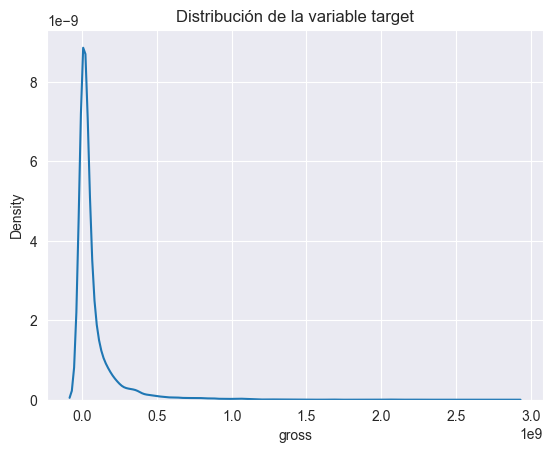

In [ ]:
sns.kdeplot(df['gross'])
plt.title('Distribución de la variable target');

Vemos que tenemos una distribución que no ayuda mucho al entrenamiento de un modelo de machine learning, no conserva una distribución normal si no mas bien asímetrica a la izquierda con cola muy prolongada a la derecha. Nos indica que hay gran cantidad de outliers o valores inusualmente altos en las facturaciones de películas.

In [15]:
df = df[['name', 'rating', 'genre', 'year', 'released', 'score', 'votes','director', 'writer', 'star', 'country', 'budget', 'company','runtime', 'gross']]

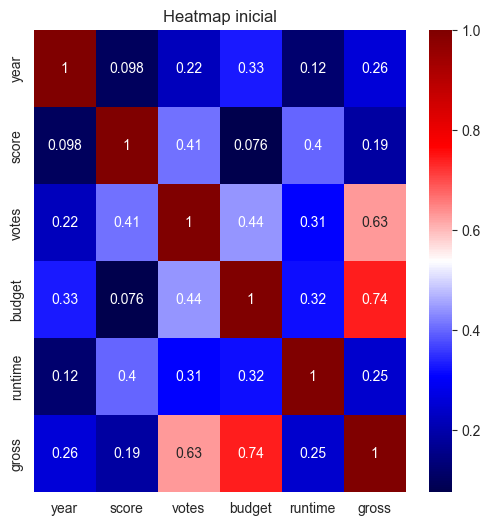

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(df.corr(numeric_only=True),annot=True, cmap='seismic')
plt.title('Heatmap inicial');

In [ ]:
# sns.pairplot(df);

# 4. Feature engineering y limpieza de datos

En primera instancia hacemos un label encoder de muchas de las variables cayendo en el error de la anarquía jerárquica numérica que establece el label encoder. Finalmente decidimos mediante un mapeo catalogar las categorias del rating según su popularidad en fuentes de internet y establecer asi una jerarquia numérica mucho mas ajustada a la realidad.

In [ ]:
print(df['rating'].nunique())
print(df['rating'].unique())

12
['R' 'PG' 'G' nan 'Not Rated' 'NC-17' 'Approved' 'TV-PG' 'PG-13' 'Unrated'
 'X' 'TV-MA' 'TV-14']


In [16]:
mapeo_rating = {'Unrated':0,
                'Not Rated':1,
                'Approved':2,
                'X':3,
                'NC-17':4,
                'TV-MA':5,
                'R':6,
                'TV-14':7,
                'PG-13':8,
                'G':9,
                'PG':10
}

df['rating_mapped'] = df['rating'].map(mapeo_rating)

Con el genero caemos en el mismo error del label encoder, investigando en paginas como wikipedia, IMdb, filmaffinity etc, establecemos una jerarquia para realizar un mapeo más cercano a la realidad.

In [ ]:
print(df['genre'].nunique())
print(df['genre'].unique())

19
['Drama' 'Adventure' 'Action' 'Comedy' 'Horror' 'Biography' 'Crime'
 'Fantasy' 'Family' 'Sci-Fi' 'Animation' 'Romance' 'Music' 'Western'
 'Thriller' 'History' 'Mystery' 'Sport' 'Musical']


In [17]:
mapeo_genre = {'Action':19,
               'Adventure':18,
               'Comedy':17,
               'Horror':16,
               'Drama':15,
               'Thriller':14,
               'Romance':13,
               'Musical':12,
               'Sci-Fi':11,
               'Fantasy':10,
               'Animation':9,
               'Mystery':8,
               'Western':7,
               'Crime':6,
               'Music':5,
               'Sport':4,
               'History':3,
               'Biograph':2,
               'Family':1}

df['genre_mapped'] = df['genre'].map(mapeo_genre)

Extraemos con 'regex' el año de publicación de la pelicula, creemos que el mes y el dia no son factores importantes.

In [18]:
df['country_date'] = df['released'].str.extract(r'\((.*?)\)')

Como venía siendo habitual el label encoder fue en primer lugar la herramienta utilizada, para dejar paso a la buena praxis tras el error.

Consideramos que puntuar bien a los directores es algo imporante ya que no afectará de la misma manera a la facutración de una película que la dirija Cristopher Nolan a un director emergente apenas conocido. 

En este caso nos apoyamos en la herramienta ChatGPT para puntuar de 0 a 10 y luego exponenciando este valor para valorar distancias, toda la lista de directores siendo 0 el valor minimo y 10 el valor máximo (más tarde multiplicamos por 10 la 'nota').

El criterio utilizado para puntuar los directores es la popularidad y la importancia de ellos en la industria del cine.

In [ ]:
print(df['director'].nunique())
print(df['director'].unique())

2949
['Stanley Kubrick' 'Randal Kleiser' 'Irvin Kershner' ... 'Nkanya Nkwai'
 'James Randall' 'Pereko Mosia']


In [19]:
mapeo_directores= {'Stanley Kubrick': 9,
                    'Randal Kleiser': 5,
                    'Irvin Kershner': 6,
                    'Jim Abrahams': 4,
                    'Harold Ramis': 7,
                    'Sean S. Cunningham': 3,
                    'John Landis': 6,
                    'Martin Scorsese': 8,
                    'Richard Lester': 5,
                    'Walter Hill': 6,
                    'Buddy Van Horn': 4,
                    'Jamie Uys': 3,
                    'Robert Altman': 7,
                    'Robert Redford': 6,
                    'Brian De Palma': 7,
                    'Jeannot Szwarc': 4,
                    'Alan Parker': 6,
                    'Colin Higgins': 4,
                    'John Carpenter': 7,
                    'Sidney Poitier': 5,
                    'William Friedkin': 7,
                    'Michael Cimino': 5,
                    'Don Taylor': 4,
                    'Robert Greenwald': 4,
                    'James Bridges': 5,
                    'Ken Russell': 4,
                    'Ron Maxwell': 4,
                    'Jerry Jameson': 4,
                    'Stuart Rosenberg': 5,
                    'Paul Schrader': 6,
                    'Tony Bill': 5,
                    'Paul Lynch': 4,
                    'Hal Needham': 4,
                    'Lamont Johnson': 4,
                    'Jay Sandrich': 4,
                    'Howard Zieff': 4,
                    'Floyd Mutrux': 4,
                    'Kevin Connor': 4,
                    'Richard Fleischer': 5,
                    'Michael Apted': 5,
                    'John Hough': 4,
                    'Bruce Beresford': 5,
                    'Richard Rush': 5,
                    'Art Linson': 4,
                    'Mike Newell': 5,
                    'Tommy Chong': 3,
                    'Michael Ritchie': 5,
                    'Ulli Lommel': 3,
                    'Clive Donner': 4,
                    'Moustapha Akkad': 4,
                    'Woody Allen': 8,
                    'Jonathan Demme': 6,
                    'Nancy Walker': 4,
                    'Clint Eastwood': 8,
                    'Federico Fellini': 7,
                    'Lang Elliott': 4,
                    'James Goldstone': 4,
                    'Joe Camp': 3,
                    'Eric Karson': 3,
                    'James L. Conway': 4,
                    'Vincent McEveety': 4,
                    'Joel Oliansky': 4,
                    'Claudia Weill': 4,
                    'Jerry Schatzberg': 4,
                    'Daniel Petrie': 4,
                    'Anne Bancroft': 5,
                    'Vladimir Menshov': 4,
                    'Piers Haggard': 4,
                    'Bill Persky': 4,
                    'Martin Davidson': 4,
                    'Gary Weis': 4,
                    'Bill Melendez': 4,
                    'Marty Feldman': 4,
                    'Alan Rudolph': 4,
                    'Sidney Lumet': 7,
                    'Charles Jarrott': 4,
                    'Walter Bernstein': 4,
                    'Paul Mazursky': 5,
                    'Franco Rosso': 4,
                    'Kieth Merrill': 4,
                    'John Huston': 6,
                    'Gordon Willis': 4,
                    'Jack Smight': 4,
                    'Paul Grimault': 4,
                    'Gilbert Cates': 4,
                    'Michael Pressman': 4,
                    'Édouard Molinaro': 4,
                    'Chuck Barris': 3,
                    'Mike Nichols': 7,
                    'Larry Peerce': 4,
                    'Buck Henry': 4,
                    'Wing-Cho Yip': 4,
                    'Steven Spielberg': 9,
                    'Lawrence Kasdan': 6,
                    'Sam Raimi': 7,
                    'Bob Clark': 5,
                    'Desmond Davis': 4,
                    'John Boorman': 6,
                    'George Miller': 7,
                    'Wolfgang Petersen': 6,
                    'Ivan Reitman': 7,
                    'Andrzej Zulawski': 5,
                    'Michael Mann': 7,
                    'Franco Zeffirelli': 6,
                    'Terry Gilliam': 8,
                    'Alan Alda': 5,
                    'Steve Miner': 5,
                    'David Cronenberg': 7,
                    'John Glen': 5,
                    'Rick Rosenthal': 4,
                    'Harold Becker': 5,
                    'Warren Beatty': 6,
                    'Mark Rydell': 5,
                    'Directors': 0,
                    'Hugh Hudson': 4,
                    'Sydney Pollack': 6,
                    'John Derek': 4,
                    'Steve Gordon': 4,
                    'Louis Malle': 6,
                    'Carl Gottlieb': 4,
                    'Gary Sherman': 4,
                    'Mel Brooks': 6,
                    'Joe Dante': 6,
                    'Matthew Robbins': 4,
                    'Ivan Passer': 4,
                    'Jean-Jacques Annaud': 6,
                    'Graham Baker': 4,
                    'Frank Perry': 4,
                    'Alan Myerson': 4,
                    'Bob Rafelson': 5,
                    'Milos Forman': 7,
                    'Wes Craven': 6,
                    'Peter Yates': 5,
                    'Peter Weir': 7,
                    'Peter Hyams': 5,
                    'Blake Edwards': 6,
                    'Lucio Fulci': 4,
                    'John Irvin': 4,
                    'George Mihalka': 4,
                    'Tobe Hooper': 6,
                    'Francis Ford Coppola': 8,
                    'Karel Reisz': 5,
                    'Jim Henson': 6,
                    'Ulu Grosbard': 4,
                    'Michael Crichton': 5,
                    'Bruce Malmuth': 4,
                    'Burt Reynolds': 4,
                    'John G. Avildsen': 5,
                    'Richard Marquand': 5,
                    'Michael Wadleigh': 4,
                    'Mickey Rose': 4,
                    'Oliver Stone': 7,
                    'Jean-Jacques Beineix': 4,
                    'Ken Wiederhorn': 4,
                    'Peter Medak': 5,
                    'Steve Rash': 4,
                    'Michael Schultz': 5,
                    'Joel Schumacher': 6,
                    'James Ivory': 5,
                    'Herb Freed': 4,
                    'Ken Shapiro': 4,
                    'Herbert Ross': 6,
                    'Ralph Bakshi': 4,
                    'William A. Fraker': 4,
                    'Franklin J. Schaffner': 5,
                    'Ken Hughes': 4,
                    'Steve Carver': 4,
                    'Luis Valdez': 4,
                    'George Cukor': 5,
                    'Billy Wilder': 7,
                    'Oz Scott': 4,
                    'Albert Brooks': 5,
                    'Allan Arkush': 4,
                    'Martin Ritt': 5,
                    'Gus Trikonis': 4,
                    'Jack Fisk': 4,
                    'John Badham': 5,
                    'Terence Young': 5,
                    'Jean-Claude Tramont': 4,
                    'Roger Spottiswoode': 5,
                    'Alan J. Pakula': 6,
                    'Glenn Jordan': 4,
                    'John Schlesinger': 6,
                    'David Steinberg': 4,
                    'Noel Nosseck': 4,
                    'Byron Quisenberry': 4,
                    'Steven Hilliard Stern': 4,
                    'E.W. Swackhamer': 4,
                    'Ferdinando Baldi': 4,
                    'Jacques Rivette': 5,
                    'Allan King': 4,
                    'Amy Heckerling': 5,
                    'Ridley Scott': 8,
                    'John Milius': 6,
                    'Ted Kotcheff': 5,
                    'Taylor Hackford': 6,
                    'Patricia Birch': 4,
                    'Nicholas Meyer': 5,
                    'Stuart Gillard': 4,
                    'Boaz Davidson': 4,
                    'Richard Attenborough': 6,
                    'Steven Lisberger': 5,
                    'Don Bluth': 5,
                    'Sylvester Stallone': 7,
                    'Don Coscarelli': 4,
                    'George A. Romero': 6,
                    'Ingmar Bergman': 7,
                    'Tommy Lee Wallace': 4,
                    'Juan Piquer Simón': 3,
                    'Robert J. Rosenthal': 4,
                    'George Roy Hill': 5,
                    'Barry Levinson': 6,
                    'Ron Howard': 7,
                    'Jules Bass': 4,
                    'Sidney J. Furie': 4,
                    'Ken Finkleman': 4,
                    'Richard Donner': 7,
                    'Mark Rosman': 4,
                    'Guy Hamilton': 5,
                    'Albert Pyun': 3,
                    'Michael Winner': 4,
                    'Michael Miller': 4,
                    'Robert Towne': 5,
                    'Carl Reiner': 6,
                    'Damiano Damiani': 4,
                    'Costa-Gavras': 6,
                    'Graeme Clifford': 4,
                    'David Schmoeller': 4,
                    'David S. Ward': 5,
                    'Tim Hunter': 4,
                    'Tom Kennedy': 4,
                    'Richard T. Heffron': 4,
                    'Garry Marshall': 6,
                    'Richard Benjamin': 5,
                    'Robert Benton': 5,
                    'Charles Band': 4,
                    'Arthur Hiller': 5,
                    'Philippe Mora': 4,
                    'Ian Sharp': 4,
                    'Roger Christian': 4,
                    'Tony Richardson': 6,
                    'Robert Mulligan': 5,
                    'Norman Jewison': 6,
                    'Hal Ashby': 6,
                    'Fred Schepisi': 5,
                    'Jean-Claude Lord': 4,
                    'Bruce Paltrow': 4,
                    'John Frankenheimer': 6,
                    'James Glickenhaus': 4,
                    'Richard Brooks': 5,
                    'Wim Wenders': 6,
                    'Jerry Belson': 4,
                    'James Fargo': 5,
                    'Richard Loncraine': 4,
                    'Caleb Deschanel': 4,
                    'Delbert Mann': 4,
                    'Thomas K. Avildsen': 4,
                    'James Beshears': 4,
                    'Don Siegel': 6,
                    'Daniel Vigne': 4,
                    'Elliott Hong': 4,
                    'Fred Zinnemann': 5,
                    'Jamaa Fanaka': 4,
                    'Eric Till': 4,
                    'James Burrows': 4,
                    'Joe Layton': 4,
                    'Lewis Teague': 4,
                    'Wolf Gremm': 4,
                    'Fumihiko Takayama': 4,
                    'Robert Taylor': 4,
                    'John Wintergate': 4,
                    'Peter Duffell': 4,
                    'Peter Markle': 4,
                    'Paul Cox': 4,
                    'Paul Brickman': 5,
                    'Joe Alves': 4,
                    'Robert Hiltzik': 4,
                    'Adrian Lyne': 7,
                    'Philip Kaufman': 6,
                    'Noel Black': 4,
                    'Martha Coolidge': 5,
                    'James L. Brooks': 6,
                    'Tony Scott': 7,
                    'Stan Dragoti': 4,
                    'Jim McBride': 5,
                    'Richard Franklin': 4,
                    'Bill Forsyth': 5,
                    'Michael Chapman': 5,
                    'George Bowers': 4,
                    'Barbra Streisand': 6,
                    'Mel Damski': 4,
                    'Terry Jones': 5,
                    'Andrei Tarkovsky': 7,
                    'Dick Lowry': 4,
                    'James Sbardellati': 4,
                    'Jack Clayton': 5,
                    'Bob Fosse': 6,
                    'James Signorelli': 4,
                    'Nagisa Ôshima': 6,
                    'Curtis Hanson': 6,
                    'Rafal Zielinski': 4,
                    'Douglas Trumbull': 6,
                    "Robert Vincent O'Neil": 4,
                    'J. Lee Thompson': 5,
                    'Howard Avedis': 4,
                    'Andrew V. McLaglen': 4,
                    'John Herzfeld': 5,
                    'Paul Nicholas': 4,
                    'Brian G. Hutton': 4,
                    'Carroll Ballard': 5,
                    'Wilford Leach': 4,
                    'Clive Smith': 4,
                    'Luigi Cozzi': 4,
                    'Lewis Gilbert': 5,
                    'Lynne Littman': 4,
                    'Sam Peckinpah': 6,
                    'Sam Firstenberg': 4,
                    'Robert Mandel': 4,
                    'Enzo G. Castellari': 4,
                    'Alan Johnson': 4,
                    'Nicolas Roeg': 6,
                    'Antonio Margheriti': 4,
                    'George P. Cosmatos': 5,
                    'John Mackenzie': 4,
                    'Peter Sasdy': 4,
                    'Franc Roddam': 5,
                    'Joseph Sargent': 4,
                    'Jeff Kanew': 4,
                    'Jeremy Kagan': 4,
                    'John Sayles': 5,
                    'Jonathan Kaplan': 5,
                    'Amy Holden Jones': 4,
                    'Ferdinand Fairfax': 4,
                    'Michael Laughlin': 4,
                    'Robert Dalva': 4,
                    'William Olsen': 4,
                    'Bryan Forbes': 5,
                    'Marshall Brickman': 5,
                    'Donald Shebib': 4,
                    'James Toback': 4,
                    'Michael Tuchner': 4,
                    'Cirio H. Santiago': 4,
                    'Robert Lieberman': 4,
                    'Lawrence David Foldes': 4,
                    'Dick Richards': 4,
                    'Terry Bedford': 4,
                    'Roland Klick': 4,
                    'Richard Pryor': 6,
                    'Paul Aaron': 4,
                    'Charles Burnett': 4,
                    'Richard Michaels': 4,
                    'David Nelson': 4,
                    'Mark Pirro': 4,
                    'David Drury': 4,
                    'Frank Zuniga': 4,
                    'Tom Logan': 4,
                    'James Cameron': 8,
                    'David Lynch': 7,
                    'Sergio Leone': 7,
                    'Hugh Wilson': 5,
                    'Martin Brest': 6,
                    'Robert Zemeckis': 7,
                    'John Hughes': 6,
                    'Rob Reiner': 6,
                    'Michael Radford': 5,
                    'Fritz Kiersch': 4,
                    'Nick Castle': 5,
                    'Joel Coen': 7,
                    'Neal Israel': 4,
                    'Hayao Miyazaki': 8,
                    'Joseph Zito': 4,
                    'Mark Griffiths': 4,
                    'Roger Donaldson': 5,
                    'Mark L. Lester': 5,
                    'Douglas Cheek': 4,
                    'Gene Wilder': 6,
                    'W.D. Richter': 5,
                    'Leonard Nimoy': 5,
                    'Alex Cox': 6,
                    'Roland Joffé': 6,
                    'Thom Eberhardt': 4,
                    'Stanley Donen': 5,
                    'Joseph Ruben': 5,
                    'Stewart Raffill': 4,
                    'Jim Jarmusch': 6,
                    'David Lean': 7,
                    'Albert Magnoli': 5,
                    'Stephen Frears': 6,
                    'John Guillermin': 4,
                    'Frank Oz': 6,
                    'Just Jaeckin': 4,
                    'Joel Silberg': 4,
                    'Neil Jordan': 6,
                    'Luca Bercovici': 4,
                    'Steve Barron': 5,
                    'Charles E. Sellier Jr.': 4,
                    'Hy Averback': 4,
                    'James Foley': 5,
                    'Richard Tuggle': 4,
                    'Robert Butler': 4,
                    'Stan Lathan': 4,
                    'John Byrum': 4,
                    'Marvin J. Chomsky': 4,
                    'John C. Broderick': 4,
                    'Ruggero Deodato': 4,
                    'Tengiz Abuladze': 5,
                    'Russell Mulcahy': 5,
                    'Roger Young': 4,
                    'Charles Shyer': 5,
                    'William Tannen': 4,
                    'Paul Bartel': 4,
                    'Jim Sotos': 4,
                    'Robert Boris': 4,
                    'Douglas Day Stewart': 4,
                    'Willard Huyck': 5,
                    'Mark Buntzman': 4,
                    'Dorian Walker': 4,
                    'Éric Rohmer': 6,
                    'Gillian Armstrong': 5,
                    'Richard Pearce': 4,
                    'Peter Webb': 4,
                    'Marcelo Epstein': 4,
                    'Thomas Rickman': 4,
                    'Paolo Taviani': 5,
                    'Malcolm Mowbray': 4,
                    'Rob Cohen': 5,
                    'Paul Bogart': 4,
                    'Lawrence Dane': 4,
                    'Bobby Roth': 4,
                    'Bertrand Tavernier': 5,
                    'Armyan Bernstein': 4,
                    'Rod Amateau': 4,
                    'Richard C. Sarafian': 4,
                    'Lawrence Bassoff': 4,
                    'Menahem Golan': 4,
                    'Ken Cameron': 4,
                    'Károly Makk': 4,
                    'Roy Battersby': 4,
                    'Adam Brooks': 4,
                    'Ippei Kuri': 4,
                    'Gene Taft': 4,
                    'Gérard Lauzier': 4,
                    'Jonathan Lynn': 4,
                    'Peter Bogdanovich': 5,
                    "Dan O'Bannon": 5,
                    'Rod Daniel': 4,
                    'Savage Steve Holland': 4,
                    'Akira Kurosawa': 7,
                    'Tom Holland': 5,
                    'Paul Verhoeven': 7,
                    'Jack Sholder': 4,
                    'Tim Burton': 7,
                    'Lisa Gottlieb': 4,
                    'Jerry Paris': 4,
                    'Ted Berman': 4,
                    'Danny Steinmann': 4,
                    'Andrey Konchalovskiy': 5,
                    'Stuart Gordon': 5,
                    'Susan Seidelman': 4,
                    'Alan Metter': 4,
                    'Howard Storm': 4,
                    'Jackie Chan': 6,
                    'Daniel Attias': 4,
                    'Hector Babenco': 5,
                    'Joyce Chopra': 4,
                    'James Komack': 4,
                    'Geoff Murphy': 4,
                    'Jûzô Itami': 5,
                    'William Malone': 4,
                    'David Greenwalt': 4,
                    'Corey Yuen': 5,
                    'Simon Wincer': 5,
                    'Michael Dinner': 4,
                    'Kevin Reynolds': 5,
                    'Rudy De Luca': 4,
                    'Donna Deitch': 4,
                    'Cary Medoway': 4,
                    'Lasse Hallström': 6,
                    'Jonathan R. Betuel': 4,
                    'Linda Feferman': 4,
                    'James Frawley': 4,
                    'Luc Besson': 7,
                    'John McTiernan': 6,
                    'Bill Norton': 4,
                    'Andrew Davis': 5,
                    'Robert Clouse': 4,
                    'Christopher Cain': 5,
                    'Will Vinton': 4,
                    'Mike Hodges': 4,
                    'Peter Masterson': 4,
                    'Lance Hool': 4,
                    'Phillip Borsos': 4,
                    'Luis Puenzo': 5,
                    'Hal Barwood': 4,
                    'Edward Yang': 6,
                    'Emir Kusturica': 6,
                    'Steven Hahn': 4,
                    'Paul Donovan': 4,
                    'Arna Selznick': 4,
                    'Bud Yorkin': 4,
                    'Dick Clement': 5,
                    'Robert Dornhelm': 5,
                    'Freddie Francis': 4,
                    'Gavin Millar': 4,
                    'Harvey Miller': 4,
                    'David Hare': 5,
                    'Bernard Deyriès': 4,
                    'Coline Serreau': 5,
                    'Raju Patel': 4,
                    'Jovan Acin': 4,
                    'Stephen Gyllenhaal': 4,
                    'Ray Lawrence': 4,
                    'Jonathan Sanger': 4,
                    'István Szabó': 5,
                    'Gary Hudson': 4,
                    'William Asher': 4,
                    'Georges Lautner': 4,
                    'Michael Pearce': 4,
                    'Ettore Scola': 6,
                    'Roger L. Simon': 4,
                    'Sig Shore': 4,
                    'Rob Nilsson': 4,
                    'Cary Parker': 4,
                    'Ian Mune': 4,
                    'Brian Gilbert': 5,
                    'Patrick Jamain': 4,
                    'Mehdi Charef': 4,
                    'Petru Popescu': 4,
                    'Caroline Huppert': 4,
                    'Peter Faiman': 4,
                    'Howard Deutch': 4,
                    'Mike Marvin': 4,
                    'David Anspaugh': 5,
                    'Lizzie Borden': 4,
                    'Stephen King': 6,
                    'David Seltzer': 4,
                    'Tom McLoughlin': 4,
                    'Edward Zwick': 6,
                    'Stephen Herek': 5,
                    'John McNaughton': 4,
                    'Fred Dekker': 4,
                    'Robert Harmon': 4,
                    'Harry Winer': 4,
                    'Nelson Shin': 4,
                    'John Carl Buechler': 4,
                    'Spike Lee': 7,
                    'Brian Gibson': 5,
                    'Leos Carax': 6,
                    'Anthony Perkins': 5,
                    'Gary Nelson': 4,
                    'Masanori Hata': 4,
                    'Derek Jarman': 6,
                    'Randa Haines': 4,
                    'Pedro Almodóvar': 7,
                    'Fred Walton': 4,
                    'Roman Polanski': 6,
                    'Trevor Nunn': 4,
                    'Claude Berri': 5,
                    'Charles Martin Smith': 4,
                    'Penny Marshall': 6,
                    'Duncan Gibbins': 4,
                    'David Byrne': 5,
                    'Jimmy T. Murakami': 4,
                    'Tom DeSimone': 4,
                    'Paul Michael Glaser': 5,
                    'Richard Wenk': 4,
                    'Ted Nicolaou': 4,
                    'Thomas Michael Donnelly': 4,
                    'Harley Cokeliss': 4,
                    'Robert M. Young': 4,
                    'Peter Manoogian': 4,
                    'Jerry Kramer': 4,
                    'Kevin Tenney': 4,
                    'Christopher Morahan': 4,
                    'Prince': 6,
                    'Nadia Tass': 4,
                    'George Mendeluk': 4,
                    'Marco Bellocchio': 5,
                    'Julien Temple': 4,
                    'Jeffrey Delman': 4,
                    'William Fruet': 4,
                    'Emilio Estevez': 5,
                    'Jim Goddard': 4,
                    'Director': 0,
                    'David Beaird': 4,
                    'Bob Swaim': 4,
                    'Moshé Mizrahi': 5,
                    'Denys Arcand': 5,
                    'Gene Saks': 4,
                    'Paul Schneider': 4,
                    'Bill Sherwood': 4,
                    'Daryl Duke': 4,
                    'Bob Weinstein': 4,
                    'Tom Moore': 4,
                    'Andrew Lane': 4,
                    'Michelle Manning': 4,
                    'Zoran Perisic': 4,
                    'Bertrand Blier': 5,
                    'Simon Langton': 4,
                    'Dale Schott': 4,
                    'Dominic Orlando': 4,
                    'Renny Harlin': 5,
                    'Eugene Corr': 4,
                    'Eliseo Subiela': 5,
                    'Allan Burns': 4,
                    'Henning Carlsen': 4,
                    'Gideon Amir': 4,
                    'Fred Olen Ray': 4,
                    'Jerrold Freedman': 4,
                    'Fons Rademakers': 5,
                    'Evelyn Purcell': 4,
                    'Deran Sarafian': 4,
                    'Frank Harris': 4,
                    'Claude Lelouch': 6,
                    'Emile Ardolino': 5,
                    'Chris Columbus': 5,
                    'Kathryn Bigelow': 6,
                    'Michael Gottlieb': 4,
                    'Gary Goddard': 4,
                    'Clive Barker': 5,
                    'Chuck Russell': 5,
                    'Bruce Robinson': 4,
                    'Bernardo Bertolucci': 7,
                    'Marek Kanievska': 4,
                    'Joe Roth': 4,
                    'William Dear': 4,
                    'Michael Gornick': 4,
                    'Jim Drake': 4,
                    'Jimmy Huston': 4,
                    'Jeffrey Bloom': 4,
                    'Tom Mankiewicz': 4,
                    'Danny DeVito': 6,
                    'Christopher Leitch': 4,
                    'David Hugh Jones': 4,
                    'Tibor Takács': 4,
                    'John R. Cherry III': 4,
                    'Steve De Jarnatt': 4,
                    'Barbet Schroeder': 5,
                    'Alan Clarke': 4,
                    'Peter Werner': 4,
                    'Elaine May': 5,
                    'Norman Mailer': 4,
                    'Gabriel Axel': 4,
                    'Percy Adlon': 4,
                    'Phil Joanou': 5,
                    'William Phelps': 4,
                    'Ethan Wiley': 4,
                    'David Mamet': 6,
                    'Élie Chouraqui': 4,
                    'Peter R. Hunt': 4,
                    'Lyndall Hobbs': 4,
                    'Cheech Marin': 4,
                    'Bille August': 5,
                    'Janice Karman': 4,
                    'Tamar Simon Hoffs': 4,
                    'Bruce Pittman': 4,
                    'Bob Giraldi': 4,
                    'Jeff Bleckner': 4,
                    'John Flynn': 4,
                    'Dennis Feldman': 4,
                    "Pat O'Connor": 4,
                    'Ben Bolt': 4,
                    'David Leland': 4,
                    'René Laloux': 4,
                    'David Keith': 4,
                    'Lindsay Anderson': 4,
                    'Wayne Wang': 5,
                    'Lee Harry': 4,
                    'David DeCoteau': 4,
                    'Tom Daley': 4,
                    'Robert Collector': 4,
                    'Mary Lambert': 5,
                    'Paul Weiland': 5,
                    'Donald Cammell': 5,
                    'Robert Townsend': 4,
                    'Melvin Frank': 4,
                    'Bill Froehlich': 4,
                    'Michael Hoffman': 5,
                    'Arthur Penn': 5,
                    'Charlie Loventhal': 4,
                    'Abel Ferrara': 5,
                    'Christine Edzard': 4,
                    'John Duigan': 5,
                    'Peter Greenaway': 5,
                    'Phil Alden Robinson': 5,
                    'Diane Kurys': 4,
                    'Bigas Luna': 5,
                    'Nikita Mikhalkov': 5,
                    'Stephen Carpenter': 4,
                    'Peter Del Monte': 4,
                    'Bill Condon': 5,
                    'Terry Leonard': 4,
                    'Dorothy Ann Puzo': 4,
                    'Paul Newman': 5,
                    'Yurek Bogayevicz': 4,
                    'John Cornell': 4,
                    'Michael Lehmann': 5,
                    'Donald Petrie': 4,
                    'Katsuhiro Ôtomo': 7,
                    'Giuseppe Tornatore': 6,
                    'David Zucker': 6,
                    'Charles Crichton': 5,
                    'Newt Arnold': 4,
                    'Peter MacDonald': 4,
                    'John Waters': 5,
                    'Ron Shelton': 5,
                    'George Scribner': 4,
                    'Zalman King': 4,
                    'Stephen Chiodo': 4,
                    'Dwight H. Little': 4,
                    'Keenen Ivory Wayans': 5,
                    'Stan Winston': 4,
                    'Greg Beeman': 4,
                    'Tony Randel': 4,
                    'Dennis Hopper': 5,
                    'Robert Bierman': 4,
                    'Ken Annakin': 5,
                    'Ramón Menéndez': 4,
                    'William Lustig': 4,
                    'Zelda Barron': 4,
                    'Anthony Hickox': 4,
                    'Kar-Wai Wong': 6,
                    'Bud S. Smith': 4,
                    'Francis Megahy': 4,
                    'Kenneth Johnson': 4,
                    'William Richert': 4,
                    'Carl Schultz': 4,
                    'Craig R. Baxley': 4,
                    'Frank LaLoggia': 4,
                    'David Green': 4,
                    'Mick Garris': 4,
                    'Mark Goldblatt': 4,
                    'Joan Freeman': 4,
                    'Paul Flaherty': 4,
                    'Geneviève Robert': 4,
                    'Rowdy Herrington': 4,
                    'Steven Kampmann': 4,
                    'Mira Nair': 5,
                    'Yahoo Serious': 4,
                    'Geoff Burrowes': 4,
                    'Roger Vadim': 5,
                    'Mike Leigh': 5,
                    'Bruno Nuytten': 5,
                    'Ken Kwapis': 4,
                    'Catherine Breillat': 5,
                    'Annabel Jankel': 4,
                    'Aaron Norris': 4,
                    'Jon Hess': 4,
                    'Camilo Vila': 4,
                    'Jim Wynorski': 4,
                    'Ernest Thompson': 4,
                    'Henry Winkler': 4,
                    'Claire Denis': 5,
                    'Andrew Fleming': 4,
                    'Bernard Rose': 5,
                    'James B. Harris': 4,
                    'Paul Golding': 4,
                    'Mike Figgis': 5,
                    'Matthew Chapman': 4,
                    'Gary Sinise': 5,
                    'Glenn Gordon Caron': 4,
                    'Joan Micklin Silver': 5,
                    'David Stevens': 4,
                    'Robert Englund': 4,
                    'James Dearden': 5,
                    'Keith Gordon': 4,
                    'William Webb': 4,
                    'Pen Densham': 4,
                    'Janet Greek': 4,
                    'Charles Sturridge': 5,
                    'Martin Campbell': 5,
                    'Gordon Hessler': 4,
                    'Marisa Silver': 4,
                    'Terence Davies': 5,
                    'Daniel Goldberg': 4,
                    'Christopher Crowe': 4,
                    'Bill Fishman': 4,
                    'Martin Donovan': 4,
                    'Ron Clements': 4,
                    'Joe Johnston': 5,
                    'Steven Soderbergh': 6,
                    'Jeremiah S. Chechik': 4,
                    'Cameron Crowe': 5,
                    'Eddie Murphy': 6,
                    'Jim Sheridan': 5,
                    'Richard Greenberg': 4,
                    'Todd Holland': 4,
                    'Jay Levey': 4,
                    'William Shatner': 5,
                    'Robert Radler': 4,
                    'Phillip Noyce': 5,
                    'Mark DiSalle': 4,
                    'Gus Van Sant': 6,
                    'Stephen Hopkins': 5,
                    'Marc Rocco': 4,
                    'Dominique Othenin-Girard': 4,
                    'Kenneth Branagh': 6,
                    'Rob Hedden': 4,
                    'Michael Caton-Jones': 5,
                    'Steve Kloves': 4,
                    'Chris Walas': 4,
                    'Joe Pytka': 4,
                    'John Dahl': 5,
                    'Michael Anderson': 4,
                    'Uli Edel': 5,
                    'Masami Hata': 4,
                    'Carl Schenkel': 4,
                    'Peter Bonerz': 4,
                    'David Webb Peoples': 5,
                    'Francis Veber': 5,
                    'Thomas J. Wright': 4,
                    'Larry Cohen': 4,
                    'Mick Jackson': 5,
                    'Jeff Burr': 4,
                    'Christopher Guest': 5,
                    'Bob Balaban': 4,
                    'Gary David Goldberg': 4,
                    'Norman René': 4,
                    'John Howley': 4,
                    'Euzhan Palcy': 5,
                    'Dave Thomas': 4,
                    'Hal Hartley': 5,
                    'James Isaac': 4,
                    'Mel Smith': 4,
                    'Michael Herz': 4,
                    'Takeshi Kitano': 6,
                    'Richard Baskin': 4,
                    'Jane Campion': 6,
                    'Thomas Schlamme': 4,
                    'Damian Harris': 4,
                    'Robert Wise': 5,
                    'Jim Wheat': 4,
                    'Jim Kouf': 4,
                    'Michael Schroeder': 4,
                    'Ildikó Enyedi': 5,
                    'Thierry Notz': 4,
                    'Cedric Sundstrom': 4,
                    'Will Mackenzie': 4,
                    'Gérard Kikoïne': 4,
                    'Robert Ellis Miller': 4,
                    'Jeff Blyth': 4,
                    'Patrice Leconte': 5,
                    'John D. Hancock': 4,
                    'Howard Brookner': 4,
                    'Lee Grant': 4,
                    'Michael A. Simpson': 4,
                    'David Odell': 4,
                    'Patrick Sheane Duncan': 4,
                    'Nancy Savoca': 5,
                    'Joel Zwick': 4,
                    'Michael Fischa': 4,
                    'Jerry Zucker': 5,
                    'Kevin Costner': 5,
                    'Ron Underwood': 5,
                    'Volker Schlöndorff': 5,
                    'Frank Marshall': 5,
                    'Harry Hook': 4,
                    'John Lafia': 4,
                    'John Patrick Shanley': 5,
                    'Richard Linklater': 6,
                    'William Peter Blatty': 5,
                    'Jack Nicholson': 6,
                    'Sheldon Lettich': 4,
                    'Dennis Dugan': 5,
                    'Hendel Butoy': 4,
                    'Reginald Hudlin': 5,
                    'Tom Savini': 4,
                    'Allan Moyle': 5,
                    'Frank Henenlotter': 4,
                    'Sally Mattison': 4,
                    'Luis Mandoki': 5,
                    'Abbas Kiarostami': 6,
                    'Howard Franklin': 4,
                    'Richard Stanley': 4,
                    'James Orr': 4,
                    'Andrew Bergman': 5,
                    'Ralph S. Singleton': 4,
                    'Tom Stoppard': 6,
                    'John Harrison': 4,
                    'Whit Stillman': 5,
                    'Agnieszka Holland': 5,
                    'Jean-Paul Rappeneau': 5,
                    'Anthony Minghella': 6,
                    'Bob Hathcock': 4,
                    'Joseph Barbera': 4,
                    'Bob Logan': 4,
                    'George Armitage': 5,
                    'Peter Israelson': 4,
                    'Robert Resnikoff': 4,
                    'Yimou Zhang': 6,
                    'Martin Sheen': 5,
                    'Adam Simon': 4,
                    'Tom Ropelewski': 4,
                    'Dario Argento': 6,
                    'Jan Egleson': 4,
                    'Roger Corman': 5,
                    'Franco Amurri': 5,
                    'Richard Correll': 4,
                    'Robert Shaye': 4,
                    'Ken Loach': 6,
                    'Patrick Read Johnson': 4,
                    'James Bond III': 4,
                    'James D. Parriott': 4,
                    'Yves Robert': 4,
                    'Katt Shea': 4,
                    'John Erman': 4,
                    'Greydon Clark': 4,
                    'Gregg Champion': 4,
                    'Cynthia Scott': 4,
                    'Kristine Peterson': 4,
                    'Jon Amiel': 5,
                    'Sondra Locke': 4,
                    'Christian Vincent': 4,
                    'Haruki Kadokawa': 4,
                    'Bernt Amadeus Capra': 4,
                    'Michael Verhoeven': 4,
                    'Guy Maddin': 4,
                    'John Singleton': 5,
                    'Bryan Gordon': 4,
                    'Barry Sonnenfeld': 6,
                    'Alfonso Cuarón': 6,
                    'Gary Trousdale': 4,
                    'Jon Avnet': 5,
                    'Peter Hewitt': 4,
                    'Michael Mak': 4,
                    'William A. Graham': 4,
                    'Ate de Jong': 4,
                    'Dan Aykroyd': 5,
                    'Krzysztof Kieslowski': 6,
                    'Mario Van Peebles': 5,
                    'Daniel Petrie Jr.': 4,
                    'Marc Caro': 4,
                    'Jack Bender': 4,
                    'Rachel Talalay': 4,
                    'Brian Levant': 4,
                    'Lili Fini Zanuck': 4,
                    'Isao Takahata': 6,
                    'Sean Penn': 5,
                    'Phil Nibbelink': 4,
                    'Stephen Poliakoff': 4,
                    'Michael Tolkin': 5,
                    'David Kellogg': 4,
                    'Burt Kennedy': 4,
                    'Mark Herrier': 4,
                    'Michael Karbelnikoff': 4,
                    'Terry Hughes': 4,
                    'Peter Chelsom': 5,
                    'Jodie Foster': 6,
                    'Bobcat Goldthwait': 4,
                    'Lars von Trier': 6,
                    'Tom DiCillo': 5,
                    'Jonathan Wacks': 4,
                    'Jerry Rees': 4,
                    'Todd Haynes': 5,
                    'Gabriele Salvatores': 5,
                    'George Jackson': 4,
                    'Simon Moore': 4,
                    'József Gémes': 4,
                    'Atom Egoyan': 6,
                    'Maurice Phillips': 4,
                    'Sylvio Tabet': 4,
                    'Bill Duke': 4,
                    'Jocelyn Moorhouse': 5,
                    'James Lapine': 4,
                    'Irwin Winkler': 5,
                    'Frank De Felitta': 4,
                    'Alain Corneau': 4,
                    'Eric Red': 5,
                    'Heywood Gould': 4,
                    'Kevin Hooks': 4,
                    'Mark Joffe': 4,
                    'George Gallo': 4,
                    'Jeffrey Hornaday': 4,
                    'Julie Dash': 5,
                    'Mary Agnes Donoghue': 5,
                    'Claude Chabrol': 5,
                    'Michael Lindsay-Hogg': 4,
                    'Radha Bharadwaj': 4,
                    'Avi Nesher': 4,
                    'Michael Bortman': 4,
                    'Rodman Flender': 4,
                    'Maurice Pialat': 4,
                    'Vicente Aranda': 4,
                    'Roberto Benigni': 6,
                    'Quentin Tarantino': 6,
                    'David Fincher': 6,
                    'Penelope Spheeris': 5,
                    'Roland Emmerich': 5,
                    'Fran Rubel Kuzui': 4,
                    'Kenny Ortega': 5,
                    'Peter Jackson': 6,
                    'Brett Leonard': 4,
                    'Les Mayfield': 4,
                    'Edward James Olmos': 5,
                    'Robert Rodriguez': 6,
                    'Bill Kroyer': 4,
                    'Ernest R. Dickerson': 5,
                    'Rémy Belvaux': 4,
                    'Jon Turteltaub': 4,
                    'David Price': 4,
                    'Baz Luhrmann': 6,
                    'Sally Potter': 5,
                    'Tony Maylam': 4,
                    'Phil Roman': 4,
                    'Geoffrey Wright': 4,
                    'Manny Coto': 4,
                    'Carl Franklin': 5,
                    'Eugene Levy': 4,
                    'Stanley Tong': 4,
                    'Bruce W. Smith': 4,
                    'Alfonso Arau': 5,
                    'Randall Miller': 4,
                    'Régis Wargnier': 5,
                    'Bruce A. Evans': 4,
                    'Dale Launer': 4,
                    'Stephen Milburn Anderson': 4,
                    'Brian Henson': 5,
                    'Claude Sautet': 5,
                    'Ryû Murakami': 4,
                    'Clarence Fok': 4,
                    'Chris Menges': 4,
                    'Fernando Trueba': 5,
                    'Tom Kalin': 5,
                    'Tim Robbins': 5,
                    'Darrell Roodt': 4,
                    'Roeland Kerbosch': 4,
                    'Alexandre Rockwell': 5,
                    'Craig Bolotin': 4,
                    'Allison Anders': 5,
                    'Martin Bell': 4,
                    'Arnaud Desplechin': 5,
                    'Nicole Conn': 4,
                    'Arne Glimcher': 4,
                    'Gillies MacKinnon': 5,
                    'Barnet Kellman': 4,
                    'Ming-liang Tsai': 4,
                    'Billy Crystal': 5,
                    'Ringo Lam': 4,
                    'Gregg Araki': 5,
                    'Tamra Davis': 4,
                    'Jean-Claude Lauzon': 5,
                    'Anthony Drazan': 4,
                    'Djibril Diop Mambéty': 4,
                    'Nick Gomez': 4,
                    "Shin'ya Tsukamoto": 4,
                    'Andy Wolk': 4,
                    'Mark Frost': 4,
                    'Arthur Allan Seidelman': 4,
                    'Vincent Ward': 5,
                    'Neal Jimenez': 4,
                    'Nora Ephron': 5,
                    'Barry Primus': 4,
                    'Charlie Peters': 4,
                    'Mark Herman': 5,
                    'Colin Nutley': 4,
                    'Hark Tsui': 4,
                    'Jacques Dorfmann': 4,
                    'David Mickey Evans': 4,
                    'Robert De Niro': 5,
                    'Marco Brambilla': 4,
                    'Henry Selick': 5,
                    'Daniel Stern': 4,
                    'Albert Hughes': 4,
                    'Duwayne Dunham': 4,
                    'John Woo': 5,
                    'Dominic Sena': 4,
                    'Alan Shapiro': 4,
                    'Gene Quintano': 4,
                    'Mark Jones': 4,
                    'Brian Yuzna': 4,
                    'Steven Zaillian': 5,
                    'Adam Marcus': 4,
                    'Roger Avary': 5,
                    'Guillermo del Toro': 6,
                    'Stephen Surjik': 4,
                    'Jennifer Lynch': 5,
                    'Joseph Vilsmaier': 4,
                    'Rob Bowman': 4,
                    'George Sluizer': 4,
                    'Andrew Birkin': 4,
                    'Tom Stern': 4,
                    'Thomas Carter': 4,
                    'Fraser C. Heston': 4,
                    'Victor Nunez': 4,
                    'Mel Gibson': 5,
                    'Kaige Chen': 5,
                    'Luis Llosa': 4,
                    'Robert Klane': 4,
                    'Jean-Marie Poiré': 5,
                    'Stephen Sommers': 5,
                    'Nicholas Kazan': 5,
                    'Bruce Joel Rubin': 5,
                    'John Whitesell': 4,
                    'Mike Binder': 4,
                    'Charles Grosvenor': 4,
                    'Richard Williams': 4,
                    'Anh Hung Tran': 5,
                    'Woo-Ping Yuen': 4,
                    'Sang-ok Shin': 4,
                    'Christopher Coppola': 4,
                    'Mikael Salomon': 4,
                    'Ang Lee': 6,
                    'Patrick Hasburgh': 4,
                    'Scott McGehee': 4,
                    'Jay Craven': 4,
                    'Leon Ichaso': 4,
                    'Nanni Moretti': 5,
                    'Marshall Herskovitz': 5,
                    'Daniel Algrant': 5,
                    'Kirk Wong': 4,
                    'Michael Steinberg': 4,
                    'Michael Lessac': 4,
                    'Gurinder Chadha': 5,
                    'Sam Shepard': 5,
                    'E. Max Frye': 4,
                    'Robert Young': 4,
                    'Yves Simoneau': 4,
                    'Stephen Cornwell': 4,
                    'Rusty Cundieff': 4,
                    'Billy Weber': 4,
                    'John Madden': 5,
                    'Warren Leight': 4,
                    'Frank Darabont': 6,
                    'Roger Allers': 5,
                    'Jan de Bont': 5,
                    'Peter Farrelly': 5,
                    'Alex Proyas': 5,
                    'Tom Shadyac': 5,
                    'Steven E. de Souza': 4,
                    'Sam Weisman': 4,
                    'Kevin Smith': 5,
                    'Jonathan Prince': 4,
                    'Stephan Elliott': 5,
                    'David Carson': 4,
                    'Ben Stiller': 5,
                    'Peter Segal': 5,
                    'Kim Henkel': 4,
                    'P.J. Hogan': 5,
                    'Rupert Wainwright': 4,
                    'Lee Tamahori': 5,
                    'John Pasquin': 4,
                    'Pixote Hunt': 4,
                    'Danny Boyle': 5,
                    'Jeremy Leven': 4,
                    'James Yukich': 4,
                    'Hart Bochner': 4,
                    'Nicholas Hytner': 5,
                    'Betty Kaplan': 4,
                    'Jeff Pollack': 4,
                    'Alek Keshishian': 4,
                    'Andrew Scheinman': 4,
                    'Steven Seagal': 4,
                    'Patrice Chéreau': 5,
                    'David O. Russell': 5,
                    'Chia-Liang Liu': 4,
                    'Nancy Meckler': 4,
                    'Richard Rich': 4,
                    'Adam Rifkin': 4,
                    'Jefery Levy': 4,
                    'Doug McHenry': 4,
                    'Andrew Morahan': 4,
                    'Michele Soavi': 4,
                    'Stephen Norrington': 4,
                    'Adam Resnick': 4,
                    'Caroline Thompson': 5,
                    'Charles Haid': 4,
                    'Allan A. Goldstein': 4,
                    'Jessie Nelson': 5,
                    'Ted Demme': 5,
                    'Charles T. Kanganis': 4,
                    'Adam Bernstein': 4,
                    'John Bailey': 4,
                    'James Gray': 5,
                    'Boaz Yakin': 5,
                    'Stuart Orme': 4,
                    'Iain Softley': 5,
                    'Eric Meza': 4,
                    'Rory Kelly': 4,
                    'Michael Austin': 4,
                    'George Huang': 4,
                    'Gary Jones': 4,
                    'Tia Brelis': 4,
                    'Gérard Corbiau': 5,
                    'Antonia Bird': 5,
                    'Milcho Manchevski': 5,
                    'John Roberts': 4,
                    'Geoff Burton': 4,
                    'Matty Rich': 4,
                    'Xavier Koller': 5,
                    'Kelly Reichardt': 4,
                    'Bryan Singer': 5,
                    'Larry Clark': 4,
                    'John Lasseter': 5,
                    'Paul W.S. Anderson': 5,
                    'F. Gary Gray': 5,
                    'Scott Kalvert': 4,
                    'Michael Bay': 5,
                    'Bryan Spicer': 4,
                    'Mathieu Kassovitz': 5,
                    'Brad Silberling': 5,
                    'Beeban Kidron': 5,
                    'Steven Brill': 4,
                    'Lesli Linka Glatter': 5,
                    'Mike Gabriel': 4,
                    'Kevin Lima': 5,
                    'John N. Smith': 4,
                    'Mamoru Oshii': 5,
                    'Chris Noonan': 5,
                    'Betty Thomas': 5,
                    'Robert Longo': 4,
                    'Danny Cannon': 4,
                    'Victor Salva': 4,
                    'Gregory Widen': 4,
                    'Steve Oedekerk': 4,
                    'Holly Goldberg Sloan': 4,
                    'Joe Chappelle': 4,
                    'Andy Tennant': 5,
                    'Melanie Mayron': 4,
                    'Forest Whitaker': 5,
                    'Todd Solondz': 5,
                    'Noah Baumbach': 5,
                    'Patricia Rozema': 5,
                    'Simon Wells': 4,
                    'Andrew Sipes': 4,
                    'Kelly Makin': 4,
                    'Gary Fleder': 5,
                    'Michael Moore': 5,
                    'Christian Duguay': 4,
                    'Álex de la Iglesia': 5,
                    'Oliver Parker': 5,
                    'Kevin James Dobson': 4,
                    'James Mangold': 5,
                    'Philip Haas': 4,
                    'Peter Horton': 4,
                    'J.F. Lawton': 4,
                    'Michelangelo Antonioni': 5,
                    'Gregory Nava': 5,
                    'Edward Burns': 5,
                    'Stacy Title': 4,
                    'Tab Murphy': 4,
                    'Christopher Monger': 4,
                    'Tim Sullivan': 4,
                    'Paul Auster': 5,
                    'Christopher Ashley': 4,
                    'Daisy von Scherler Mayer': 4,
                    'Carlo Carlei': 4,
                    'Jafar Panahi': 5,
                    'Desmond Nakano': 4,
                    'Peter Hall': 4,
                    'Maria Maggenti': 5,
                    'John Fortenberry': 4,
                    'Theodoros Angelopoulos': 5,
                    'Benoît Jacquot': 5,
                    'Rick Stevenson': 4,
                    'David Frankel': 5,
                    'Marleen Gorris': 5,
                    'Clare Peploe': 4,
                    'Preston A. Whitmore II': 4,
                    'Gregory Hoblit': 5,
                    'Wes Anderson': 5,
                    'Lana Wachowski': 5,
                    'Billy Bob Thornton': 5,
                    'Tom Hanks': 5,
                    'Bobby Farrelly': 5,
                    'Jonathan Frakes': 4,
                    'Doug Liman': 5,
                    'Paris Barclay': 4,
                    'Paul Thomas Anderson': 5,
                    'Campbell Scott': 4,
                    'Stuart Baird': 4,
                    'Jason Bloom': 4,
                    'Douglas McGrath': 5,
                    'Nicolas Winding Refn': 5,
                    'David Twohy': 5,
                    'David Hogan': 4,
                    'Steve Buscemi': 5,
                    'Matthew Bright': 4,
                    'Scott Hicks': 5,
                    'Bronwen Hughes': 5,
                    'Gilbert Adler': 4,
                    'Rick Friedberg': 4,
                    'Jerry Zaks': 4,
                    'Arlene Sanford': 4,
                    'Tim Pope': 4,
                    'Julian Schnabel': 5,
                    'Jean-Claude Van Damme': 4,
                    'Lisa Krueger': 4,
                    'Hettie Macdonald': 4,
                    'Michael Winterbottom': 5,
                    'Larry Bishop': 4,
                    'Olivier Assayas': 5,
                    'Annette Haywood-Carter': 4,
                    'John Gray': 4,
                    'David R. Ellis': 4,
                    'John Payson': 4,
                    'Eric Schaeffer': 4,
                    'Greg Mottola': 5,
                    'Alexander Payne': 5,
                    'Susan Streitfeld': 4,
                    'Martin Lawrence': 5,
                    'Lynne Stopkewich': 4,
                    'Dan Ireland': 4,
                    'Michael Goldenberg': 4,
                    'Matt Reeves': 5,
                    'Farhad Mann': 4,
                    'Reb Braddock': 4,
                    'Steven Baigelman': 4,
                    'Mary Harron': 5,
                    'Larry Leker': 4,
                    'Robert Harling': 4,
                    'Jim Wilson': 4,
                    'Bill Bennett': 4,
                    'Dale Rosenbloom': 4,
                    'Matthew Broderick': 5,
                    'Alan Mehrez': 4,
                    'Doug Ellin': 4,
                    'Tom DeCerchio': 4,
                    'Bill Couturié': 4,
                    'Jay Roach': 5,
                    'Simon West': 4,
                    'Raja Gosnell': 4,
                    'Andrew Niccol': 5,
                    'Jim Gillespie': 4,
                    'Jean-Pierre Jeunet': 5,
                    'Vincenzo Natali': 4,
                    'Brian Robbins': 4,
                    'Satoshi Kon': 5,
                    'Peter Cattaneo': 5,
                    'Mark A.Z. Dippé': 4,
                    'David Mirkin': 4,
                    'Harmony Korine': 5,
                    'Jonathan Mostow': 4,
                    'Stephen Kessler': 4,
                    'John R. Leonetti': 4,
                    'Bob Spiers': 4,
                    'Mimi Leder': 5,
                    'Jill Sprecher': 4,
                    'Lance Young': 4,
                    'Gore Verbinski': 5,
                    'Alejandro Amenábar': 5,
                    'Trey Parker': 5,
                    'George Tillman Jr.': 4,
                    'Majid Majidi': 5,
                    'Anthony Waller': 4,
                    'Robert Kurtzman': 4,
                    'Brett Ratner': 5,
                    'Jeb Stuart': 4,
                    'Kasi Lemmons': 5,
                    'Kiyoshi Kurosawa': 5,
                    'Félix Enríquez Alcalá': 4,
                    'Don Roos': 5,
                    'Rob Sitch': 4,
                    'Shuki Levy': 4,
                    'Griffin Dunne': 5,
                    'Theodore Witcher': 4,
                    'David Evans': 4,
                    "Peter O'Fallon": 4,
                    'Sean Mathias': 4,
                    'Erik Skjoldbjærg': 4,
                    'Ole Bornedal': 4,
                    'Mark Pavia': 4,
                    'John Nicolella': 4,
                    'Paul Miller': 4,
                    'Ronny Yu': 4,
                    'Vondie Curtis-Hall': 4,
                    'Robert Duvall': 5,
                    'James F. Robinson': 4,
                    'Sammo Kam-Bo Hung': 4,
                    'Steve James': 4,
                    'Mark Dindal': 4,
                    'Sammo Kam-Bo Hung': 4,
                    'Thomas Jahn': 4,
                    'Mark Waters': 5,
                    'Nick Cassavetes': 5,
                    'Kevin Allen': 4,
                    'Andy Cadiff': 4,
                    'Mark Pellington': 5,
                    'Bob Koherr': 4,
                    'Stephen Kay': 4,
                    'Tom Schulman': 4,
                    'William Nicholson': 5,
                    'Michael Davis': 4,
                    'Andy Wilson': 4,
                    'Neil LaBute': 5,
                    'Robert Downey Sr.': 4,
                    'Lionel C. Martin': 4,
                    'John Patrick Kelley': 4,
                    'Tony Kaye': 5,
                    'Guy Ritchie': 5,
                    'Nancy Meyers': 5,
                    'Frank Coraci': 5,
                    'Tony Bancroft': 4,
                    'Terrence Malick': 5,
                    'Gary Ross': 5,
                    'Harry Elfont': 4,
                    'Brenda Chapman': 5,
                    'Randall Wallace': 4,
                    'Thomas Vinterberg': 5,
                    'Jamie Blanks': 4,
                    'Darren Aronofsky': 5,
                    'Shekhar Kapur': 5,
                    'Mark Christopher': 4,
                    'Peter Howitt': 4,
                    'Vincent Gallo': 4,
                    'David Nutter': 4,
                    'Tom Tykwer': 5,
                    'Eric Darnell': 4,
                    'Christopher Nolan': 5,
                    'Gaspar Noé': 4,
                    'Karan Johar': 4,
                    'Lance Mungia': 4,
                    'Cédric Kahn': 4,
                    'James Merendino': 4,
                    'Antoine Fuqua': 5,
                    'Gérard Pirès': 4,
                    'Bob Saget': 4,
                    'Peter Berg': 5,
                    'François Girard': 4,
                    'Kunihiko Yuyama': 4,
                    'Hype Williams': 4,
                    'Kirk Jones': 4,
                    'Frederik Du Chau': 4,
                    'Lukas Moodysson': 5,
                    'Sarah Kernochan': 4,
                    'Pat Proft': 4,
                    'Mark Steven Johnson': 4,
                    'Skip Woods': 4,
                    'Troy Miller': 4,
                    'Jonathan Darby': 4,
                    'Kevin Rodney Sullivan': 4,
                    'John Warren': 4,
                    'Lisa Cholodenko': 5,
                    'Willard Carroll': 4,
                    'Igor Kovalyov': 4,
                    'Ice Cube': 4,
                    'Alan Cohn': 4,
                    'Walter Salles': 5,
                    'M. Night Shyamalan': 5,
                    'Chris Eyre': 4,
                    'Sean McNamara': 4,
                    'Julio Medem': 5,
                    'Dean Semler': 4,
                    'Tamara Jenkins': 5,
                    'John Pieplow': 4,
                    'Hirokazu Koreeda': 5,
                    'Steve Gomer': 4,
                    'David Veloz': 4,
                    'Steve Boyum': 4,
                    'Predrag Antonijevic': 4,
                    'Hirotsugu Kawasaki': 4,
                    'David Dobkin': 4,
                    'David Moreton': 4,
                    'Neil Abramson': 4,
                    'Paul McGuigan': 4,
                    'Larry David': 4,
                    'Nicole Garcia': 5,
                    'Rodney Gibbons': 4,
                    'Jake Kasdan': 5,
                    'Tony Cinciripini': 4,
                    'Dean Parisot': 4,
                    'Joe Gayton': 4,
                    'Paul Weitz': 5,
                    'Sam Mendes': 5,
                    'George Lucas': 5,
                    'Gil Junger': 4,
                    'Mike Judge': 4,
                    'Roger Michell': 5,
                    'Roger Kumble': 4,
                    'Daniel Myrick': 4,
                    'Sofia Coppola': 5,
                    'Rob Minkoff': 4,
                    'Troy Duffy': 4,
                    'Robert Iscove': 4,
                    'Chris Buck': 4,
                    'Spike Jonze': 5,
                    'Brad Bird': 5,
                    'Kinka Usher': 4,
                    'Mike Mitchell': 4,
                    'Michael Patrick Jann': 4,
                    'Kimberly Peirce': 5,
                    'Jamie Babbit': 5,
                    'Darren Stein': 4,
                    'Tony Goldwyn': 4,
                    'Brian Helgeland': 5,
                    'Lynne Ramsay': 5,
                    'David Koepp': 5,
                    'Kevin Williamson': 5,
                    'Josef Rusnak': 4,
                    'John Schultz': 4,
                    'Justin Kerrigan': 4,
                    'John Bruno': 4,
                    'Bruce McCulloch': 4,
                    'Malcolm D. Lee': 4,
                    'Tim Roth': 5,
                    'Julie Taymor': 5,
                    'Anne Wheeler': 4,
                    'Michael Cristofer': 4,
                    'Mic Rodgers': 4,
                    'Bruno Dumont': 4,
                    'Risa Bramon Garcia': 4,
                    'Claude Zidi': 4,
                    'Rand Ravich': 4,
                    'Tim Hill': 4,
                    'Rick Famuyiwa': 4,
                    'Jeff Franklin': 4,
                    'Gary Halvorson': 4,
                    'Michael Corrente': 4,
                    'Mark Tarlov': 4,
                    'Takao Okawara': 4,
                    "Damien O'Donnell": 4,
                    'Michael Haigney': 4,
                    'Louis Morneau': 4,
                    'Colette Burson': 4,
                    'Damon Santostefano': 4,
                    'Martha Fiennes': 4,
                    'Hiroyuki Okiura': 4,
                    'Chris Roberts': 4,
                    'Peter Ho-Sun Chan': 4,
                    'Gary Sinyor': 4,
                    'Michael Rymer': 4,
                    'Antonio Banderas': 4,
                    'Rolf Schübel': 4,
                    'Scott Silver': 4,
                    'Mike Barker': 4,
                    'Peter Kassovitz': 4,
                    'Jake Scott': 4,
                    'Jean-Pierre Dardenne': 4,
                    'Jim Fall': 4,
                    'Shane Meadows': 4,
                    'Frédéric Fonteyne': 4,
                    'Max Färberböck': 4,
                    'Scott Elliott': 4,
                    'Hampton Fancher': 4,
                    'Lloyd Kaufman': 4,
                    'Alison Maclean': 4,
                    'Mark Illsley': 4,
                    'Frank Whaley': 4,
                    'David McNally': 4,
                    'McG': 4,
                    'Todd Phillips': 4,
                    'Peyton Reed': 4,
                    'Peter Lord': 4,
                    'Tarsem Singh': 4,
                    'James Wong': 4,
                    'Jonathan Glazer': 4,
                    'Danny Leiner': 4,
                    'John Fawcett': 4,
                    'Stephen Daldry': 4,
                    'Alejandro G. Iñárritu': 5,
                    'Bibo Bergeron': 4,
                    'Asia Argento': 4,
                    'Eric Leighton': 4,
                    'Steve Carr': 4,
                    'Ben Younger': 4,
                    'Matt Williams': 4,
                    'Gina Prince-Bythewood': 4,
                    'Tom Dey': 4,
                    'Virginie Despentes': 4,
                    'Patrick Lussier': 4,
                    'Antony Hoffman': 4,
                    'Courtney Solomon': 4,
                    'Chris Koch': 4,
                    'Joe Charbanic': 4,
                    'Andrzej Bartkowiak': 4,
                    'Andrew Dominik': 4,
                    'Edward Norton': 4,
                    'Joe Berlinger': 4,
                    'Kenneth Lonergan': 4,
                    'Diane Keaton': 4,
                    'Kris Isacsson': 4,
                    'Christopher McQuarrie': 4,
                    'Des McAnuff': 4,
                    'E. Elias Merhige': 4,
                    'Britt Allcroft': 4,
                    'Bonnie Hunt': 4,
                    'David Raynr': 4,
                    'Miguel Arteta': 4,
                    'Joan Chen': 4,
                    'Ed Harris': 4,
                    'Vic Sarin': 4,
                    'Valerie Breiman': 4,
                    'Robert Lee King': 4,
                    'Nigel Cole': 4,
                    'Michael Almereyda': 4,
                    'Kim Ki-duk': 4,
                    'François Ozon': 4,
                    'Joel Hershman': 4,
                    'Douglas Aarniokoski': 4,
                    'John Ottman': 4,
                    'Fina Torres': 4,
                    'Jack Fletcher': 4,
                    'Béla Tarr': 4,
                    'Rod Lurie': 4,
                    'Fabián Bielinsky': 4,
                    'Greg Berlanti': 4,
                    'Karyn Kusama': 4,
                    'Bill Eagles': 4,
                    'Davis Guggenheim': 4,
                    'Jay Russell': 4,
                    'João Pedro Rodrigues': 4,
                    'Kamal Haasan': 5,
                    'Stig Bergqvist': 4,
                    'Michael Haneke': 8,
                    'Denis Villeneuve': 9,
                    'Gérard Krawczyk': 4,
                    'Roy Andersson': 6,
                    'Silvio Soldini': 5,
                    'Dominic Anciano': 4,
                    'Sally Field': 7,
                    'Mark Piznarski': 4,
                    'Jun Falkenstein': 4,
                    'Craig Mazin': 4,
                    'Janusz Kaminski': 7,
                    'Rakesh Roshan': 6,
                    'Del Shores': 4,
                    'Samantha Lang': 5,
                    'Ye Lou': 5,
                    'Chuck Parello': 4,
                    'Eric Blakeney': 5,
                    'Thomas Bezucha': 6,
                    'Robert Luketic': 6,
                    'Pete Docter': 8,
                    'Richard Kelly': 7,
                    'Joel Gallen': 5,
                    'Andrew Adamson': 7,
                    'Terry Zwigoff': 6,
                    'Jay Chandrasekhar': 5,
                    'Steve Beck': 5,
                    'Dennie Gordon': 5,
                    'Michael Tollin': 5,
                    'David Wain': 6,
                    'Marc Forster': 7,
                    'John Moore': 6,
                    'Sharon Maguire': 7,
                    'J.B. Rogers': 5,
                    'Bill Paxton': 6,
                    'Luke Greenfield': 6,
                    'Jesse Dylan': 5,
                    'Demian Lichtenstein': 4,
                    'Christophe Gans': 6,
                    'Daniel Sackheim': 5,
                    'Adam Shankman': 6,
                    'Brad Anderson': 6,
                    'Brendan Malloy': 5,
                    'John Cameron Mitchell': 6,
                    'Tom Green': 4,
                    'Takashi Miike': 6,
                    'Gregory Poirier': 5,
                    'Todd Field': 7,
                    'Louis C.K.': 7,
                    'Blair Hayes': 4,
                    'Stephen Chow': 6,
                    'John A. Davis': 6,
                    "Tommy O'Haver": 5,
                    'Éva Gárdos': 5,
                    'Jordan Melamed': 4,
                    'Ashutosh Gowariker': 6,
                    'Hironobu Sakaguchi': 5,
                    'Léa Pool': 5,
                    'Francine McDougall': 5,
                    'Lawrence Guterman': 4,
                    'Chris Nahon': 5,
                    'Henry Bean': 6,
                    'Farhan Akhtar': 6,
                    'Barry Skolnick': 4,
                    'Oliver Hirschbiegel': 6,
                    'Richard Eyre': 7,
                    'Caroline Link': 6,
                    'John Stockwell': 6,
                    'Danis Tanovic': 6,
                    'Gregor Jordan': 5,
                    'Alan Cumming': 5,
                    'Paddy Breathnach': 5,
                    'Tim Blake Nelson': 5,
                    'Jez Butterworth': 6,
                    'Michel Gondry': 7,
                    'Jon Favreau': 7,
                    'Harald Zwart': 6,
                    'Charles Herman-Wurmfeld': 6,
                    'Brian Koppelman': 5,
                    'Michael Cuesta': 5,
                    'DJ Pooh': 4,
                    'Chris Weitz': 6,
                    'Mark Brown': 4,
                    'Rintaro': 6,
                    'Billy Morrissette': 4,
                    'Maria Ripoll': 5,
                    'Nicole Holofcener': 6,
                    'Lucrecia Martel': 7,
                    'Rob Pritts': 4,
                    'Jacques Audiard': 8,
                    'Chuck Sheetz': 4,
                    'Mitch Davis': 5,
                    'David Atkins': 5,
                    'Fernando Meirelles': 7,
                    'Steven Shainberg': 6,
                    'Tom Brady': 5,
                    'Chris Wedge': 7,
                    'Dean DeBlois': 7,
                    'Rob Marshall': 8,
                    'Kurt Wimmer': 5,
                    'Louis Leterrier': 7,
                    'Walt Becker': 6,
                    'Kelly Asbury': 6,
                    'George Clooney': 8,
                    'Ellory Elkayem': 4,
                    'Mark Romanek': 7,
                    'Eli Roth': 6,
                    'Jean-Claude Brisseau': 4,
                    'Ed Decter': 5,
                    'Sanjay Leela Bhansali': 7,
                    'Andrew Lau': 6,
                    'Denzel Washington': 8,
                    'Jonas Åkerlund': 5,
                    'Park Chan-Wook': 8,
                    'Marc Lawrence': 6,
                    'Justin Lin': 6,
                    'Shawn Levy': 6,
                    'Perry Andelin Blake': 5,
                    'Charles Stone III': 6,
                    'Marcus Raboy': 4,
                    'John Lee Hancock': 7,
                    'Alain Chabat': 6,
                    'Lucky McKee': 5,
                    'Jesse Vaughan': 5,
                    'Callie Khouri': 7,
                    'Kevin Donovan': 5,
                    'John Polson': 5,
                    'Burr Steers': 6,
                    'Peter Kosminsky': 6,
                    'D.J. Caruso': 6,
                    'Takashi Shimizu': 6,
                    'Tim Story': 6,
                    'Niki Caro': 7,
                    'Joe Carnahan': 6,
                    'David Jacobson': 5,
                    'Mort Nathan': 5,
                    'Peter Mullan': 7,
                    'Michael Lembeck': 5,
                    'Dewey Nicks': 5,
                    'Wallace Wolodarsky': 5,
                    'Peter Hastings': 5,
                    'Kevin Bray': 6,
                    'Stephen Gaghan': 7,
                    'Cédric Klapisch': 6,
                    'Anthony Abrams': 5,
                    'Robin Budd': 5,
                    'Aleksandr Sokurov': 8,
                    'Mars Callahan': 5,
                    'Jaume Balagueró': 6,
                    'Bob Dolman': 6,
                    'Cathy Malkasian': 5,
                    'Paul Greengrass': 7,
                    'Seth Kearsley': 5,
                    'Don Michael Paul': 5,
                    'Susanne Bier': 7,
                    'Wych Kaosayananda': 5,
                    'Patricia Cardoso': 6,
                    'John Stainton': 5,
                    'Austin Chick': 6,
                    'Nicolas Cage': 8,
                    'Richard Curtis': 7,
                    'Len Wiseman': 6,
                    'Bong Joon Ho': 8,
                    'Andrew Stanton': 8,
                    'Catherine Hardwicke': 6,
                    'Rob Schmidt': 5,
                    'Patty Jenkins': 7,
                    'Tommy Wiseau': 4,
                    'Marcus Nispel': 5,
                    'Clark Johnson': 6,
                    'Rob Zombie': 6,
                    'Tim McCanlies': 6,
                    'Chris Kentis': 5,
                    'Peter Webber': 7,
                    'Bo Welch': 6,
                    'Aaron Blaise': 6,
                    'Audrey Wells': 6,
                    'Alexandre Aja': 6,
                    'Jonathan Liebesman': 6,
                    'Bille Woodruff': 5,
                    'James Cox': 6,
                    'Patrick Gilmore': 5,
                    'Uwe Boll': 4,
                    'Vadim Perelman': 7,
                    'Tom McCarthy': 7,
                    'Wolfgang Becker': 6,
                    'Casey La Scala': 5,
                    'Prachya Pinkaew': 6,
                    'Billy Ray': 7,
                    'Wayne Kramer': 6,
                    'Nikkhil Advani': 6,
                    'Bruno Barreto': 6,
                    'Andrey Zvyagintsev': 7,
                    'David Mackenzie': 6,
                    'Mikael Håfström': 7,
                    'Sylvain Chomet': 6,
                    'Je-yong Lee': 5,
                    'David Hillenbrand': 5,
                    'Stephen Fry': 7,
                    'Yann Samuell': 6,
                    'Paul Hunter': 5,
                    'Reggie Rock Bythewood': 6,
                    'Anders Thomas Jensen': 7,
                    'Gordon Chan': 6,
                    'Shari Springer Berman': 7,
                    'Fenton Bailey': 6,
                    'Glen Morgan': 5,
                    'Troy Byer': 5,
                    'Marco Tullio Giordana': 7,
                    'C. Jay Cox': 6,
                    'Linda Mendoza': 5,
                    'Tim Fywell': 6,
                    'Todd Graff': 5,
                    'Steve Trenbirth': 5,
                    'John Crowley': 6,
                    'David Gordon Green': 7,
                    'Richard Kwietniowski': 7,
                    'Chris Rock': 7,
                    'Peter Hedges': 6,
                    'Anne Fontaine': 7,
                    'Damian Nieman': 5,
                    'Christine Jeffs': 7,
                    'John Eng': 5,
                    'Andrew Black': 5,
                    'Ryan Little': 5,
                    'Isabel Coixet': 7,
                    'John Hoffman': 5,
                    'Matthew Ryan Hoge': 6,
                    'Clare Kilner': 6,
                    'Larry Charles': 6,
                    'Nimród Antal': 6,
                    'Jeff Schaffer': 6,
                    'Rawson Marshall Thurber': 6,
                    'James Wan': 7,
                    'Jonathan Hensleigh': 6,
                    'Edgar Wright': 7,
                    'Pawel Pawlikowski': 7,
                    'Eric Bress': 6,
                    'Matthew Vaughn': 7,
                    'Jared Hess': 6,
                    'Gary Winick': 6,
                    'Paul Haggis': 7,
                    'Zack Snyder': 7,
                    'Alexander Witt': 5,
                    'Adam McKay': 7,
                    'David S. Goyer': 6,
                    'Shane Carruth': 7,
                    'John Hamburg': 6,
                    'Cate Shortland': 7,
                    'Stephen Hillenburg': 6,
                    'Ethan Coen': 8,
                    'Terry George': 7,
                    'Zach Braff': 7,
                    'Pitof': 5,
                    'Don Mancini': 5,
                    'Joseph Kahn': 5,
                    'Joe Nussbaum': 5,
                    "Gavin O'Connor": 6,
                    'Sara Sugarman': 5,
                    'Kerry Conran': 6,
                    'Omar Naim': 6,
                    'Pierre Morel': 6,
                    'Brian Dannelly': 6,
                    'Shainee Gabel': 6,
                    'Jacob Estes': 6,
                    'Guy Ferland': 5,
                    'Angela Robinson': 6,
                    'Jessy Terrero': 5,
                    'Tod Williams': 6,
                    'Anurag Kashyap': 7,
                    'Christopher Erskin': 5,
                    'Christophe Barratier': 7,
                    'Nicole Kassell': 6,
                    'Fruit Chan': 7,
                    'Will Finn': 5,
                    'Timur Bekmambetov': 7,
                    'Laurence Dunmore': 6,
                    'Christophe Honoré': 7,
                    'Chris Stokes': 5,
                    'Kevin Spacey': 7,
                    'Charles Dance': 7,
                    'Michael Clancy': 6,
                    'Dennis Gansel': 6,
                    'Alice Wu': 6,
                    'Yash Chopra': 7,
                    'Nick Hurran': 6,
                    'Joshua Marston': 7,
                    'Michael Dowse': 5,
                    'Bart Freundlich': 6,
                    'Farah Khan': 7,
                    'Je-kyu Kang': 7,
                    'Ziad Doueiri': 7,
                    'Masaaki Yuasa': 7,
                    'Kay Pollak': 7,
                    'Sanjay Gadhvi': 7,
                    'Robert C. Ramirez': 5,
                    'Marco Kreuzpaintner': 6,
                    'Judd Apatow': 7,
                    'Joe Wright': 7 ,
                    'Neil Marshall': 6,
                    'Frank Miller': 7,
                    'James McTeigue': 6,
                    'Francis Lawrence': 7,
                    'Garth Jennings': 6,
                    'Lexi Alexander': 6,
                    'Joss Whedon': 8,
                    'Rob McKittrick': 5,
                    'Jean-François Richet': 7,
                    'David Slade': 7,
                    'Jaume Collet-Serra': 6,
                    'Shane Black': 7,
                    'Dave McKean': 7,
                    'Darren Lynn Bousman': 5,
                    'Robert Schwentke': 6,
                    'Andrew Douglas': 6,
                    'Breck Eisner': 6,
                    'Rian Johnson': 7,
                    'Greg McLean': 5,
                    'Scott Derrickson': 6,
                    'Susan Stroman': 7,
                    'Barry W. Blaustein': 5,
                    'Bruce Hunt': 6,
                    'Ol Parker': 6,
                    'Bennett Miller': 7,
                    'Hideo Nakata': 6,
                    'Hunter Richards': 5,
                    'Mike Bigelow': 5,
                    'David Ayer': 6,
                    'Darren Grant': 5,
                    'Steve Box': 7,
                    'John Maybury': 7,
                    'Jason Reitman': 8,
                    'Julian Jarrold': 6,
                    'John Turturro': 7,
                    'Florent-Emilio Siri': 6,
                    'Cory Edwards': 6,
                    'Tommy Lee Jones': 7,
                    'John Gulager': 5,
                    'Jeff Wadlow': 5,
                    'John Hillcoat': 6,
                    'Craig Brewer': 7,
                    'Richard Shepard': 6,
                    'Rebecca Miller': 7,
                    'Geoffrey Sax': 6,
                    'Niall Johnson': 6,
                    'Miranda July': 7,
                    'Duncan Tucker': 6,
                    'Andy Garcia': 7,
                    'Arie Posin': 6,
                    'Gary Chapman': 6,
                    'Phil Morrison': 7,
                    'Carlos Reygadas': 7,
                    'Mark Levin': 6,
                    'John Gatins': 6,
                    'Bent Hamer': 7,
                    'Sturla Gunnarsson': 6,
                    'Christian Carion': 7,
                    'John Asher': 5,
                    'Liev Schreiber': 7,
                    'Mike Mills': 6,
                    'Andy Fickman': 6,
                    'Gabriele Muccino': 7,
                    'Jonathan Dayton': 7,
                    'Kevin Macdonald': 7,
                    'Florian Henckel von Donnersmarck': 7,
                    'J.J. Abrams': 8,
                    'Steve Pink': 6,
                    'James Gunn': 7,
                    'Sean Ellis': 6,
                    'Nicholaus Goossen': 5,
                    'Liam Lynch': 5,
                    'Jessica Bendinger': 6,
                    'Anne Fletcher': 7,
                    'Mark Neveldine': 6,
                    'Neil Burger': 6,
                    'Tim Johnson': 7,
                    'Elizabeth Allen Rosenbaum': 6,
                    'Stefen Fangmeier': 6,
                    'Gil Kenan': 6,
                    'Greg Coolidge': 5,
                    'David Bowers': 6,
                    'Werner Herzog': 7,
                    'Susannah Grant': 7,
                    'Guillaume Canet': 7,
                    'Alejandro Agresti': 7,
                    'Neil Armfield': 7,
                    'Mark Palansky': 6,
                    'Carlos Saldanha': 7,
                    'William Brent Bell': 6,
                    'David Von Ancken': 6,
                    'Ericson Core': 6,
                    'Adam Green': 5,
                    'Tyler Perry': 7,
                    'John Bonito': 6,
                    'John Curran': 6,
                    'Bob Odenkirk': 7,
                    'George Hickenlooper': 6,
                    'Doug Atchison': 7,
                    'Michael O. Sajbel': 6,
                    'Joachim Trier': 7,
                    'Aaron Seltzer': 3,
                    'Anthony Russo': 8,
                    "Matthew O'Callaghan": 6,
                    'Gorô Miyazaki': 7,
                    'Michael Mayer': 6,
                    'James Gartner': 6,
                    'Goran Dukic': 6,
                    'Gregory Dark': 5,
                    'Allen Coulter': 6,
                    'Michel Hazanavicius': 7,
                    'Chris Robinson': 5,
                    'Scott Glosserman': 6,
                    'Ryan Fleck': 7,
                    "Steve 'Spaz' Williams": 5,
                    'Jonathan King': 6,
                    'Liz Friedlander': 6,
                    'Rakeysh Omprakash Mehra': 7,
                    'Jim Sonzero': 5,
                    'Jody Hill': 6,
                    'Michael Polish': 6,
                    'Tom Vaughan': 6,
                    'Nick Guthe': 5,
                    'Todd Robinson': 6,
                    'Dito Montiel': 6,
                    'Colin Brady': 6,
                    'Christopher Smith': 6,
                    'Katherine Brooks': 5,
                    'Nicholas Mastandrea': 5,
                    'Wil Shriner': 6,
                    'Ben Affleck': 8,
                    'David Yates': 7,
                    'Juan Carlos Fresnadillo': 6,
                    'Xavier Gens': 6,
                    'Akiva Schaffer': 6,
                    'Gabor Csupo': 6,
                    'Josh Gordon': 6,
                    'Ash Brannon': 6,
                    'Joby Harold': 6,
                    'Simon J. Smith': 6,
                    'Colin Strause': 5,
                    'Chris Miller': 6,
                    'Mark Helfrich': 5,
                    'David Ross': 6,
                    'Nacho Vigalondo': 6,
                    'Jason Friedberg': 3,
                    'Stephen J. Anderson': 6,
                    'Tony Gilroy': 7,
                    'Oren Peli': 6,
                    'Richard LaGravenese': 7,
                    'Craig Gillespie': 6,
                    'J.A. Bayona': 7,
                    'Mennan Yapo': 6,
                    'David Silverman': 6,
                    'Mitchell Lichtenstein': 6,
                    'Aamir Khan': 7,
                    'Steve Bendelack': 6,
                    'Scott Wiper': 6,
                    'Kirsten Sheridan': 6,
                    'Robert Ben Garant': 5,
                    'Anton Corbijn': 7,
                    'Scott Frank': 7,
                    'Olivier Dahan': 7,
                    'John Carney': 7,
                    'Philip G. Atwell': 6,
                    'Adrienne Shelly': 6,
                    'David L. Cunningham': 6,
                    'Kevin Munroe': 6,
                    'Martin Weisz': 6,
                    'Jonah Markowitz': 6,
                    'Dave Meyers': 6,
                    'José Padilha': 6,
                    'Danny Pang': 6,
                    'Céline Sciamma': 7,
                    'Franck Khalfoun': 6,
                    'Vincent Paronnaud': 7,
                    'John August': 7,
                    'Chris Sivertson': 6,
                    'Zach Helm': 7,
                    'Sebastian Gutierrez': 6,
                    'Thor Freudenthal': 6,
                    'Cristian Mungiu': 7,
                    'Daniel Waters': 6,
                    'Jon Poll': 6,
                    'Doug Lefler': 6,
                    'Masayuki': 7,
                    'Sergei Bodrov': 7,
                    'Taika Waititi': 7,
                    'Alan Ball': 7,
                    'Stefan Ruzowitzky': 7,
                    'Jeff Nichols': 7,
                    'Jonathan Kasdan': 6,
                    'George Ratliff': 6,
                    'Imtiaz Ali': 7,
                    'Gavin Hood': 7,
                    'Michael Katleman': 6,
                    'Bernie Goldmann': 6,
                    'Sylvain White': 6,
                    'Deborah Kampmeier': 6,
                    'J.P. Schaefer': 6,
                    'Robin Swicord': 6,
                    'Mark Osborne': 6,
                    'Phyllida Lloyd': 6,
                    'Bryan Bertino': 5,
                    'Nicholas Stoller': 6,
                    'Martin McDonagh': 7,
                    'Michael Patrick King': 6,
                    'Fred Wolf': 5,
                    'Saul Dibb': 6,
                    'James Watkins': 6,
                    'Carter Smith': 5,
                    'Justin Chadwick': 6,
                    'Eric Brevig': 5,
                    'Ric Roman Waugh': 5,
                    'Byron Howard': 6,
                    'Sean Anders': 5,
                    'Tomas Alfredson': 7,
                    'Nick Moore': 5,
                    'Charlie Kaufman': 7,
                    'Peter Sollett': 6,
                    'Jon M. Chu': 6,
                    'Kent Alterman': 6,
                    'Howard McCain': 5,
                    'David Hackl': 5,
                    'Bharat Nalluri': 6,
                    'Steve McQueen': 7,
                    'Jimmy Hayward': 6,
                    'Diane English': 6,
                    'Clark Gregg': 6,
                    'Ryûhei Kitamura': 6,
                    'Pete Travis': 6,
                    'Tom Putnam': 6,
                    'Robert B. Weide': 6,
                    'Olivier Megaton': 5,
                    'Nelson McCormick': 5,
                    'Dave Filoni': 5,
                    'Jon Hurwitz': 5,
                    'Michael McCullers': 6,
                    'Jennifer Flackett': 6,
                    'John Erick Dowdle': 5,
                    'George C. Wolfe': 6,
                    'Seth Gordon': 6,
                    'Sanaa Hamri': 6,
                    'Shamim Sarif': 6,
                    'Matteo Garrone': 7,
                    'Jee-woon Kim': 7,
                    'Rodrigo García': 6,
                    'Masayuki Ochiai': 7,
                    'Marcel Langenegger': 6,
                    'A.R. Murugadoss': 7,
                    'Olly Blackburn': 5,
                    'David Moreau': 6,
                    'Marco Schnabel': 5,
                    'Chris Carter': 6,
                    'Frédéric Forestier': 5,
                    'Eric Valette': 5,
                    'Alex Kendrick': 6,
                    'Jeffrey Nachmanoff': 6,
                    'Darnell Martin': 6,
                    'Bruce McDonald': 6,
                    'Ari Folman': 7,
                    'Yôjirô Takita': 7,
                    'Guillermo Arriaga': 7,
                    'Sam Fell': 6,
                    'Marc Schölermann': 5,
                    'Marcos Siega': 6,
                    'Mabrouk El Mechri': 6,
                    'Tony Leondis': 5,
                    'Jonathan Levine': 6,
                    'Courtney Hunt': 6,
                    'S.R. Bindler': 6,
                    'Joel Hopkins': 6,
                    'Ruben Fleischer': 6,
                    'Marc Webb': 6,
                    'Neill Blomkamp': 7,
                    'Rajkumar Hirani': 7,
                    'Kyle Newman': 6,
                    'Duncan Jones': 7,
                    'Tom Six': 6,
                    'Jaco Van Dormael': 7,
                    'Will Gluck': 6,
                    'Yorgos Lanthimos': 7,
                    'Drew Barrymore': 6,
                    'Juan José Campanella': 7,
                    'Christian Alvart': 6,
                    'Rob Letterman': 6,
                    'Patrick Tatopoulos': 5,
                    'Peter Billingsley': 6,
                    'Dennis Iliadis': 5,
                    'Niels Arden Oplev': 7,
                    'Stewart Hendler': 5,
                    'Lee Daniels': 6,
                    'Phil Lord': 6,
                    'Ricky Gervais': 6,
                    'Olatunde Osunsanmi': 5,
                    'Marcus Dunstan': 5,
                    'Grant Heslov': 6,
                    'Tom Ford': 6,
                    'Philippe Diaz': 5,
                    'Derrick Borte': 5,
                    'Michael Spierig': 6,
                    'Lone Scherfig': 7,
                    'Scott Cooper': 6,
                    'Charles Guard': 5,
                    'Shane Acker': 5,
                    'Jean-Marc Vallée': 6,
                    'Kevin Greutert': 5,
                    'Andrea Arnold': 6,
                    'Agnieszka Wojtowicz-Vosloo': 5,
                    'Steve Shill': 5,
                    'Cheryl Hines': 5,
                    'Phil Traill': 5,
                    'Sam Taylor-Johnson': 6,
                    'Daniel Alfredson': 5,
                    'Peter Cornwell': 5,
                    'Glenn Ficarra': 6,
                    'Scott Sanders': 6,
                    'Armando Iannucci': 6,
                    'Asghar Farhadi': 7,
                    'Kevin Tancharoen': 5,
                    'Luca Guadagnino': 7,
                    'Ti West': 6,
                    'David Pastor': 5,
                    'Hoyt Yeatman': 5,
                    'Brandon Camp': 5,
                    'Daniel Barber': 6,
                    'John Hindman': 5,
                    'Jorge Blanco': 5,
                    'Cary Joji Fukunaga': 6,
                    'Raymond De Felitta': 5,
                    'Tommy Wirkola': 5,
                    'Mamoru Hosoda': 7,
                    'Oren Moverman': 6,
                    'Rick Jacobson': 5,
                    'Kieran Mulroney': 5,
                    'Tomm Moore': 6,
                    'J Blakeson': 6,
                    'Neal Brennan': 5,
                    'Zach Cregger': 5,
                    'Michel Franco': 6,
                    'Tom Hooper': 7,
                    'Francesca Gregorini': 6,
                    'Jordan Scott': 6,
                    'Jim Field Smith': 6,
                    'Gareth Edwards': 6,
                    'Nathan Greno': 6,
                    'Steven R. Monroe': 5,
                    'Steve Antin': 5,
                    'Pierre Coffin': 6,
                    'Derek Cianfrance': 7,
                    'Joseph Kosinski': 6,
                    'Lee Unkrich': 6,
                    'Ethan Maniquis': 5,
                    'Tom McGrath': 6,
                    'Ryan Murphy': 6,
                    'David Michôd': 6,
                    'Rodrigo Cortés': 6,
                    'Scott Stewart': 6,
                    'Debra Granik': 7,
                    'Samuel Bayer': 5,
                    'John Luessenhop': 5,
                    'Eli Craig': 6,
                    'Anna Boden': 6,
                    'Anand Tucker': 6,
                    'Christopher Morris': 6,
                    'Floria Sigismondi': 6,
                    'Jorma Taccone': 5,
                    'Panos Cosmatos': 6,
                    'Apichatpong Weerasethakul': 7,
                    'Jeong-beom Lee': 6,
                    'André Øvredal': 6,
                    'Hiromasa Yonebayashi': 7,
                    'Richard Ayoade': 6,
                    'Julie Anne Robinson': 6,
                    'Quentin Dupieux': 5,
                    'Susanna White': 6,
                    'Andrew Jarecki': 6,
                    'Nanette Burstein': 6,
                    'Wilson Yip': 6,
                    'Miguel Sapochnik': 6,
                    'Casey Affleck': 6,
                    'Larysa Kondracki': 6,
                    'Sang-soo Im': 7,
                    'David Schwimmer': 5,
                    'Massy Tadjedin': 6,
                    'John Wells': 6,
                    'Jay Duplass': 6,
                    'Daniel Stamm': 5,
                    'Abe Sylvia': 5,
                    'William Monahan': 6,
                    'Baran bo Odar': 5,
                    'Alan Poul': 6,
                    'Dallas Jenkins': 5,
                    'Vikramaditya Motwane': 6,
                    'Troy Nixey': 5,
                    'Shana Feste': 6,
                    'Daniel Espinosa': 6,
                    'Jim Mickle': 6,
                    'Richard J. Lewis': 6,
                    'Malcolm Venville': 5,
                    'Gilles Paquet-Brenner': 6,
                    'Sngmoo Lee': 5,
                    'Spencer Susser': 5,
                    'Nick Tomnay': 5,
                    'Mitch Glazer': 6,
                    'Dan Rush': 6,
                    'Paul Feig': 6,
                    'Olivier Nakache': 6,
                    'Drew Goddard': 6,
                    'Tate Taylor': 6,
                    'Jennifer Yuh Nelson': 6,
                    'Julia Leigh': 5,
                    'Rupert Wyatt': 6,
                    'Brad Furman': 6,
                    'George Nolfi': 6,
                    'Jamie Linden': 6,
                    'Gareth Evans': 6,
                    'J.C. Chandor': 6,
                    'Sean Durkin': 6,
                    'Chris Gorak': 5,
                    'Steven Quale': 5,
                    'Adam Wingard': 5,
                    'Zoya Akhtar': 6,
                    'Daniel Nettheim': 5,
                    'Matthijs van Heijningen Jr.': 6,
                    'Gary McKendry': 6,
                    'James Bobin': 6,
                    'Justin Kurzel': 6,
                    'Ben Palmer': 5,
                    'Ben Wheatley': 5,
                    'Joe Cornish': 6,
                    'John Michael McDonagh': 6,
                    'Mike Cahill': 6,
                    'Drake Doremus': 6,
                    'Mark Mylod': 6,
                    'Daniel Barnz': 6,
                    'Gavin Wiesen': 6,
                    'Simon Curtis': 6,
                    'Paolo Sorrentino': 7,
                    'Jason Eisener': 5,
                    'Christian E. Christiansen': 5,
                    'Zal Batmanglij': 6,
                    'Madonna': 5,
                    'Bertrand Bonello': 5,
                    'Jesse Peretz': 6,
                    'Andrew Haigh': 6,
                    'Alister Grierson': 5,
                    'Morten Tyldum': 6,
                    'Lynn Shelton': 6,
                    'Ami Canaan Mann': 5,
                    'Sarah Polley': 6,
                    'Alex Gregory': 6,
                    'Stéphane Rybojad': 5,
                    'Gonzalo López-Gallego': 5,
                    'Paul Johansson': 5,
                    'Ralph Fiennes': 6,
                    'Malgorzata Szumowska': 6,
                    'Gaby Dellal': 6,
                    'Tanya Wexler': 6,
                    'Paddy Considine': 6,
                    'Nuri Bilge Ceylan': 7,
                    'Jason Moore': 6,
                    'Stephen Chbosky': 6,
                    'Rupert Sanders': 6,
                    'Seth MacFarlane': 6,
                    'Mark Andrews': 6,
                    'Genndy Tartakovsky': 6,
                    'Måns Mårlind': 5,
                    'Lorene Scafaria': 6,
                    'Rich Moore': 6,
                    'Nima Nourizadeh': 5,
                    'Brad Peyton': 6,
                    'Colin Trevorrow': 6,
                    'Josh Trank': 6,
                    'Dan Bradley': 5,
                    'Chris Renaud': 6,
                    'Asger Leth': 5,
                    'Peter Ramsey': 6,
                    'Ariel Vromen': 6,
                    'Mark Tonderai': 5,
                    'Ben Lewin': 6,
                    'Michael Sucsy': 6,
                    'Craig Zobel': 6,
                    'David Palmer': 5,
                    'Mike McCoy': 5,
                    'Lisa Azuelos': 6,
                    'Heitor Dhalia': 5,
                    'Steve Martino': 6,
                    'Stephen Elliott': 5,
                    'Sacha Gervasi': 6,
                    'Scott Speer': 5,
                    'Josh Boone': 6,
                    'M.J. Bassett': 5,
                    'Ramaa Mosley': 5,
                    'Robert Lorenz': 6,
                    'Lee Kirk': 6,
                    'Chris Butler': 6,
                    'Baltasar Kormákur': 6,
                    'Nicholas Jarecki': 6,
                    'RZA': 5,
                    'Nikolaj Arcel': 6,
                    'Fisher Stevens': 6,
                    'Brian Klugman': 6,
                    'Felix van Groeningen': 6,
                    'Stuart Blumberg': 6,
                    'Sean Baker': 6,
                    'John Hyams': 5,
                    'Benh Zeitlin': 6,
                    'Anthony Hemingway': 6,
                    'Todd Lincoln': 5,
                    'James Mather': 5,
                    'Leslye Headland': 6,
                    'Sujoy Ghosh': 6,
                    'Josh Radnor': 6,
                    'Joachim Rønning': 6,
                    'Henry Joost': 6,
                    'Dustin Hoffman': 6,
                    'Matt Ross': 6,
                    'Juan Solanas': 5,
                    'David Chase': 6,
                    'Henry Alex Rubin': 6,
                    'Bradley Parker': 5,
                    'Lee Toland Krieger': 6,
                    'Reema Kagti': 6,
                    'Alex Kurtzman': 6,
                    'Petter Næss': 6,
                    'Nick Love': 5,
                    'Anurag Basu': 6,
                    'Declan Donnellan': 5,
                    'Paul Andrew Williams': 6,
                    'Cal Brunker': 5,
                    'Jamie Travis': 6,
                    'Homi Adajania': 6,
                    'Josh Schwartz': 6,
                    'Jake Schreier': 6,
                    'Alan Taylor': 6,
                    'James DeMonaco': 6,
                    'Abdellatif Kechiche': 7,
                    'Dan Scanlon': 6,
                    'Joseph Gordon-Levitt': 6,
                    'Kirk DeMicco': 6,
                    'Evan Goldberg': 6,
                    'Nat Faxon': 6,
                    'Fede Alvarez': 6,
                    'James Ward Byrkit': 6,
                    'Andy Muschietti': 6,
                    'Carl Rinsch': 5,
                    'Steven Knight': 6,
                    'Mike Flanagan': 6,
                    'Aharon Keshales': 5,
                    'Maggie Carey': 6,
                    'David Soren': 6,
                    'Amma Asante': 6,
                    'James Ponsoldt': 6,
                    'Jon S. Baird': 6,
                    'Don McKellar': 6,
                    'Destin Daniel Cretton': 6,
                    'Brian Percival': 6,
                    'Rob Epstein': 6,
                    'Daniel Schechter': 6,
                    'Ken Scott': 6,
                    'Joey Soloway': 6,
                    'Klay Hall': 6,
                    'Cody Cameron': 6,
                    'Jeremy Saulnier': 5,
                    'Jordan Vogt-Roberts': 6,
                    'Allen Hughes': 6,
                    'Jorge Dorado': 5,
                    'Don Scardino': 6,
                    'Jerusha Hess': 6,
                    'Justin Zackham': 6,
                    'John Krokidas': 6,
                    'Ryan Coogler': 6,
                    'Gia Coppola': 6,
                    'Jeff Tremaine': 5,
                    'Joshua Michael Stern': 6,
                    'Sebastián Cordero': 5,
                    'Dan Mazer': 6,
                    'Jon Lucas': 6,
                    'Michael Tiddes': 5,
                    'Ayan Mukherjee': 6,
                    'Peter Landesman': 6,
                    'Charlie Stratton': 5,
                    'Joe Lynch': 5,
                    'Jason Bateman': 6,
                    'Lake Bell': 6,
                    'David Lowery': 6,
                    'Keanu Reeves': 6,
                    'Ritesh Batra': 6,
                    'Park Hoon-jung': 5,
                    'Fredrik Bond': 6,
                    'Chad Stahelski': 6,
                    'Damien Chazelle': 6,
                    'Alex Garland': 6,
                    'Dan Gilroy': 6,
                    'Wes Ball': 6,
                    'Jemaine Clement': 6,
                    'David Robert Mitchell': 6,
                    'Noam Murro': 6,
                    'Christian Ditter': 6,
                    'Don Hall': 6,
                    'Robert Stromberg': 6,
                    'Angelina Jolie': 7,
                    'Christopher Miller': 6,
                    'James Marsh': 6,
                    'Patrick Hughes': 6,
                    'Michaël R. Roskam': 6,
                    'Jennifer Kent': 6,
                    'Damián Szifron': 6,
                    'Camille Delamarre': 5,
                    'Leigh Janiak': 6,
                    'Chris Evans': 6,
                    'Scott Waugh': 5,
                    'Paul King': 6,
                    'Xavier Dolan': 6,
                    'James Kent': 6,
                    'Jonathan Milott': 5,
                    'Jorge R. Gutiérrez': 6,
                    'Severin Fiala': 6,
                    'Gary Shore': 5,
                    'Levan Gabriadze': 5,
                    'Wally Pfister': 6,
                    'Courteney Cox': 6,
                    'Rowan Joffe': 6,
                    'Philippe Falardeau': 6,
                    'Kriv Stenders': 5,
                    'Tom Gormican': 6,
                    'Alan Rickman': 6,
                    'Erik Van Looy': 5,
                    'Jon Watts': 6,
                    'William Eubank': 5,
                    'R.J. Cutler': 6,
                    'Yann Demange': 6,
                    'Richard Glatzer': 6,
                    'Justin Benson': 6,
                    'Bill Pohlad': 6,
                    'Russell Crowe': 6,
                    'Ava DuVernay': 6,
                    'Rob Thomas': 6,
                    'Charlie McDowell': 6,
                    'Stuart Beattie': 5,
                    'Max Nichols': 6,
                    'Julius Avery': 5,
                    'Vic Armstrong': 5,
                    'Theodore Melfi': 6,
                    'Trish Sie': 6,
                    'Kristian Levring': 5,
                    'Harold Cronk': 5,
                    'Akiva Goldsman': 5,
                    'James Simone': 6,
                    'Ben Falcone': 6,
                    'Jalmari Helander': 5,
                    'Pascal Chaumeil': 6,
                    'Ruben Östlund': 6,
                    'Ryan Gosling': 6,
                    'John Pogue': 5,
                    'Jordan Rubin': 5,
                    'Sam Miller': 5,
                    'Peter Strickland': 6,
                    'Richard Laxton': 6,
                    'Lenny Abrahamson': 6,
                    'Sarah Gavron': 6,
                    'Stiles White': 5,
                    'Justin Simien': 6,
                    'Benny Safdie': 6,
                    'Roberts Gannaway': 6,
                    'Ramin Bahrani': 6,
                    'Adriana Trigiani': 6,
                    'Robert Eggers': 6,
                    'Bryan Buckley': 6,
                    'John Francis Daley': 6,
                    'Marc Abraham': 6,
                    'Kyle Balda': 6,
                    'Elizabeth Banks': 6,
                    'Sanyuan Peng': 6,
                    'Peter Sohn': 6,
                    'Joel Edgerton': 6,
                    'Etan Cohen': 5,
                    'Aleksander Bach': 5,
                    'Christopher Landon': 5,
                    'Ilya Naishuller': 5,
                    'Paco Cabezas': 5,
                    'Gregory Jacobs': 6,
                    'Ari Sandel': 6,
                    'Kyle Patrick Alvarez': 6,
                    'Leigh Whannell': 5,
                    'S.S. Rajamouli': 6,
                    'Jeremy Garelick': 6,
                    'Paul Tibbitt': 6,
                    'Roar Uthaug': 5,
                    'Hannes Holm': 6,
                    'Alfonso Gomez-Rejon': 6,
                    'Marielle Heller': 6,
                    'Deniz Gamze Ergüven': 6,
                    'Ciarán Foy': 5,
                    'Catherine Corsini': 6,
                    'Duke Johnson': 6,
                    'Oz Perkins': 6,
                    'Nishikant Kamat': 6,
                    'Shinji Higuchi': 5,
                    'Dexter Fletcher': 6,
                    'Sean Mewshaw': 6,
                    'Max Joseph': 5,
                    'Brett Haley': 6,
                    'Henry Hobson': 6,
                    'Dean Israelite': 5,
                    'Rupert Goold': 6,
                    'Matt Brown': 6,
                    'Martin Zandvliet': 6,
                    'Michael Dougherty': 6,
                    'Kabir Khan': 6,
                    'Agnieszka Smoczynska': 6,
                    'Gary Rydstrom': 6,
                    'David Gelb': 6,
                    'Patricia Riggen': 6,
                    'Travis Cluff': 5,
                    'David Farr': 6,
                    'Paul Gross': 6,
                    'John Maclean': 6,
                    'Simon Stone': 6,
                    'François Simard': 5,
                    'Patrick Brice': 6,
                    'Michael Showalter': 6,
                    'Dan Fogelman': 6,
                    'László Nemes': 6,
                    'Sang-hoon Ahn': 5,
                    'Daniel Lee': 6,
                    'Tim Miller': 6,
                    'Thea Sharrock': 6,
                    'William Oldroyd': 6,
                    'Cedric Nicolas-Troyan': 6,
                    'Makoto Shinkai': 6,
                    'Alessandro Carloni': 6,
                    'Julia Ducournau': 6,
                    'Sang-ho Yeon': 5,
                    'Anna Foerster': 6,
                    'Greg Tiernan': 6,
                    'Barry Jenkins': 6,
                    'Dan Trachtenberg': 6,
                    'Garth Davis': 6,
                    'David F. Sandberg': 6,
                    'Deon Taylor': 5,
                    'Nitesh Tiwari': 6,
                    'Ana Lily Amirpour': 6,
                    'Ross Katz': 6,
                    'Luke Scott': 6,
                    'Kelly Fremon Craig': 6,
                    'Babak Najafi': 5,
                    'Dan Kwan': 5,
                    'Jake Szymanski': 6,
                    'Mike Thurmeier': 6,
                    'Michael Grandage': 6,
                    'Ivan Sen': 6,
                    'Dave Green': 6,
                    'Elizabeth Wood': 6,
                    'David L. Hunt': 6,
                    'Anna Biller': 6,
                    'Clay Kaytis': 6,
                    'Hideaki Anno': 6,
                    'Jeremy Gillespie': 5,
                    'David Leveaux': 6,
                    'Pablo Larraín': 6,
                    'Peter Atencio': 6,
                    'Andrew Neel': 5,
                    'Travis Knight': 6,
                    'Chris Peckover': 5,
                    'Sam Liu': 6,
                    'Amat Escalante': 6,
                    'Jason Zada': 6,
                    'John Krasinski': 6,
                    'Maren Ade': 6,
                    'Radhika Rao': 6,
                    'Carles Torrens': 5,
                    'Takeshi Nozue': 6,
                    'Jonathan Jakubowicz': 6,
                    'Susan Johnson': 6,
                    'Aniruddha Roy Chowdhury': 6,
                    'Babak Anvari': 6,
                    'Ewan McGregor': 6,
                    'Sarah Adina Smith': 6,
                    'Simon Aboud': 6,
                    'Michael Gracey': 6,
                    'Hallie Meyers-Shyer': 6,
                    'Jordan Peele': 6,
                    'Sebastián Lelio': 6,
                    'David Leitch': 6,
                    'Taylor Sheridan': 6,
                    'Greta Gerwig': 6,
                    'Aaron Sorkin': 6,
                    'Dean Devlin': 6,
                    'Brian Fee': 6,
                    'Lucia Aniello': 6,
                    'Dax Shepard': 6,
                    'Chris McKay': 6,
                    'Michael Noer': 6,
                    'Cory Finley': 6,
                    'Coralie Fargeat': 6,
                    'James Franco': 6,
                    'Johannes Roberts': 5,
                    'Stella Meghie': 6,
                    'Jamie M. Dagg': 6,
                    'John Carroll Lynch': 6,
                    'Björn Runge': 6,
                    'Trey Edward Shults': 6,
                    'Ry Russo-Young': 6,
                    'Matt Spicer': 6,
                    'Denise Di Novi': 6,
                    'Dorota Kobiela': 6,
                    'Hany Abu-Assad': 6,
                    'Francis Lee': 6,
                    'Janus Metz': 6,
                    'Kogonada': 6,
                    'Jeff Baena': 6,
                    'Stuart Hazeldine': 5,
                    'F. Javier Gutiérrez': 6,
                    'Chloé Zhao': 6,
                    'Charlie Bean': 6,
                    'Marc Meyers': 6,
                    'Andrew Jay Cohen': 5,
                    'Sergio G. Sánchez': 6,
                    'Max Winkler': 6,
                    'Gabriela Cowperthwaite': 6,
                    'Benny Boom': 6,
                    'Andy Serkis': 6,
                    'Hun Jang': 6,
                    'Mike White': 6,
                    'Ash Avildsen': 6,
                    'Justin Chon': 6,
                    'Fatih Akin': 6,
                    'Richie Keen': 6,
                    'Ken Marino': 5,
                    'Paolo Virzì': 6,
                    'Michael Carney': 6,
                    'Jayson Thiessen': 6,
                    'Jeffrey Blitz': 6,
                    'Lawrence Sher': 6,
                    'Luis Prieto': 6,
                    'Jeremy Dyson': 6,
                    'Jonathan Teplitzky': 6,
                    'Eliza Hittman': 6,
                    'Haifaa Al-Mansour': 6,
                    'Kevin Phillips': 6,
                    'Robin Campillo': 6,
                    'Shin-yeon Won': 6,
                    'Pat Healy': 6,
                    'Dominic Cooke': 6,
                    'Simon Baker': 6,
                    'Byung-gil Jung': 6,
                    'Yong-hwa Kim': 6,
                    'Ari Aster': 6,
                    'Bob Persichetti': 6,
                    'Christian Gudegast': 6,
                    'Bradley Cooper': 6,
                    'Bo Burnham': 6,
                    'Stefano Sollima': 6,
                    'Gerard McMurray': 6,
                    'Claire McCarthy': 6,
                    'Corin Hardy': 6,
                    'Jeff Tomsic': 6,
                    'Donovan Marsh': 6,
                    'Duncan Skiles': 6,
                    'Otto Bathurst': 6,
                    'Nadine Labaki': 6,
                    'Nicolai Fuglsig': 6,
                    'Susanna Fogel': 6,
                    'Josie Rourke': 6,
                    'Phil Johnston': 6,
                    'Christian Rivers': 6,
                    'Steven Caple Jr.': 6,
                    'Jonah Hill': 6,
                    'Chang-dong Lee': 6,
                    'Aneesh Chaganty': 6,
                    'Kay Cannon': 6,
                    'Carlos López Estrada': 6,
                    'Abby Kohn': 6,
                    'Drew Pearce': 6,
                    'Bill Holderman': 6,
                    'Crispian Mills': 6,
                    'Boots Riley': 6,
                    'Steven S. DeKnight': 6,
                    'Rob Greenberg': 6,
                    'Joe Penna': 6,
                    'Mathew Cullen': 6,
                    'Sriram Raghavan': 6,
                    'Anthony Maras': 6,
                    'Bart Layton': 6,
                    'Kevin Connolly': 6,
                    'Stacie Passon': 6,
                    'Desiree Akhavan': 6,
                    'Adam Robitel': 6,
                    'David Kerr': 6,
                    'Paul Dano': 6,
                    'Bethany Ashton Wolf': 6,
                    "Shin'ichirô Ushijima": 6,
                    'Ali Abbasi': 6,
                    'Nash Edgerton': 6,
                    'Sam Levinson': 6,
                    'Stephen Susco': 6,
                    'Karey Kirkpatrick': 6,
                    'Gregory Plotkin': 6,
                    'Matthew Heineman': 8,
                    'Tom Harper': 7,
                    'Diederik Van Rooijen': 6,
                    'Carol Morley': 6,
                    'Yarrow Cheney': 7,
                    'Wash Westmoreland': 6,
                    'Tim Kirkby': 5,
                    'Gustav Möller': 6,
                    'Brady Corbet': 5,
                    'Emma Tammi': 5,
                    'Becca Gleason': 5,
                    'Blake Harris': 5,
                    'Director X.': 6,
                    'Nick Park': 7,
                    'Andrew Erwin': 6,
                    'Kim Nguyen': 6,
                    'Tatsuya Nagamine': 6,
                    'Jonathan Baker': 5,
                    'Pella Kagerman': 5,
                    'Pernille Fischer Christensen': 6,
                    'John Andreas Andersen': 6,
                    'Kenji Nagasaki': 6,
                    'Perry Lang': 5,
                    'Stephen Merchant': 6,
                    'Jenny Gage': 5,
                    'Matt Bettinelli-Olpin': 6,
                    'Michael Engler': 6,
                    'Olivia Wilde': 7,
                    'Robin Bissell': 6,
                    'Josh Cooley': 7,
                    'Simon Kinberg': 7,
                    'David Yarovesky': 6,
                    'Tyler Nilson': 6,
                    'Gene Stupnitsky': 6,
                    'Justin Baldoni': 6,
                    'Hans Petter Moland': 6,
                    'Gary Dauberman': 6,
                    'Adrian Grunberg': 6,
                    'Nisha Ganatra': 6,
                    'Joe Talbot': 6,
                    'Michael Chaves': 6,
                    'Thurop Van Orman': 6,
                    'Kevin Kölsch': 6,
                    'Riley Stearns': 5,
                    "Vincent D'Onofrio": 6,
                    'Lars Klevberg': 6,
                    'Julius Onah': 6,
                    'Joanna Hogg': 6,
                    'Lulu Wang': 6,
                    'Chris Addison': 6,
                    'Jason Winer': 6,
                    'Andrea Berloff': 6,
                    'Elise Durán': 5,
                    'Jill Culton': 6,
                    'Todd Strauss-Schulson': 6,
                    'Malik Bader': 5,
                    'Gail Mancuso': 6,
                    'Dome Karukoski': 6,
                    'Lee Cronin': 5,
                    'Paul Downs Colaizzo': 6,
                    'Vikas Bahl': 6,
                    'Dylan Brown': 5,
                    'Won-Tae Lee': 6,
                    'Fred Durst': 5,
                    'Laure de Clermont-Tonnerre': 6,
                    'Jesse V. Johnson': 6,
                    'Frant Gwo': 6,
                    'Waymon Boone': 5,
                    'Roxann Dawson': 6,
                    'Zara Hayes': 6,
                    'Tina Gordon': 6,
                    'Nicholas McCarthy': 5,
                    'Yu Yang': 6,
                    'Shawn Seet': 6,
                    'John Stalberg Jr.': 5,
                    'John Swab': 5,
                    'Byeong-heon Lee': 6,
                    'Noble Jones': 5,
                    'J.J. Englert': 5,
                    'Abhishek Varman': 6,
                    'Abhishek Chaubey': 6,
                    'Jagan Shakti': 6,
                    'Melanie Martinez': 5,
                    'Sujeeth': 6,
                    'Sang-Geun Lee': 5,
                    'Van Ling': 5,
                    'Britt Poulton': 5,
                    'Chuck Konzelman': 5,
                    'Punit Malhotra': 6,
                    'Joo-hwan Kim': 6,
                    'Laxman Utekar': 5,
                    'Akiv Ali': 5,
                    'Lucio Castro': 5,
                    'Alex Ranarivelo': 5,
                    'Gorô Taniguchi': 5,
                    'Hannah Pearl Utt': 5,
                    'Robert Fernandez': 5,
                    'Eddie Mensore': 5,
                    'Kirill Mikhanovsky': 5,
                    'Robbie Grewal': 5,
                    'Le-Van Kiet': 5,
                    'Shelly Chopra Dhar': 5,
                    'Roxanne Benjamin': 5,
                    'Tony Chan': 5,
                    'Ali Abbas Zafar': 6,
                    'Mark Bramble': 5,
                    'Claudio Giovannesi': 6,
                    'Richard Grieco': 5,
                    'Tony Wash': 5,
                    'Jerry Mitchell': 5,
                    'Rich Christiano': 5,
                    'Jung Da-Won': 5,
                    'Drew Cullingham': 5,
                    'T.C. Christensen': 5,
                    'Indra Kumar': 5,
                    'Shane Stanley': 5,
                    'Nacho G. Velilla': 5,
                    'Jazz Boon': 5,
                    'Noo-ri Park': 5,
                    'Marie Kreutzer': 5,
                    'Andoy Ranay': 5,
                    'Aneesh Daniel': 5,
                    'Yutaka Uemura': 5,
                    'Ariel Winograd': 5,
                    'Antoinette Jadaone': 5,
                    'Raj Kumar Gupta': 5,
                    'Jason Kwan': 5,
                    'Dylan Thomas Ellis': 5,
                    'Jeffrey Nicholson': 5,
                    'David Stuart Snell': 5,
                    'Monia Chokri': 5,
                    'Cathy Yan': 6,
                    'Adil El Arbi': 5,
                    'Jeff Fowler': 5,
                    'Chris Sanders': 6,
                    'Hu Guan': 5,
                    'Scott Teems': 5,
                    'Kenneth Smith': 5,
                    'Teng Cheng': 5,
                    'Scott Pryor': 5,
                    'Marcus Brown': 5,
                    'Kevin Shulman': 5,
                    'Stefan C. Schaefer': 5,
                    'Justin Kreinbrink': 5,
                    'Joseph Ebanks': 5,
                    'Dusty Dukatz': 5,
                    'Nkanya Nkwai': 5,
                    'James Randall': 5,
                    'Pereko Mosia': 5
}

df['director_mapped'] = df['director'].map(mapeo_directores)

En el caso de la variable 'star' , exactamente igual que con el director primero establecemos un label encoder y al ver poca correlación creemos oportuno que mediante ChatGPT y un criterio de popularidad e influencia establezca una nota de 0 a 10 de cada actor, que trataremos igual que la del director.

In [ ]:
print(df['star'].nunique())
print(df['star'].unique())

2814
['Jack Nicholson' 'Brooke Shields' 'Mark Hamill' ... 'Onyama Laura'
 'Christina Roz' 'Siyabonga Mabaso']


In [20]:
mapeo_star = {
    'Jack Nicholson': 10,
'Brooke Shields': 6,
'Mark Hamill': 8,
'Robert Hays': 5,
'Chevy Chase': 7,
'Betsy Palmer': 4,
'John Belushi': 9,
'Robert De Niro': 10,
'Gene Hackman': 9,
'David Carradine': 7,
'Clint Eastwood': 10,
'N!xau': 6,
'Robin Williams': 10,
'Donald Sutherland': 8,
'Michael Caine': 9,
'Christopher Reeve': 8,
'Eddie Barth': 5,
'Jane Fonda': 9,
'Adrienne Barbeau': 6,
'Gene Wilder': 8,
'Al Pacino': 10,
'Kris Kristofferson': 7,
'Kirk Douglas': 9,
'Olivia Newton-John': 6,
'John Travolta': 9,
'William Hurt': 8,
"Tatum O'Neal": 7,
'Jason Robards': 8,
'Robert Redford': 9,
'Richard Gere': 8,
'Chris Makepeace': 5,
'Leslie Nielsen': 8,
'Burt Reynolds': 8,
'Scott Glenn': 6,
'Goldie Hawn': 8,
'Tony Danza': 6,
'Rory Calhoun': 5,
'Laurence Olivier': 9,
'Sissy Spacek': 8,
'Bette Davis': 9,
'Edward Woodward': 7,
"Peter O'Toole": 9,
'Peter Boyle': 7,
'Charlton Heston': 9,
'Cheech Marin': 6,
'Suzanna Love': 4,
'Don Adams': 5,
'Anthony Quinn': 8,
'Woody Allen': 8,
'Paul Le Mat': 6,
'Ray Simpson': 5,
'Marcello Mastroianni': 8,
'Tim Conway': 6,
'Paul Newman': 9,
'Chuck Norris': 7,
'Darren McGavin': 6,
'Charles Martin Smith': 7,
'Richard Dreyfuss': 8,
'Jill Clayburgh': 7,
'Willie Nelson': 7,
'Ellen Burstyn': 8,
'Dom DeLuise': 7,
'Vera Alentova': 5,
'Peter Sellers': 8,
'Martin Mull': 6,
'John Ritter': 7,
'Dudley Moore': 8,
'Scott Beach': 5,
'Marty Feldman': 7,
'Meat Loaf': 7,
'Ali MacGraw': 8,
'Elliott Gould': 7,
'Walter Matthau': 8,
'Michael Ontkean': 7,
'David N. Haynes': 5,
'Trevor Howard': 8,
'Paul Michael Glaser': 6,
'Talia Shire': 8,
'Shirley MacLaine': 8,
'Jean Martin': 6,
'George Burns': 7,
'Frank Langella': 7,
'Michel Serrault': 6,
'Chuck Barris': 5,
'Gilda Radner': 7,
'Treat Williams': 7,
'Bob Newhart': 6,
'Ka-Yan Leung': 5,
'Harrison Ford': 9,
'David Naughton': 6,
'Kurt Russell': 8,
'Bruce Campbell': 7,
'Dan Monahan': 6,
'Nigel Terry': 7,
'Mel Gibson': 8,
'Jürgen Prochnow': 7,
'Bill Murray': 8,
'Isabelle Adjani': 8,
'James Caan': 8,
'Sean Connery': 9,
'Alan Alda': 7,
"Jennifer O'Neill": 7,
'Roger Moore': 8,
'Jamie Lee Curtis': 8,
'George C. Scott': 8,
'Warren Beatty': 8,
'Katharine Hepburn': 9,
'Mickey Rooney': 6,
'Ben Cross': 7,
'Bo Derek': 6,
'Andre Gregory': 6,
'Ringo Starr': 6,
'James Farentino': 6,
'Mel Brooks': 7,
'Dee Wallace': 7,
'Peter MacNicol': 7,
'Jeff Bridges': 9,
'Everett McGill': 6,
'Sam Neill': 8,
'Faye Dunaway': 8,
'Sylvia Kristel': 6,
'James Cagney': 8,
'Maren Jensen': 6,
'Keith Carradine': 7,
'Julie Andrews': 9,
'Catriona MacColl': 6,
'Craig Wasson': 6,
'Paul Kelman': 5,
'Elizabeth Berridge': 6,
'Frederic Forrest': 7,
'Meryl Streep': 10,
'Jim Henson': 7,
'Albert Finney': 8,
'Sylvester Stallone': 9,
'Nell Schofield': 5,
'Kristen Riter': 6,
'Wilhelmenia Fernandez': 7,
'Klaus Kinski': 8,
'Lauren Tewes': 6,
'George Hamilton': 6,
'George Segal': 7,
'Lily Tomlin': 7,
'Kristy McNichol': 7,
'Christopher George': 6,
'Steve Martin': 8,
'Mews Small': 5,
'Klinton Spilsbury': 5,
'Lesley-Anne Down': 6,
'Leonard Mann': 5,
'Daniel Valdez': 6,
'Jacqueline Bisset': 8,
'Jack Lemmon': 8,
'Richard Pryor': 8,
'Albert Brooks': 7,
'Andy Kaufman': 5,
'Sally Field': 8,
'Robert Duvall': 8,
'Marsha Mason': 7,
'David Rasche': 6,
'Harry Hamlin': 7,
'Pepper Martin': 5,
'John Savage': 7,
'Leif Garrett': 6,
'Tony Anthony': 5,
'Bulle Ogier': 6,
'Sean Penn': 8,
'Arnold Schwarzenegger': 8,
'Henry Thomas': 7,
'Michelle Pfeiffer': 8,
'Aileen Quinn': 6,
'JoBeth Williams': 7,
'Nick Nolte': 8,
'William Shatner': 7,
'Willie Aames': 5,
'Lawrence Monoson': 6,
'Ben Kingsley': 8,
'Dustin Hoffman': 8,
'Elizabeth Hartman': 6,
'Marc Singer': 7,
'Hal Holbrook': 7,
'Bob Geldof': 6,
'Nastassja Kinski': 8,
'Bertil Guve': 5,
'Dana Kimmell': 6,
'Tom Atkins': 6,
'Scott Baio': 5,
'Kenny Rogers': 6,
'Steve Guttenberg': 7,
'Henry Winkler': 7,
'Peter Gallagher': 7,
'Barbara Hershey': 8,
'Kate McNeil': 6,
'Peter Ustinov': 7,
'Lee Horsley': 6,
'Charles Bronson': 8,
'Barry Bostwick': 6,
'Mariel Hemingway': 7,
'James Olson': 6,
'Jessica Lange': 8,
'Morgan Fairchild': 7,
'Matt Dillon': 7,
'Ben Murphy': 6,
'Armand Assante': 7,
'John Cassavetes': 8,
'Michael McKean': 6,
'Roy Scheider': 8,
'Robert Glaudini': 5,
'Ronny Cox': 7,
'Cher': 8,
'Lewis Collins': 6,
'Kathryn Harrold': 6,
'Season Hubley': 5,
'Jon Voight': 8,
'Michael Ironside': 7,
'Tim Matheson': 7,
'Gerrit Graham': 6,
"Michael O'Keefe": 6,
'Ken Wahl': 6,
'Allen Garfield': 5,
'Mark Blankfield': 5,
'Michael Palin': 7,
'Raul Julia': 8,
'John Hurt': 8,
'Robert Urich': 7,
'Toni Attell': 5,
'Joan Collins': 8,
'Bette Midler': 8,
'Gérard Depardieu': 7,
'Johnny Yune': 5,
'Leon Isaac Kennedy': 6,
"Ryan O'Neal": 7,
'Mel Blanc': 7,
'Luciano Pavarotti': 7,
'Teresa Stratas': 6,
'Tom Skerritt': 7,
'Rainer Werner Fassbinder': 6,
'Lorne Greene': 6,
'Amy Madigan': 7,
'John Wintergate': 5,
'Elizabeth Edmonds': 6,
'Bill Schoppert': 5,
'Wendy Hughes': 6,
'C. Thomas Howell': 7,
'Tom Cruise': 9,
'Eddie Murphy': 9,
'Tom Berenger': 7,
'Dennis Quaid': 8,
'Keith Gordon': 6,
'Felissa Rose': 5,
'Jennifer Beals': 7,
'Matthew Broderick': 8,
'Sam Shepard': 8,
'Ken Marshall': 6,
'David Knell': 5,
'Christopher Walken': 8,
'Phoebe Cates': 7,
'Nicolas Cage': 8,
'James Woods': 8,
'Dan Aykroyd': 8,
'Peter Billingsley': 6,
'Catherine Deneuve': 8,
'Michael Keaton': 8,
'Anthony Perkins': 7,
'Burt Lancaster': 8,
'Matt Lattanzi': 6,
'Barbra Streisand': 8,
'Randy Norton': 5,
'Graham Chapman': 7,
'John Cleese': 8,
'Oleg Yankovskiy': 7,
'Jackie Gleason': 7,
'Rick Hill': 6,
'Rodney Dangerfield': 8,
'David Bowie': 9,
'Peter Keleghan': 6,
'Cliff Gorman': 6,
'Mary Beth McDonough': 6,
'Linda Blair': 7,
'Peter Strauss': 7,
'Tom Selleck': 8,
'Kevin Kline': 8,
'Don Francks': 5,
'Lou Ferrigno': 6,
'Christopher Atkins': 6,
'Tony Roberts': 6,
'Jane Alexander': 8,
'Rutger Hauer': 8,
'Shô Kosugi': 7,
'Kathleen Quinlan': 7,
'Mark Gregory': 5,
'Reb Brown': 5,
'Peter Weller': 8,
'David Niven': 8,
'Max Gail': 6,
'Pia Zadora': 5,
'Michael Douglas': 9,
'David Keith': 7,
'Mary Steenburgen': 8,
'Cristina Raines': 6,
'Rosanna Arquette': 8,
'Julie Christie': 9,
'John Candy': 8,
'Timothy Hutton': 8,
'Bonnie Bedelia': 7,
'Malcolm McDowell': 8,
'Tommy Lee Jones': 9,
'Kelly Reno': 6,
'Jeffrey Byron': 6,
'Martin Yost': 6,
'Linda Griffiths': 7,
'Robby Benson': 7,
'Margot Kidder': 7,
'Steve Sandor': 5,
'Ernest Borgnine': 8,
'Martin Sheen': 8,
'Peter Coyote': 7,
'Dennis Hopper': 9,
'Wings Hauser': 7,
'Everett Silas': 5,
'Jan-Michael Vincent': 7,
'Richard Beymer': 6,
'Mark Pirro': 5,
'James Aubrey': 6,
'Steve Railsback': 6,
'Kyle MacLachlan': 9,
'Ralph Macchio': 7,
'Heather Langenkamp': 7,
'F. Murray Abraham': 8,
'Patrick Swayze': 8,
'Noah Hathaway': 6,
'Kevin Bacon': 8,
'Robert Carradine': 7,
'Zach Galligan': 7,
'Michael Paré': 7,
'Molly Ringwald': 8,
'Harry Dean Stanton': 7,
'Rob Reiner': 8,
'Val Kilmer': 8,
'Peter Horton': 7,
'Lance Guest': 6,
'Tom Hanks': 10,
'John Getz': 7,
'Sumi Shimamoto': 6,
'Erich Anderson': 7,
'Grant Cramer': 6,
'Rachel Ward': 8,
'Helen Slater': 7,
'Drew Barrymore': 9,
'John Heard': 7,
'Sam Waterston': 8,
'Catherine Mary Stewart': 7,
'Kathleen Turner': 8,
'John Lurie': 7,
'Judy Davis': 8,
'Prince': 9,
'Rob Lowe': 8,
'Freddie Stuart': 5,
'Tanya Roberts': 6,
'Christopher Lambert': 8,
'Chris Penn': 7,
'Tawny Kitaen': 6,
'Lucinda Dickey': 6,
'Matthew Modine': 8,
'Sarah Patterson': 6,
'Peter Liapis': 6,
'Lenny von Dohlen': 7,
'Lilyan Chauvin': 6,
'Eric Roberts': 8,
'Lisa Hartman': 6,
'Aidan Quinn': 7,
'Rae Dawn Chong': 7,
'Cameron Dye': 6,
'James Garner': 8,
'Teri Garr': 7,
'Lisa Blount': 6,
'Avtandil Makharadze': 6,
'Gregory Harrison': 7,
'Howard E. Rollins Jr.': 7,
'Bill Paterson': 6,
'Richard Mulligan': 7,
'Diane Keaton': 8,
'Tab Hunter': 6,
'Michael Zorek': 5,
'Steven Bauer': 7,
'Joe Morton': 7,
'Jon Cryer': 6,
'Robert Ginty': 5,
'Geneviève Bujold': 8,
'Judd Nelson': 7,
'Pascale Ogier': 6,
'Anne Bancroft': 8,
'Paul McCartney': 8,
'Lorenzo Lamas': 7,
'Karen Allen': 8,
'Margarita Lozano': 6,
'Debra Winger': 8,
'Liv Ullmann': 8,
'Cynthia Dale': 6,
'Louis Ducreux': 6,
'John Shea': 7,
'Greg Bradford': 5,
'Gary Busey': 8,
'Patrick Houser': 6,
'Steve Bisley': 7,
'Christopher Plummer': 8,
'Reece Dinsdale': 7,
'Brooke Adams': 7,
'Danielle Romeo': 5,
'Nick Mancuso': 7,
'Guy Marchand': 6,
'Anthony Michael Hall': 7,
'Sean Astin': 8,
'Michael J. Fox': 9,
'William Petersen': 8,
'Eileen Brennan': 7,
'Emilio Estevez': 8,
'Don Ameche': 7,
'Clu Gulager': 6,
'Demi Moore': 8,
'Jonathan Pryce': 8,
'Danny Glover': 8,
'John Cusack': 8,
'Tatsuya Nakadai': 8,
'Maggie Smith': 9,
'Chris Sarandon': 8,
'Ethan Hawke': 8,
'Griffin Dunne': 7,
'Robert Englund': 7,
'Paul Reubens': 7,
'Lori Cardille': 6,
'Joyce Hyser': 6,
'William Katt': 7,
'Grant Bardsley': 6,
'Melanie Kinnaman': 6,
'Jeffrey Combs': 7,
'Taimak': 6,
'Biff Yeager': 6,
'James Spader': 8,
'Lauren Hutton': 7,
'Rob Morrow': 7,
'Jackie Chan': 9,
'Jeff Goldblum': 8,
'Mikhail Baryshnikov': 8,
'Doug McKeon': 6,
'Saeed Jaffrey': 6,
'Nicholas Rowe': 7,
'Mickey Rourke': 8,
'Bruno Lawrence': 6,
'Ken Watanabe': 8,
'Stan Ivar': 6,
'Kurt McKinney': 6,
'Mary Beth Hurt': 8,
'Ken Ogata': 7,
'Kevin Costner': 9,
'Meredith Salenger': 7,
'Anthony Edwards': 8,
'Richard Chamberlain': 8,
'Michael Dudikoff': 6,
'Powers Boothe': 8,
'Helen Shaver': 7,
'Lewis Smith': 6,
'Mia Farrow': 8,
'Anton Glanzelius': 6,
'John Stockwell': 7,
'Jennifer Connelly': 9,
'Stephen Geoffreys': 6,
'Shannon Presby': 6,
'Betsy Russell': 6,
'John Murray': 6,
'Louise Lasser': 6,
'Kurt Thomas': 6,
'James Whitmore': 8,
'Sting': 9,
'Mel Smith': 7,
'Raymond Burr': 7,
'Geraldine Page': 8,
'Norma Aleandro': 8,
'Sheila E.': 7,
'John Erwin': 6,
'Chin Tsai': 6,
"Moreno D'E Bartolli": 6,
'Joe Colligan': 6,
'Glenn Close': 9,
'Lenore Zann': 6,
'Georgia Engel': 7,
'Richard Farnsworth': 8,
'Miranda Richardson': 8,
'Susan Dey': 7,
'Daniel Jenkins': 6,
'Anthony Hopkins': 9,
'Timothy Dalton': 8,
'Judge Reinhold': 7,
'Kate Nelligan': 8,
'Coral Browne': 8,
'Gabriel Byrne': 8,
'Vanessa Redgrave': 8,
'Susan Sarandon': 9,
'Bettina Bush': 6,
'Roland Giraud': 7,
'John Rhys-Davies': 8,
'Mario Van Peebles': 8,
'Gala Videnovic': 6,
'Barry Otto': 7,
'Ed Harris': 8,
'Klaus Maria Brandauer': 8,
'Forrest Tucker': 6,
'Fionnula Flanagan': 8,
'Glenda Jackson': 8,
'Raphael Sbarge': 6,
'Denise Coward': 6,
'Bruce Dern': 8,
'John Gordon Sinclair': 7,
'Jimmy Keegan': 6,
'Peter Bland': 6,
'Fabienne Babe': 6,
'Jane Snowden': 6,
'Nathalie Baye': 8,
'Kader Boukhanef': 6,
'Barry Jackson': 6,
'Isabelle Huppert': 8,
'Sigourney Weaver': 9,
'Wil Wheaton': 7,
'Paul Hogan': 8,
'Charlie Sheen': 8,
'Isabella Rossellini': 9,
'Lea Thompson': 8,
'Rick Moranis': 8,
'Pat Morita': 8,
'Crispin Glover': 7,
'Ally Sheedy': 8,
'Joey Cramer': 6,
'Louise Smith': 6,
'Corey Haim': 7,
'Thom Mathews': 6,
'Jean-Hugues Anglade': 8,
'Louis Gossett Jr.': 8,
'Gary Oldman': 9,
'Michael Rooker': 8,
'Bob Hoskins': 8,
'Jason Lively': 6,
'Erland Josephson': 8,
'Bart Conner': 6,
'Kate Capshaw': 8,
'Vincent Price': 8,
'Orson Welles': 9,
'Michael Moriarty': 8,
'Lucy Deakins': 6,
'Jeff Daniels': 8,
'Daryl Hannah': 8,
'Tracy Camilla Johns': 6,
'Gregory Hines': 8,
'Tom Waits': 8,
'Michel Piccoli': 8,
'Kyôko Koizumi': 8,
'Noam Almaz': 6,
'Karen Black': 8,
'Assumpta Serna': 8,
'Deborah Foreman': 7,
'Helena Bonham Carter': 9,
'Yves Montand': 8,
'Bryan Brown': 8,
'Brian Kerwin': 6,
'Oliver Reed': 8,
'Danny DeVito': 8,
'Richard Jordan': 8,
'John Lithgow': 8,
'Marc Price': 6,
'Dirk Benedict': 6,
'Whoopi Goldberg': 9,
'Craig Sheffer': 7,
'David Byrne': 8,
'Peggy Ashcroft': 8,
'Matthew Labyorteaux': 6,
'Linda Carol': 6,
'Stephen Lang': 8,
'Diane Franklin': 7,
'Farrah Fawcett': 8,
'David Dukes': 8,
'Marie Rivière': 8,
'Andrew Prine': 6,
'Daphne Zuniga': 7,
'Todd Allen': 6,
'Terence Stamp': 8,
'Mitchell Gaylord': 6,
'Colin Friels': 8,
'Sally Kellerman': 8,
'Maruschka Detmers': 8,
'Patsy Kensit': 8,
'Scott Valentine': 6,
'Martin Hewitt': 6,
'Ted Danson': 8,
'Michael Schoeffling': 8,
'Neil Dickson': 6,
'Dominique Michel': 6,
'James Karen': 7,
'Blythe Danner': 8,
'Pamela Adlon': 7,
'Dexter Gordon': 7,
'John Bolger': 6,
'Daniel Jordano': 6,
'Wayne Crawford': 6,
'Shari Shattuck': 7,
'Scott McGinnis': 6,
'Maxine Miller': 6,
'Mike Norris': 6,
'Lorenzo Quinteros': 8,
'Hugh Duncan Bigney Mitchell': 6,
'Kristina Nehm': 6,
'Mary Tyler Moore': 8,
'Jonathan Crombie': 6,
'Victor Love': 6,
'Derek de Lint': 8,
'Dennis Christopher': 7,
'Leo Fong': 6,
'Anouk Aimée': 8,
'Cary Elwes': 8,
'Jason Patric': 7,
'Elisabeth Shue': 8,
'Adrian Pasdar': 7,
'Andrew McCarthy': 8,
'Dolph Lundgren': 6,
'Andrew Robinson': 8,
'Christian Bale': 9,
'Eric Stoltz': 8,
'Lorraine Gary': 7,
'Patrick Dempsey': 7,
'Richard E. Grant': 8,
'Mark Harmon': 7,
'John Lone': 8,
'Lou Diamond Phillips': 8,
'Andre Gower': 6,
'Donald Pleasence': 8,
'Bruno Ganz': 8,
'James Wilby': 8,
'George Kennedy': 8,
"Terry O'Quinn": 8,
'Robert Sean Leonard': 8,
'Louise Fletcher': 8,
'Hume Cronyn': 8,
'Jason Bateman': 7,
'Stephen Dorff': 7,
'Jim Varney': 6,
'Anthony Barrile': 6,
'Melanie Griffith': 8,
'Kim Basinger': 8,
'Gaspard Manesse': 6,
'Siobhan Finneran': 6,
'Sarah Miles': 8,
'Stéphane Audran': 8,
'Anthony Newley': 6,
'Marianne Sägebrecht': 8,
'Casey Siemaszko': 6,
'David Paul': 6,
'Matt Adler': 6,
'Arye Gross': 6,
'Lindsay Crouse': 8,
'Denzel Washington': 9,
'Frankie Avalon': 6,
'Madonna': 9,
'Chris Cooper': 8,
'Pelle Hvenegaard': 6,
'Ross Bagdasarian Jr.': 6,
'Susanna Hoffs': 6,
'Lisa Schrage': 6,
'Michael E. Knight': 7,
'John Allen Nelson': 7,
'Jim Belushi': 7,
'Colin Firth': 8,
'Shelley Long': 8,
'Lane Smith': 7,
'Emily Lloyd': 8,
'Kelly McGillis': 8,
'Christine Lahti': 8,
'Tom Hulce': 8,
'Michael Biehn': 8,
'Eric Freeman': 6,
'Linnea Quigley': 6,
'Deborah Winters': 7,
'Ellen Barkin': 8,
'Bill Cosby': 8,
'Emmanuelle Chaulet': 6,
'Robert Townsend': 6,
'Anjelica Huston': 8,
'Joëlle Miquel': 6,
'Christopher Lloyd': 8,
'Martin Short': 8,
'John Malkovich': 8,
'Lori Lethin': 7,
'Sy Richardson': 6,
'Jason Gedrick': 7,
'Loren Avedon': 6,
'James Russo': 7,
'Jodie Foster': 9,
'Julie Walters': 8,
'Heather Thomas': 8,
'Derek Jacobi': 8,
'Noah Taylor': 8,
'Brian Dennehy': 8,
'Bill Paxton': 8,
'Sergio Rubini': 8,
'Darren Robinson': 6,
'Zelda Rubinstein': 8,
'Elaine Stritch': 8,
'Rod Steiger': 8,
'Whip Hubley': 6,
'Fred Dryer': 6,
'Brad Davis': 8,
'Eddie Deezen': 6,
'Joanne Woodward': 8,
'Sally Kirkland': 8,
'Bruce Willis': 9,
'Alec Baldwin': 8,
'River Phoenix': 8,
'Roddy Piper': 6,
'Winona Ryder': 8,
'Annabeth Gish': 8,
'Mitsuo Iwata': 8,
'Philippe Noiret': 8,
'Catherine Hicks': 8,
'Hitoshi Takagi': 6,
'Jean-Claude Van Damme': 8,
'Willem Dafoe': 9,
'Pat Hingle': 8,
'Geena Davis': 8,
'Sonny Bono': 6,
'Jeremy Irons': 9,
'Jean-Marc Barr': 8,
'Daniel Day-Lewis': 9,
'Shawnee Smith': 8,
'Joey Lawrence': 6,
'Sherilyn Fenn': 8,
'John Neville': 8,
'Cassandra Peterson': 6,
'Christine Ebersole': 8,
'Steven Seagal': 6,
'Keenen Ivory Wayans': 6,
'Lance Henriksen': 8,
'Terry Kiser': 7,
'Doug Bradley': 8,
'Amanda Donohoe': 8,
'Tami Erin': 6,
'Edward James Olmos': 8,
'Carmen Maura': 8,
'Bubba Smith': 6,
'Cathy Podewell': 6,
"Heather O'Rourke": 8,
'Andy Lau': 8,
'William Ragsdale': 7,
'Jackie Mason': 7,
'Laurence Fishburne': 9,
'Pierce Brosnan': 9,
'Fisher Stevens': 8,
'Bill Pullman': 8,
'Jason Beghe': 7,
'Davor Dujmovic': 8,
'James Le Gros': 8,
'Carl Weathers': 8,
'Sidney Poitier': 9,
'George Dzundza': 8,
'Lukas Haas': 8,
'Phil Collins': 8,
'Scott Grimes': 7,
'Eric Bogosian': 8,
'Justine Bateman': 7,
'Tchéky Karyo': 8,
'Rubén Blades': 8,
'Charlie Schlatter': 7,
'Forest Whitaker': 9,
'Shafiq Syed': 7,
'Yahoo Serious': 7,
'Tom Burlinson': 8,
'Rebecca De Mornay': 8,
'Phil Davis': 8,
'Cyndi Lauper': 7,
'Delphine Zentout': 6,
'Bernard Hill': 8,
'Traci Lords': 6,
'Robert Downey Jr.': 9,
'Billy Crystal': 8,
'Isaach De Bankolé': 8,
'Jennifer Rubin': 8,
'Gena Rowlands': 8,
'Charlotte Burke': 8,
'Cliff De Young': 8,
'Jennifer Jason Leigh': 8,
'Amy Irving': 8,
'Bobcat Goldthwait': 7,
'John Glover': 8,
'George Newbern': 7,
'Richard Hatch': 7,
'Joanna Pacula': 8,
'Tim Daly': 7,
'Natasha Richardson': 8,
'Imogen Stubbs': 8,
'Tony Pierce': 7,
'Meg Tilly': 8,
'Alan Boyce': 7,
'Theresa Russell': 8,
'Pete Postlethwaite': 8,
'Hart Bochner': 7,
'Keanu Reeves': 9,
'Jodi Benson': 7,
'Danny Aiello': 8,
'Dale Midkiff': 7,
'Pauline Collins': 8,
'Richard Bohringer': 8,
'Julian Sands': 8,
'Fred Savage': 8,
"'Weird Al' Yankovic": 7,
'Victoria Abril': 8,
'Nicole Kidman': 8,
'Morgan Freeman': 9,
'Corey Feldman': 7,
'Greg Evigan': 7,
'Kenneth Branagh': 9,
'Jensen Daggett': 7,
'Robyn Lively': 7,
'Michael Murphy': 8,
'Masatoshi Nagase': 8,
'Sammi Davis': 8,
'Christian Slater': 8,
'Tim Robbins': 9,
'Martin Landau': 8,
'Cybill Shepherd': 8,
'Gabriel Damon': 7,
'Dick Durock': 7,
'Gary Graham': 7,
'Hulk Hogan': 6,
'Randy Quaid': 8,
'Staci Keanan': 7,
'Stephen Caffrey': 7,
'Edward Asner': 8,
'Adrienne Shelly': 8,
'Ron Fazio': 6,
'Don Johnson': 8,
'Takeshi Kitano': 8,
'Kiefer Sutherland': 8,
'Lorraine Bracco': 8,
'Geneviève Lemon': 8,
'Kirk Cameron': 7,
'Holly Hunter': 8,
'Dexter Fletcher': 7,
'Michael Chiklis': 8,
'Lothaire Bluteau': 8,
'Jillian McWhirter': 7,
'Hoyt Axton': 8,
'Bernadette Peters': 8,
'Stephen Shellen': 7,
'Dorota Segda': 8,
'Andrew Stevens': 7,
'Jenny Wright': 7,
'Ron Silver': 8,
'David Bradley': 7,
'Keith Coogan': 7,
'Michel Blanc': 8,
'Sam Elliott': 8,
'Jesse Birdsall': 7,
'Peter Falk': 8,
'Josef Sommer': 8,
'Clark Brandon': 7,
'Jonathan Emerson': 7,
'Annabella Sciorra': 8,
'John Larroquette': 8,
'Jim Brown': 8,
'Macaulay Culkin': 9,
'Judith Hoag': 7,
'Johnny Depp': 9,
'Liam Neeson': 9,
'Balthazar Getty': 7,
'Anne Parillaud': 8,
'Alex Vincent': 7,
'Richard Linklater': 8,
'Leslie Cheung': 8,
'Michael Oliver': 7,
'Christopher Reid': 7,
'Tony Todd': 8,
'Fred Ward': 8,
'Jonathan Brandis': 7,
'Kate Hodge': 7,
'James Lorinz': 7,
'Andrew Dice Clay': 7,
'Keely Christian': 7,
'Akira Terao': 8,
'Bradley Gregg': 7,
'Hossain Sabzian': 7,
'Dylan McDermott': 8,
'Marlon Brando': 9,
'Gary Kemp': 7,
'David Andrews': 8,
'Debbie Harry': 8,
'Carolyn Farina': 7,
'Solomon Perel': 7,
'Juliet Stevenson': 8,
'Alan Young': 7,
'Alison Steadman': 7,
"George O'Hanlon": 7,
'Jenny Seagrove': 7,
'Richard Harris': 9,
'Gong Li': 8,
'Jean Rochefort': 8,
'Richard Alexander': 7,
'Jared Rushton': 7,
'Patrick Bergin': 8,
'Eric Idle': 8,
'Kerry Fox': 7,
'Roger Rose': 7,
'Chris Young': 7,
'Frances McDormand': 9,
'Douglas Barr': 7,
'Ed Begley Jr.': 8,
'James Bond III': 7,
'Philippe Caubère': 7,
'Tim Roth': 9,
'Christina Applegate': 8,
'Laura Harring': 8,
'Anne Teyssèdre': 7,
'Dabney Coleman': 8,
'Louis Tripp': 7,
'Tilda Swinton': 9,
'J. Eddie Peck': 7,
'Miou-Miou': 8,
'Alice Diabo': 7,
'Dana Carvey': 8,
'Kirstie Alley': 8,
'Nicole Eggert': 7,
'Fabrice Luchini': 8,
'Takaaki Enoki': 7,
'Kenny Ireland': 7,
'Lena Stolze': 7,
'Michael Gottli': 7,
'Cuba Gooding Jr.': 9,
'Frank Whaley': 8,
'Maribel Verdú': 8,
"Paige O'Hara": 8,
'Kathy Bates': 9,
'Billy Campbell': 7,
'Anna Chlumsky': 8,
'Lawrence Ng': 7,
'Julia Roberts': 9,
'Brian Krause': 7,
'John Turturro': 9,
'Paige Turco': 8,
'Robert Arkins': 7,
'Irène Jacob': 9,
'Wesley Snipes': 9,
'Brandon Quintin Adams': 7,
'Marie-Laure Dougnac': 7,
'Justin Whalin': 7,
'Juliette Binoche': 9,
'Brian Bosworth': 7,
'Gabrielle Anwar': 8,
'Miki Imai': 7,
'David Morse': 9,
'James Stewart': 9,
'Alan Rickman': 9,
'Joe Mantegna': 8,
'Mimi Rogers': 8,
'Kristy Swanson': 8,
'Glen Campbell': 8,
'Scott Bakula': 8,
'Vanilla Ice': 8,
'Nina Siemaszko': 8,
"Ed O'Neill": 8,
'Jill Schoelen': 8,
'Richard Grieco': 8,
'Ned Beatty': 8,
'Barbara Sukowa': 8,
'Brad Pitt': 9,
'Edith Meeks': 7,
'John Goodman': 9,
'Alfred Molina': 9,
'Diego Abatantuono': 8,
'Jeff Speakman': 8,
'Steven Waddington': 7,
'Claire Bloom': 9,
'Laura Dern': 9,
'John Gielgud': 9,
'Elias Koteas': 9,
'Sachiko Murase': 7,
'Sasha Mitchell': 7,
'Joe Pesci': 9,
'Hugo Weaving': 9,
'Sharon Stone': 9,
'Cindy Williams': 8,
'Jeff Fahey': 8,
'Tommy Davidson': 8,
'Harley Jane Kozak': 8,
'Anthony LaPaglia': 8,
'Cora Lee Day': 7,
'Daniel Giménez Cacho': 8,
'Vincent Spano': 8,
'Robert Carlyle': 8,
'Kevin Anderson': 7,
'Madeleine Stowe': 9,
'Peter Berg': 7,
'Jacques Dutronc': 8,
'Roberto Benigni': 8,
'Liza Minnelli': 8,
'Harvey Keitel': 9,
'Virginia Madsen': 8,
'Scott Weinger': 7,
'Stephen Rea': 9,
'Bridget Fonda': 9,
'Mike Myers': 9,
'Sheryl Lee': 8,
'Charles Grodin': 8,
'Jane March': 8,
'Timothy Balme': 7,
'Carlos Gallardo': 7,
'Hugh Grant': 9,
'Edward Furlong': 8,
'Samantha Mathis': 8,
'Brendan Fraser': 8,
'Omar Epps': 8,
'Benoît Poelvoorde': 8,
'Victor Wong': 7,
'Terry Farrell': 8,
'D.B. Sweeney': 8,
'Penélope Cruz': 9,
'Terence Knox': 7,
'Paul Mercurio': 8,
'James Marshall': 8,
'Richard Kind': 8,
'Ru‌ssell Crowe': 9,
'George Strait': 8,
'Larry Drake': 8,
'Andy Garcia': 9,
'Faizon Love': 8,
'Hugh Laurie': 9,
'Marco Leonardi': 8,
'Olivier Gruner': 7,
'Damon Wayans': 8,
'Tate Donovan': 8,
'Brandon Lee': 9,
'Glenn Plummer': 8,
'Daniel Auteuil': 9,
'Miho Nikaido': 7,
'Sean Young': 9,
'Chingmy Yau': 7,
'Fernando Fernán Gómez': 8,
'Daniel Schlachet': 7,
'Maarten Smit': 7,
'Steve Buscemi': 9,
'Dermot Mulroney': 8,
'Mary McDonnell': 9,
'Emmanuel Salinger': 7,
'Trisha Todd': 7,
'Meg Ryan': 9,
'Samuel Fröler': 7,
'Ray Liotta': 9,
'Dolly Parton': 9,
'Chao-jung Chen': 7,
'Mike Dytri': 7,
'Robert John Burke': 8,
'Maxime Collin': 7,
'Michael Rapaport': 8,
'Mansour Diouf': 7,
'Charlotte Véry': 7,
'Peter Greene': 8,
'Tomorô Taguchi': 7,
'Jason Scott Lee': 8,
'Andie MacDowell': 9,
'Penelope Ann Miller': 8,
'Julie Kavner': 8,
'Robert Wuhl': 8,
'Bronson Pinchot': 8,
'Helena Bergström': 8,
'Leigh McCormack': 7,
'Jet Li': 9,
'Tom Guiry': 8,
'Jason London': 8,
'David Thewlis': 8,
'Danny Elfman': 8,
'Thomas Ian Nicholas': 8,
'Damian Chapa': 8,
'Tyrin Turner': 8,
'Kate Maberly': 8,
'Jason James Richter': 8,
'Warwick Davis': 8,
'Angela Bassett': 9,
'Pauly Shore': 8,
'Kent McCord': 7,
'John D. LeMay': 7,
'Diedrich Bader': 8,
'Federico Luppi': 8,
'Dominique Horwitz': 7,
'Shane McDermott': 7,
'Janet Jackson': 9,
'Tamlyn Tomita': 8,
'Charlotte Gainsbourg': 8,
'Kevin Conroy': 8,
'Max von Sydow': 9,
'Ashley Judd': 9,
'Will Smith': 9,
'Jesse Bradford': 8,
'Ernie Reyes Sr.': 8,
'Christian Clavier': 8,
'Elijah Wood': 9,
'Mark Dacascos': 8,
'Angel Aviles': 8,
'Chris Rock': 9,
'Jason Priestley': 8,
'Hiep Thi Le': 8,
'Alan Arkin': 9,
'Michael Crawford': 8,
'Uma Thurman': 9,
'Andrew Lowery': 8,
'Nu Yên-Khê Tran': 8,
'Karina Lombard': 8,
'Rongguang Yu': 7,
'Otto Sander': 8,
'Reese Witherspoon': 9,
'Winston Chao': 7,
'Paul Gross': 7,
'Dennis Haysbert': 8,
'Rip Torn': 8,
'Diane Ladd': 8,
'Tatsuo Matsumura': 7,
'Nanni Moretti': 8,
'James Duval': 8,
'Kim Vithana': 7,
'Alan Bates': 8,
'Darci Kistler': 7,
'Brad Johnson': 8,
'Derek Jarman': 8,
'Larry B. Scott': 8,
'Eric Christmas': 8,
'Jacob Tierney': 7,
'Jean Reno': 9,
'Jim Carrey': 9,
'Travis Tedford': 7,
'Woody Harrelson': 9,
'Brigitte Lin': 8,
'Melanie Lynskey': 8,
"Brian O'Halloran": 8,
'Jonathan Jackson': 8,
'Linda Fiorentino': 9,
'Patrick Stewart': 9,
'Lara Flynn Boyle': 8,
'Renée Zellweger': 9,
'Toni Collette': 9,
'Brian Bonsall': 7,
'Marisa Tomei': 9,
'Rena Owen': 8,
'Dana Delany': 8,
'Tim Allen': 9,
'Ralph Fiennes': 9,
'Zbigniew Zamachowski': 8,
'Emmanuelle Béart': 8,
'Bruce Greenwood': 8,
'Robert Patrick': 8,
'Jeremy Piven': 8,
'Massimo Troisi': 8,
'Luke Perry': 8,
'Nigel Hawthorne': 8,
'Antonio Banderas': 9,
'Jeni Courtney': 8,
'Duane Martin': 7,
'G.W. Bailey': 8,
'Luke Edwards': 7,
'Sophia Loren': 9,
'Alfre Woodard': 8,
'Jeremy Davies': 8,
'Richard Attenborough': 8,
'Jack Palance': 8,
'Allen Payne': 8,
'Sihung Lung': 8,
'Tina Majorino': 8,
'Rupert Everett': 8,
'Brad Dourif': 8,
'Chris Elliott': 8,
'Sean Bean': 8,
'Mackenzie Astin': 7,
'Mohamad Ali Keshavarz': 7,
'You Ge': 8,
'Denis Leary': 9,
'Julia Sweeney': 8,
'Thora Birch': 9,
'Sean Nelson': 7,
'Kevin Spacey': 9,
'Gunnar Hansen': 8,
'Stefano Dionisi': 8,
'Linus Roache': 8,
'Taylor Nichols': 8,
'Katrin Cartlidge': 8,
'Nikita Mikhalkov': 8,
'Gregg Fitzgerald': 7,
'Jack Thompson': 8,
'Brian Benben': 8,
'Larenz Tate': 8,
'Patricia Arquette': 9,
'Adam Beach': 8,
'Lisa Donaldson': 7,
'Alicia Silverstone': 9,
'Laura Linney': 9,
'Leo Fitzpatrick': 8,
'Shannen Doherty': 8,
'Elizabeth Berkley': 8,
'Ice Cube': 9,
'Emma Thompson': 9,
'Leonardo DiCaprio': 10,
'Adam Sandler': 9,
'Karan Ashley': 7,
'Natasha Henstridge': 8,
'Jonny Lee Miller': 8,
'Vincent Cassel': 8,
'Tom McGowan': 8,
'Lori Petty': 8,
'Christina Ricci': 9,
'Bill Farmer': 8,
'Atsuko Tanaka': 8,
'Sandra Bullock': 9,
'Chris Farley': 8,
'James Cromwell': 8,
'Ron Perlman': 8,
'Liesel Matthews': 8,
'David Caruso': 8,
'Schuyler Fisk': 8,
'Whitney Houston': 9,
'Heather Matarazzo': 8,
'Hal Scardino': 8,
'Josh Hamilton': 8,
'Billy Zane': 8,
'Jonathan Taylor Thomas': 8,
'Clarence Williams III': 8,
'Pascale Bussières': 8,
"Predrag 'Miki' Manojlovic": 8,
'William Baldwin': 8,
'Matt Frewer': 8,
'Julianne Moore': 9,
"Chris O'Donnell": 8,
'Ian McKellen': 9,
'Álex Angulo': 8,
'Audie England': 8,
'Pruitt Taylor Vince': 8,
'Mark Rylance': 8,
'Joseph Mazzello': 8,
'Olivier Martinez': 8,
'Fanny Ardant': 8,
'Jimmy Smits': 8,
'Jack Mulcahy': 8,
'Cameron Diaz': 9,
'Daniel Stern': 8,
'Lili Taylor': 8,
'Marisa Paredes': 8,
'Steven Weber': 8,
'Charlie Talbert': 8,
'Parker Posey': 8,
'Sinbad': 8,
'Aida Mohammadkhani': 7,
'Ian Hart': 8,
'Laurel Holloman': 8,
'Max Grodénchik': 8,
'Shar-Ron Corley': 7,
'Sergio Castellitto': 8,
'Virginie Ledoyen': 8,
'Sarah Jessica Parker': 9,
'Willeke van Ammelrooy': 8,
'Kadeem Hardison': 8,
'Michael Jordan': 9,
'Neve Campbell': 9,
'William H. Macy': 9,
'Ewan McGregor': 10,
'Helen Hunt': 9,
'Matthew McConaughey': 9,
'Robin Tunney': 9,
'Mark Wahlberg': 9,
'Luke Wilson': 9,
'Jennifer Tilly': 9,
'Billy Bob Thornton': 9,
'Vince Vaughn': 9,
'Shawn Wayans': 8,
'Philip Baker Hall': 8,
'Tony Shalhoub': 8,
'Jada Pinkett Smith': 9,
'Paul Terry': 8,
'Gwyneth Paltrow': 9,
'Naveen Andrews': 8,
'Kim Bodnia': 8,
'Christopher Guest': 8,
'Timothy Spall': 8,
'Mike Judge': 8,
'Pamela Anderson': 8,
'Emily Watson': 9,
'Teri Hatcher': 9,
"Shaquille O'Neal": 8,
'Kelsey Grammer': 8,
'Edward Burns': 8,
'Geoffrey Rush': 9,
'Michelle Trachtenberg': 8,
'Dennis Miller': 8,
'Vincent Perez': 8,
'Jeffrey Wright': 8,
'Tim Curry': 9,
'Bruce Ramsay': 8,
'Scarlett Johansson': 10,
'Glen Berry': 8,
'Christopher Eccleston': 8,
'Michael J. Pollard': 8,
'Maggie Cheung': 8,
'Hedy Burress': 7,
'Ben Stiller': 9,
"Jerry O'Connell": 8,
'Melvil Poupaud': 8,
'Giovanni Ribisi': 8,
'Jason Alexander': 8,
'Tom Arnold': 8,
'Hope Davis': 8,
'Martin Lawrence': 8,
'Molly Parker': 8,
"Vincent D'Onofrio": 9,
'Greg Kinnear': 8,
'David Schwimmer': 8,
'Vivian Wu': 8,
'Samuel L. Jackson': 9,
'Theresa Randle': 8,
'Dave Foley': 8,
'Jon Lovitz': 8,
'Steven Soderbergh': 8,
'Colm Meaney': 8,
'Robin Wright': 9,
'Blake Heron': 8,
'Ellen DeGeneres': 9,
'Daniel Bernhardt': 8,
'Jermaine Hopkins': 8,
'Illeana Douglas': 8,
'Matt LeBlanc': 8,
'Casper Van Dien': 8,
'Pam Grier': 8,
'Alex D. Linz': 8,
'Yôji Matsuda': 8,
'Matt Damon': 10,
'Jennifer Love Hewitt': 9,
'Nicole de Boer': 8,
'Matthew Perry': 9,
'Kel Mitchell': 8,
'Junko Iwao': 8,
'Michael Jai White': 8,
'Mira Sorvino': 9,
'Nick Sutton': 7,
'Stephen Fry': 8,
'Ben Affleck': 9,
'Djimon Hounsou': 8,
'Robin Shou': 8,
'Mel B': 8,
'Jennifer Lopez': 10,
'George Clooney': 10,
'Nathan Lane': 9,
'Liv Tyler': 9,
'Eduardo Noriega': 8,
'Trey Parker': 9,
'Vanessa Williams': 8,
'Mohammad Amir Naji': 8,
'Tom Everett Scott': 8,
'Rowan Atkinson': 10,
'Homayoun Ershadi': 8,
'Tammy Lauren': 7,
'Halle Berry': 9,
'Howard Stern': 8,
'Jennifer Aniston': 10,
'Ian Holm': 9,
'Harland Williams': 8,
'Tenzin Thuthob Tsarong': 8,
'Masato Hagiwara': 8,
'Liberto Rabal': 8,
'Michael Jeter': 8,
'Michael Caton': 8,
'Jason David Frank': 8,
'Fran Drescher': 8,
'Judi Dench': 10,
'Stellan Skarsgård': 9,
'Jamie Foxx': 9,
'Miguel Ferrer': 8,
'Kevin Sorbo': 8,
'John Leguizamo': 9,
'Angus Macfadyen': 8,
'Tupac Shakur': 8,
'Paul McGann': 8,
'Sophie Marceau': 9,
'Peter Fonda': 9,
'Jared Leto': 9,
'Will Friedle': 8,
'Sam Rockwell': 9,
'Til Schweiger': 8,
'Llyr Ifans': 8,
'Christopher McDonald': 8,
'Thomas Jane': 8,
'Marlon Wayans': 8,
'Joshua Schaefer': 7,
'Stephen Dillane': 8,
'Rachel Weisz': 9,
'David Duchovny': 9,
'Aaron Eckhart': 8,
'Alyssa Milano': 9,
'Bill Bellamy': 8,
'Julia Ormond': 9,
'Michael Richards': 8,
'Janeane Garofalo': 9,
'Edward Norton': 10,
'Jason Flemyng': 8,
'Lindsay Lohan': 9,
'Jordana Brewster': 9,
'Ming-Na Wen': 8,
'Jim Caviezel': 8,
'Tobey Maguire': 10,
'Jason Schwartzman': 9,
'Rufus Sewell': 8,
'Kirsten Dunst': 10,
'Ulrich Thomsen': 8,
'Sean Gullette': 8,
'Jane Adams': 8,
'Cate Blanchett': 10,
'Ryan Phillippe': 9,
'Vincent Gallo': 9,
'James Marsden': 8,
'Franka Potente': 9,
'Dave Chappelle': 9,
'Jeremy Theobald': 8,
'Philippe Nahon': 8,
'Shah Rukh Khan': 10,
'Chris Kattan': 8,
'Jeffrey Falcon': 8,
'Charles Berling': 8,
'Matthew Lillard': 9,
'Chow Yun-Fat': 9,
'Samy Naceri': 8,
'Clive Owen': 9,
'Norm MacDonald': 8,
'Chloë Sevigny': 9,
'Carlo Cecchi': 8,
'Veronica Taylor': 8,
'Nas': 8,
'Ian Bannen': 8,
'Magda Szubanski': 8,
'Jessalyn Gilsig': 8,
'Alexandra Dahlström': 8,
'Kieran Culkin': 8,
'Ian Michael Smith': 8,
'Bodil Jørgensen': 8,
'Bajram Severdzan': 8,
'Radha Mitchell': 9,
'Gillian Anderson': 10,
'Elizabeth Daily': 8,
'LisaRaye McCoy': 8,
'Catherine McCormack': 9,
'Fernanda Montenegro': 9,
'Billy Crudup': 9,
'Joseph Cross': 8,
'Jay Mohr': 8,
'Kate Winslet': 10,
'Oprah Winfrey': 10,
'Loni Anderson': 8,
'Najwa Nimri': 8,
'Howie Long': 8,
'Natasha Lyonne': 9,
'Kevin Gage': 8,
'Thierry Lhermitte': 8,
'Arata Iura': 8,
'George Hearn': 8,
'Paul Walker': 9,
'Brenda Blethyn': 9,
'Shôtarô Morikubo': 8,
'Thandiwe Newton': 9,
'Joaquin Phoenix': 10,
'Chris Stafford': 8,
'Jerry Springer': 8,
'Brendan Gleeson': 9,
'Stephen McCole': 8,
'Kathleen Fee': 8,
'Amy Brenneman': 9,
'Jason Biggs': 9,
'Heath Ledger': 10,
'Ron Livingston': 8,
'Sarah Michelle Gellar': 10,
'Heather Donahue': 8,
'James Van Der Beek': 9,
'Freddie Prinze Jr.': 9,
'Tony Goldwyn': 8,
'Eli Marienthal': 8,
'Caroline Ducey': 8,
'Rob Schneider': 8,
'Hilary Swank': 10,
'Rose McGowan': 9,
'Diane Lane': 10,
'Jake Gyllenhaal': 10,
'Jude Law': 10,
'Sarah Polley': 9,
'Devon Sawa': 8,
'Milla Jovovich': 9,
'Tommy Flanagan': 8,
'Guy Pearce': 9,
'Frances O\'Connor': 9,
'Guillaume Depardieu': 8,
'Helen Mirren': 10,
'Craig Bierko': 8,
'Cecilia Roth': 9,
'Melissa Joan Hart': 8,
'Juliette Lewis': 9,
'John Simm': 8,
'Claire Danes': 10,
'Molly Shannon': 8,
'Taye Diggs': 8,
'Ray Winstone': 9,
'Wendy Crewson': 8,
'Joe Basile': 8,
'Emmanuel Schotté': 8,
'Denis Lavant': 8,
'James Levine': 8,
'Emily Bergl': 8,
'Charlize Theron': 10,
'Dave Goelz': 8,
'Behzad Dorani': 8,
'Elayn J. Taylor': 8,
'French Stewart': 8,
'Kevin Clash': 8,
'Annette Bening': 10,
'Jim Broadbent': 9,
'Shawn Hatosy': 8,
'Takehiro Murata': 8,
'Om Puri': 9,
'Bonnie Root': 8,
'Ewen Bremner': 8,
'Michael Dobson': 8,
'Loren Dean': 8,
'David Spade': 8,
'Joachim Król': 8,
'Alessandro Nivola': 8,
'Hank Azaria': 9,
'Rebecca Pidgeon': 8,
'Adrien Brody': 10,
'Hossein Mahjoub': 8,
'Émilie Dequenne': 8,
'Christian Campbell': 8,
'Martin Arrowsmith': 8,
'Maria Schrader': 8,
'Owen Wilson': 10,
'Will Keenan': 8,
'John Standing': 8,
'Jeremy Northam': 9,
'Vanessa Paradis': 10,
'Noah Fleiss': 8,
'Jason Statham': 9,
'Monica Bellucci': 10,
'Anna Faris': 9,
'Piper Perabo': 8,
'Breckin Meyer': 8,
'Tony Chiu-Wai Leung': 10,
'Ashton Kutcher': 9,
'Emily Perkins': 8,
'David Arquette': 8,
'Fred Willard': 8,
'Jamie Bell': 9,
'Emilio Echevarría': 9,
'Asia Argento': 9,
'Björk': 9,
'Natalie Portman': 10,
'Sanaa Lathan': 8,
'Jonathan Lipnicki': 8,
'Mark Addy': 8,
'Raffaëla Anderson': 8,
'Gerard Butler': 9,
'Joshua Jackson': 8,
'Eric Bana': 9,
'Amanda Schull': 8,
'Charlotte Ayanna': 8,
'Jeffrey Donovan': 8,
'Nien-Jen Wu': 8,
'Colin Farrell': 9,
'Shane West': 8,
'Mike White': 8,
'Javier Bardem': 9,
'Famke Janssen': 9,
'Lauren Ambrose': 8,
'Jung Suh': 8,
'Bernard Giraudeau': 8,
'Jennifer Morrison': 9,
'Andrew Philpot': 8,
'Lars Rudolph': 8,
'Tim Meadows': 8,
'Joan Allen': 9,
'Ricardo Darín': 9,
'Timothy Olyphant': 8,
'Lori Heuring': 8,
'Michelle Rodriguez': 9,
'Frankie Muniz': 8,
'Charlotte Rampling': 9,
'Ricardo Meneses': 8,
'Kamal Haasan': 9,
'Huey Lewis': 8,
'Philip Seymour Hoffman': 10,
'Christine Cavanaugh': 8,
'Marie-Josée Croze': 8,
'Lars Nordh': 8,
'Licia Maglietta': 8,
'Sadie Frost': 8,
'Minnie Driver': 9,
'Chris Klein': 8,
'Jim Cummings': 8,
'Garry Shandling': 9,
'Heather Graham': 9,
'Lisa Lindgren': 8,
'Lara Jill Miller': 8,
'Hrithik Roshan': 9,
'Delta Burke': 8,
'Susie Porter': 8,
'Xun Zhou': 8,
'Daniel Radcliffe': 10,
'Vin Diesel': 9,
'Naomi Watts': 10,
'Daveigh Chase': 8,
'Chyler Leigh': 8,
'Josh Hartnett': 9,
'Audrey Tautou': 10,
'Haley Joel Osment': 9,
'Jay Chandrasekhar': 8,
'Jack Black': 9,
'Gina Philips': 8,
'Paz Vega': 9,
'Alexa PenaVega': 8,
'Brad Renfro': 8,
'Angelina Jolie': 10,
'Julia Stiles': 9,
'Method Man': 8,
'Steve Zahn': 9,
'Kane Hodder': 8,
'Jason Mewes': 8,
'Samuel Le Bihan': 8,
'Anaïs Reboux': 8,
'Flex Alexander': 8,
'John Cameron Mitchell': 8,
'Alexsandra Wright': 8,
'Tom Green': 8,
'Haruhiko Katô': 8,
'Hayden Christensen': 9,
'Tadanobu Asano': 9,
'Shannon Elizabeth': 9,
'Tom Wilkinson': 9,
'Rachael Leigh Cook': 8,
'Stephen Chow': 9,
'Debi Derryberry': 8,
'Beau Billingslea': 8,
'Joseph Gordon-Levitt': 10,
'Aamir Khan': 9,
'Denise Richards': 9,
'Marla Sokoloff': 8,
'Ryan Gosling': 9,
'Vinnie Jones': 9,
'Dougray Scott': 9,
'Moritz Bleibtreu': 9,
'Miyoko Shôji': 8,
'Juliane Köhler': 8,
'Branko Djuric': 8,
'Alan Cumming': 9,
'Justin Chambers': 8,
'Mekhi Phifer': 8,
'Shane Edelman': 8,
'Melissa Sagemiller': 8,
'Jennifer Westfeldt': 8,
'Jennifer Baxter': 8,
'Naseeruddin Shah': 9,
'Brian Cox': 9,
'Dr. Dre': 9,
'Snoop Dogg': 9,
'Monica Potter': 8,
'Mariah Carey': 10,
'Vivica A. Fox': 9,
'Shane Brolly': 8,
'Selma Blair': 9,
'Toshio Furukawa': 8,
'Hector Elizondo': 9,
'Catherine Keener': 9,
'Mercedes Morán': 8,
'Andrew Lawrence': 8,
'Christopher Gorham': 8,
'Greg Stebner': 8,
'Eminem': 10,
'Cillian Murphy': 9,
'Alexandre Rodrigues': 9,
'Mandy Moore': 9,
'Nia Vardalos': 9,
'Dwayne Johnson': 10,
'Parminder Nagra': 8,
'Kate Bosworth': 9,
'Julianna Margulies': 9,
'Ryan Reynolds': 10,
'Salma Hayek': 10,
'Steve Oedekerk': 8,
'Aaliyah': 10,
'Rebecca Romijn': 9,
'Jordan Ladd': 8,
'Coralie Revel': 8,
'DJ Qualls': 8,
'Colin Hanks': 8,
'Britney Spears': 10,
'Shad Moss': 8,
'Kang-ho Song': 9,
'Parry Shen': 8,
'Nick Cannon': 9,
'Eddie Griffin': 9,
'Alexis Bledel': 9,
'Angela Bettis': 8,
'Miguel A. Núñez Jr.': 8,
'Chiwetel Ejiofor': 9,
'Rosario Flores': 8,
'Oksana Akinshina': 9,
'Steve Coogan': 9,
'Megumi Okina': 8,
'Keisha Castle-Hughes': 9,
'Everlyn Sampi': 8,
'Paddy Considine': 9,
'Jeremy Renner': 9,
'Eileen Walsh': 8,
'Charlie Hunnam': 9,
'Barry Watson': 8,
'Katie Holmes': 10,
'Casey Affleck': 9,
'Romain Duris': 9,
'Blayne Weaver': 8,
'Sergey Dreyden': 8,
'Mars Callahan': 8,
'Samantha Morton': 9,
'Anna Paquin': 9,
'Connie Nielsen': 9,
'James Nesbitt': 9,
'Morris Chestnut': 9,
'Sonja Richter': 8,
'Michael Reilly Burke': 8,
'Martin Compston': 8,
'America Ferrera': 9,
'Steve Irwin': 8,
'Mark Ruffalo': 9,
'James Franco': 10,
'Kate Beckinsale': 9,
'Choi Min-sik': 9,
'Michael Pitt': 9,
'Evan Rachel Wood': 9,
'Eliza Dushku': 9,
'Jeremy Sumpter': 8,
'Tommy Wiseau': 8,
'Jessica Biel': 9,
'Shia LaBeouf': 10,
'Sid Haig': 8,
'Kate Hudson': 9,
'Amanda Bynes': 9,
'Will Ferrell': 10,
'Blanchard Ryan': 8,
'A.J. Cook': 8,
'Cécile de France': 9,
'Elias McConnell': 8,
'Chaney Kley': 8,
'Daryl Sabara': 8,
'Derek Richardson': 8,
'Jonathan Breck': 8,
'Kim Ki-duk': 9,
'Jessica Alba': 10,
'Jonathan Cherry': 8,
'Peter Dinklage': 9,
'Daniel Brühl': 9,
'Adam Brody': 9,
'Tony Jaa': 9,
'Hilary Duff': 10,
'Brittany Murphy': 9,
'Preity Zinta': 9,
'Jamie Kennedy': 8,
'Anthony Anderson': 9,
'Vladimir Garin': 8,
'Andreas Wilson': 8,
'Michèle Caucheteux': 9,
'Mi-sook Lee': 8,
'Yekaterina Golubeva': 8,
'Tôru Emori': 8,
'Tatyana Ali': 9,
'Stephen Campbell Moore': 8,
'Guillaume Canet': 9,
'Nikolaj Lie Kaas': 8,
'Paul Giamatti': 10,
'Paul Rudd': 10,
'Luigi Lo Cascio': 9,
'Wes Ramsey': 8,
'Eduardo Verástegui': 8,
'Romola Garai': 9,
'Don Dixon': 8,
'Jason Lee': 9,
'Zooey Deschanel': 10,
'Kelly Clarkson': 9,
'Erik von Detten': 8,
'Yûta Sone': 8,
'Joe Nicolo': 8,
'Anne Reid': 8,
'Jodi Carlisle': 8,
'Joseph Fiennes': 9,
'Kam Heskin': 8,
'Corbin Allred': 8,
'Enrique Diaz': 8,
'Rémy Girard': 8,
'Liam Aiken': 8,
'Bob Dylan': 10,
'Sándor Csányi': 8,
'Emile Hirsch': 9,
'Scott Mechlowicz': 8,
'Hugh Jackman': 10,
'Craig T. Nelson': 8,
'Chieko Baishô': 9,
'Simon Pegg': 9,
'Natalie Press': 8,
'Daniel Craig': 10,
'Jon Heder': 8,
'Jennifer Garner': 9,
'Don Cheadle': 9,
"Kieran O'Brien": 8,
'John Cho': 8,
'Anne Hathaway': 10,
'Shane Carruth': 8,
'Abbie Cornish': 9,
'Tom Kenny': 8,
'Zach Braff': 9,
'Martin Henderson': 8,
'Cayden Boyd': 8,
'Brady Corbet': 8,
'Queen Latifah': 9,
'Kenan Thompson': 8,
'Ziyi Zhang': 10,
'Cyril Raffaelli': 8,
'Jena Malone': 9,
'Viggo Mortensen': 10,
'Rory Culkin': 8,
'Diego Luna': 9,
'Sara Foster': 8,
'Gael García Bernal': 9,
'Dwayne Adway': 8,
'Seung-Yun Lee': 8,
'Mary-Kate Olsen': 9,
'Tracey Ullman': 8,
'Yûya Yagira': 8,
'Kay Kay Menon': 8,
'Cedric the Entertainer': 8,
'Gérard Jugnot': 8,
'Bai Ling': 9,
'Konstantin Khabenskiy': 9,
'Omarion': 8,
'Ray Romano': 8,
'Max Riemelt': 8,
'Joan Chen': 9,
'Catalina Sandino Moreno': 9,
'Imelda Staunton': 9,
'Alex Etel': 8,
'Paul Kaye': 8,
'Kristen Stewart': 10,
'Jang Dong-Gun': 9,
'Vahina Giocante': 9,
'Valeria Bruni Tedeschi': 9,
'Anthony Mackie': 9,
'Kôji Imada': 8,
'Michael Nyqvist': 8,
'Abhishek Bachchan': 9,
'Akio Ôtsuka': 8,
'Robert Stadlober': 8,
'Steve Carell': 10,
'Keira Knightley': 10,
'Shauna Macdonald': 8,
'Orlando Bloom': 10,
'Martin Freeman': 9,
'Ioan Gruffudd': 9,
'Nathan Fillion': 9,
'Jay Hernandez': 8,
'Patrick Wilson': 9,
'Amber Tamblyn': 9,
'Rachel McAdams': 10,
'Chad Michael Murray': 8,
'Seann William Scott': 9,
'Stephanie Leonidas': 8,
'Donnie Wahlberg': 8,
'Josh Hutcherson': 9,
'Camilla Belle': 9,
'Nathan Phillips': 8,
'Karl Urban': 9,
'Johnny Knoxville': 9,
'Nam-mi Kang': 8,
'Owen Kline': 8,
'Kimberly Elise': 9,
'Peter Sallis': 8,
'James Gandolfini': 10,
'50 Cent': 8,
'Kristanna Loken': 9,
'Navi Rawat': 8,
'Kuno Becker': 8,
'Gretchen Mol': 9,
'David Strathairn': 9,
'Julian Morris': 8,
'Josh Lucas': 9,
'Terrence Howard': 9,
'Tom Welling': 9,
'AnnaSophia Robb': 9,
'Benjamin Bratt': 9,
'Agnes Bruckner': 9,
'Steve Howey': 8,
'Barney Clark': 8,
'Rie Rasmussen': 9,
'John Hawkes': 8,
'Felicity Huffman': 9,
'Bryce Dallas Howard': 9,
'Embeth Davidtz': 9,
'Marcos Hernández': 8,
'Amitabh Bachchan': 10,
'Hringur Ingvarsson': 8,
'Diane Kruger': 9,
'Jenny McCarthy': 8,
'Lou Taylor Pucci': 8,
'Lucas Black': 9,
'Ivana Baquero': 9,
'Gerardo Taracena': 8,
'James McAvoy': 10,
'Ulrich Mühe': 9,
'Justin Long': 9,
'Brandon Routh': 9,
'Steven Strait': 9,
'Ted Levine': 9,
'Ben Whishaw': 9,
'Thomas Turgoose': 8,
'Sean Biggerstaff': 8,
'Allen Covert': 8,
'Carice van Houten': 9,
'Missy Peregrym': 8,
'Channing Tatum': 9,
'Sacha Baron Cohen': 10,
'Mary Elizabeth Winstead': 9,
'Emma Roberts': 9,
'Lee Pace': 9,
'Jesse Metcalfe': 8,
'Ed Speleers': 8,
'Beyoncé': 10,
'Tobin Bell': 9,
'Megumi Hayashibara': 8,
'Mitchel Musso': 8,
'Jessica Simpson': 9,
'Jaime Pressly': 8,
'Sook-Yin Lee': 8,
'François Cluzet': 9,
'David Alan Basche': 8,
'Karolina Gruszka': 8,
'Dakota Fanning': 9,
'Liev Schreiber': 9,
'Jon Foster': 8,
'Josh Duhamel': 9,
'Frédéric van den Driessche': 8,
'Tyler Perry': 9,
'John Cena': 9,
'Dax Shepard': 9,
'Sienna Miller': 9,
'Sam Worthington': 9,
'Megan Fox': 10,
'Jackie Earle Haley': 9,
'Zach Galifianakis': 10,
'Ginnifer Goodwin': 9,
'Jesse Eisenberg': 10,
'Sharlto Copley': 9,
'Quinton Aaron': 8,
'Vera Farmiga': 9,
'Jared Padalecki': 8,
'Anika Noni Rose': 8,
'Dieter Laser': 8,
'Nathaniel Brown': 8,
'Eric Christian Olsen': 8,
'Christos Stergioglou': 8,
'Garret Dillahunt': 9,
'Penn Badgley': 8,
'Max Records': 8,
'Briana Evigan': 8,
'Gabourey Sidibe': 9,
'Hye-ja Kim': 8,
'Michael Stuhlbarg': 9,
'Josh Stewart': 8,
'Rain': 9,
'Keller Wortham': 8,
'Nick Zano': 8,
'Carey Mulligan': 9,
'Emily Browning': 9,
'Jensen Ackles': 9,
'Isla Fisher': 9,
'Emily Blunt': 9,
'Tahar Rahim': 9,
'Katie Jarvis': 8,
'Hayden Panettiere': 9,
'Odette Annable': 9,
'Jamal Woolard': 8,
'Aaron Taylor-Johnson': 9,
'Sasha Grey': 8,
'Noomi Rapace': 9,
'Tom Hollander': 9,
'Christian Friedel': 9,
'Sean Patrick Flanery': 8,
'Miley Cyrus': 10,
'Golshifteh Farahani': 9,
'Alan Van Sprang': 8,
'Jocelin Donahue': 8,
'John Krasinski': 9,
'Paulina Gaitan': 8,
'Jeppe Beck Laursen': 8,
'Ryûnosuke Kamiki': 8,
'Ben Foster': 9,
'Julia Voth': 8,
'Evan McGuire': 8,
'Gemma Arterton': 9,
'Zach Cregger': 8,
'Chris Massoglia': 8,
'Ashley Tisdale': 9,
'Kristin Kreuk': 9,
'Dario Yazbek Bernal': 8,
'Michael Angarano': 9,
'Rooney Mara': 9,
'Eva Green': 9,
'Jonathan D. Mellor': 8,
'Jay Baruchel': 9,
'Madeline Carroll': 9,
'Scoot McNairy': 8,
'Sarah Butler': 8,
'Noah Ringer': 8,
'Lubna Azabal': 9,
'Mia Wasikowska': 9,
'Lee Byung-hun': 9,
'Emma Stone': 10,
'Danny Trejo': 9,
'Idris Elba': 9,
'Michael Fassbender': 9,
'James Frecheville': 8,
'Zachary Gordon': 8,
'Paul Bettany': 9,
'Robert Pattinson': 10,
'Jennifer Lawrence': 10,
'Chris Brown': 10,
'James Rolleston': 8,
'Tyler Labine': 8,
'Chris Messina': 8,
'Keir Gilchrist': 8,
'Kodi Smit-McPhee': 9,
'Benicio Del Toro': 9,
'Will Adamsdale': 8,
'Will Forte': 9,
'Eva Bourne': 8,
'Eric Balfour': 9,
'Thanapat Saisaymar': 8,
'Won Bin': 9,
'Joey King': 8,
'Otto Jespersen': 8,
'Amanda Seyfried': 10,
'Jonah Hill': 10,
'Amy Poehler': 10,
'Craig Roberts': 8,
'Sharni Vinson': 8,
'Eddie Redmayne': 10,
'Stephen Spinella': 8,
'Kôji Yakusho': 9,
'Bill Nighy': 10,
'Donnie Yen': 9,
'Jenn Proske': 8,
'Chace Crawford': 9,
'Jeon Do-yeon': 9,
'Patrick Fabian': 8,
'Juno Temple': 9,
'Rajat Barmecha': 8,
'Garrett Hedlund': 9,
'Joel Kinnaman': 9,
'Connor Paolo': 8,
'Max Thieriot': 8,
'Kristin Scott Thomas': 9,
'Danielle Harris': 8,
'David Hyde Pierce': 9,
'Ludivine Sagnier': 9,
'Thomas Dekker': 8,
'Chris Evans': 10,
'Chris Hemsworth': 10,
'Kristen Wiig': 10,
'Kristen Connolly': 9,
'Mila Kunis': 10,
'Henry Cavill': 9,
'Justin Timberlake': 10,
'Elle Fanning': 9,
'Bradley Cooper': 10,
'Jason Momoa': 9,
'Zoe Saldana': 10,
'Taylor Lautner': 10,
'Payman Maadi': 9,
'Jeremy Irvine': 9,
'Iko Uwais': 9,
'Zachary Quinto': 10,
'Elizabeth Olsen': 9,
"Nicholas D'Agosto": 8,
'Kenny Wormald': 8,
'Topher Grace': 10,
'Sara Paxton': 8,
'Gina Carano': 9,
'Lucas Pittaway': 8,
'Laurence R. Harvey': 8,
'James Buckley': 8,
'Nick Swardson': 10,
'Neil Maskell': 8,
'John Boyega': 9,
'Dominic Cooper': 9,
'Brit Marling': 9,
'Felicity Jones': 10,
'Minka Kelly': 9,
'Selena Gomez': 10,
"Colin O'Donoghue": 9,
'Christopher Denham': 8,
'Thomas Horn': 8,
'Noémie Lvovsky': 8,
'Tom Cullen': 8,
'Rhys Wakefield': 8,
'Aksel Hennie': 8,
'Michael Parks': 9,
'Sarah Bolger': 8,
'Mark Duplass': 8,
'Jason Sudeikis': 9,
'Alex Kendrick': 8,
'Warren Christie': 8,
'Rhys Ifans': 9,
'Russell Brand': 9,
'Taylor Schilling': 8,
'Maggie Gyllenhaal': 10,
'Albert Dupontel': 9,
'Kaya Scodelario': 9,
'Ranbir Kapoor': 9,
'Peter Mullan': 9,
'Muhammet Uzuner': 8,
'Anna Kendrick': 10,
'Jared Gilman': 8,
'Jessica Chastain': 10,
'Andrew Garfield': 10,
'Kelly Macdonald': 9,
'Taylor Kitsch': 9,
'Alexander Skarsgård': 10,
'Vanessa Hudgens': 9,
'Danielle Panabaker': 8,
'Saskia Rosendahl': 8,
'Benjamin Walker': 9,
'Thomas Mann': 8,
'Suraj Sharma': 8,
'Julianne Hough': 9,
'Aubrey Plaza': 9,
'Dane DeHaan': 9,
'Greta Gerwig': 9,
'Jason Segel': 10,
'Sean Hayes': 8,
'Ann Dowd': 8,
'Alex Veadov': 8,
"Dylan O'Brien": 8,
'Calvin Reeder': 8,
'Luke Evans': 9,
'Lily Collins': 9,
'Ashley Hinshaw': 8,
'Sheri Moon Zombie': 9,
'Kathryn McCormick': 8,
'Paul Dano': 10,
'Natasha Calis': 8,
'Adelaide Clemens': 8,
'Jean-Louis Trintignant': 10,
'Chase Williamson': 8,
'Jenna Fischer': 9,
'Alicia Vikander': 10,
'Will Rogers': 8,
'Veerle Baetens': 10,
'Dree Hemingway': 8,
'Paul Brannigan': 8,
'Quvenzhané Wallis': 9,
'Ashley Greene': 9,
'Jonny Weston': 8,
'Vidya Balan': 9,
'Josh Radnor': 9,
'Pål Sverre Hagen': 8,
'Stephen Dunham': 8,
'Marin Ireland': 9,
'Toby Irvine': 8,
'John Magaro': 8,
'Alice Lowe': 8,
'Jesse McCartney': 9,
'Rashida Jones': 10,
'Ingrid Bolsø Berdal': 8,
'Florian Lukas': 8,
'Rin Takanashi': 8,
'Riz Ahmed': 9,
'Alexis Denisof': 8,
'Ari Graynor': 8,
'Fernanda Andrade': 8,
'Saif Ali Khan': 9,
'Victoria Justice': 9,
'Léa Seydoux': 10,
'Peter Sarsgaard': 9,
'Domhnall Gleeson': 9,
'Lorenza Izzo': 8,
'Jane Levy': 9,
'Emily Baldoni': 8,
'Alexandra Daddario': 9,
'Nicholas Hoult': 9,
'Marine Vacth': 8,
'Karen Gillan': 9,
'Lior Ashkenazi': 8,
'Simon Rex': 8,
'Oscar Isaac': 10,
'Chloë Grace Moretz': 10,
'Julia Louis-Dreyfus': 9,
'Gugu Mbatha-Raw': 9,
'Jaden Smith': 9,
'Toni Servillo': 8,
'Miles Teller': 9,
'Chadwick Boseman': 9,
'Jemma Dallender': 8,
'Brie Larson': 10,
'Sophie Nélisse': 9,
'Katie Chang': 8,
'Hideaki Anno': 8,
'Alice Englert': 8,
'Kathryn Hahn': 9,
'Carlos Alazraqui': 8,
'Bill Hader': 9,
'Macon Blair': 8,
'Nick Robinson': 9,
'Farhan Akhtar': 9,
'Christoph Waltz': 10,
'Mark Strong': 9,
'James Corden': 9,
'Neil Patrick Harris': 9,
'Michael B. Jordan': 10,
'Rose Byrne': 9,
"Jack O'Connell": 9,
'Skylan Brooks': 8,
'Hailee Steinfeld': 10,
'Amy Seimetz': 8,
'Julian Barratt': 8,
'Liam Hemsworth': 9,
'Bérénice Bejo': 10,
'Lawrence Michael Levine': 8,
'Benedict Cumberbatch': 10,
'Agata Kulesza': 10,
'Lake Bell': 9,
'Tiger Hu Chen': 8,
'Irrfan Khan': 10,
'Jung-jae Lee': 8,
'Chris Pratt': 10,
'Shailene Woodley': 10,
'Jon Favreau': 9,
'Jemaine Clement': 9,
'Frank Grillo': 9,
'Maika Monroe': 9,
'Brenton Thwaites': 9,
'Sullivan Stapleton': 8,
'Ryan Potter': 8,
'Perdita Weeks': 9,
'Ward Horton': 8,
'Ellar Coltrane': 9,
'Essie Davis': 8,
'Darío Grandinetti': 8,
'Dan Stevens': 9,
'Zoey Deutch': 9,
'Rose Leslie': 8,
'Aaron Paul': 9,
'Seth MacFarlane': 9,
'Hugh Bonneville': 8,
'Richard Armitage': 8,
'Tom McGrath': 8,
'Anne Dorval': 8,
'Lukas Schwarz': 8,
'Heather Sossaman': 8,
'Gabriella Wilde': 8,
'Kit Harington': 9,
'Kaitlyn Dever': 9,
'Jake Johnson': 9,
'Andy Powers': 8,
'Imogen Poots': 9,
'Sharon Leal': 8,
'David Oyelowo': 9,
'Jon Hamm': 9,
'John Lloyd Young': 8,
'Elizabeth Banks': 9,
'Kellan Lutz': 8,
'Ryan Guzman': 8,
'Shane Harper': 8,
'Sara Takatsuki': 8,
'Ty Burrell': 9,
'Melissa McCarthy': 9,
'Johannes Kuhnke': 8,
'Christina Hendricks': 9,
'David Rawle': 8,
'Jared Harris': 9,
'Rachel Melvin': 8,
'Taraji P. Henson': 9,
'Aleksey Serebryakov': 8,
'Sidse Babett Knudsen': 8,
'Olivia Cooke': 9,
'Haluk Bilginer': 8,
'Tyler James Williams': 9,
'Kevin Hart': 9,
'Arielle Holmes': 8,
'Dakota Johnson': 9,
'Anya Taylor-Joy': 9,
'Lily James': 9,
'Daisy Ridley': 9,
'Tom Hiddleston': 10,
'Melissa Rauch': 8,
'Jason Clarke': 9,
'Olivia DeJonge': 8,
'Ed Helms': 9,
'Blake Lively': 9,
'Jim Parsons': 9,
'Amy Schumer': 9,
"O'Shea Jackson Jr.": 9,
'Logan Marshall-Green': 8,
'Edgar Ramírez': 9,
'Rupert Friend': 9,
'Adrian Grenier': 8,
'Tye Sheridan': 9,
'Levi Miller': 8,
'Mae Whitman': 8,
'Bryan Cranston': 9,
'Ezra Miller': 9,
'Scott Eastwood': 9,
'Prabhas': 9,
'Nat Wolff': 9,
'Kristoffer Joner': 8,
'Rolf Lassgård': 8,
'Abraham Attah': 9,
'Bel Powley': 8,
'Günes Sensoy': 8,
'Kitana Kiki Rodriguez': 8,
'James Ransone': 8,
'Ben Mendelsohn': 9,
'Ajay Devgn': 9,
'Haruma Miura': 8,
'Taron Egerton': 9,
'Ranveer Singh': 9,
'Amy Landecker': 8,
'Ed Skrein': 9,
'Shameik Moore': 9,
'Roland Møller': 8,
'Adam Scott': 9,
'Salman Khan': 10,
'Marta Mazurek': 8,
'Noah Schnapp': 9,
'Olivia Wilde': 10,
'Reese Mishler': 8,
'Clémence Poésy': 9,
'Chad Villella': 8,
'David Dencik': 8,
'Rossif Sutherland': 8,
'Aubrey Peeples': 8,
'Jenjira Pongpas': 8,
'Kate Mara': 9,
'Rob Corddry': 8,
'Munro Chambers': 8,
'Géza Röhrig': 8,
'Shin Ha-kyun': 9,
'Priscilla C. Shirer': 8,
'Travis Fimmel': 9,
'Emilia Clarke': 10,
'Florence Pugh': 9,
"Auli'i Cravalho": 8,
'Kim Min-hee': 9,
'Garance Marillier': 8,
'Gong Yoo': 9,
'Mahershala Ali': 10,
'Sasha Lane': 8,
'Neel Sethi': 8,
'Teresa Palmer': 9,
'Mike Epps': 8,
'Suki Waterhouse': 8,
'Adam Driver': 10,
'Lauren Cohan': 8,
'Louis C.K.': 9,
'Aaron Pedersen': 8,
'Morgan Saylor': 8,
'Blake Jenner': 8,
'Neal McDonough': 8,
'Samantha Robinson': 8,
'John Gallagher Jr.': 8,
'Ferdia Walsh-Peelo': 8,
'Hiroki Hasegawa': 8,
'Aaron Poole': 8,
'Jack Huston': 9,
'Keegan-Michael Key': 9,
'Ben Schnetzer': 8,
'Lewis MacDougall': 8,
'Jamie Dornan': 9,
'James Allen McCune': 8,
'Shahab Hosseini': 9,
'James Arnold Taylor': 8,
'Ruth Ramos': 8,
'Elizabeth Reaser': 9,
'Natalie Dormer': 9,
'Lucas Till': 8,
'Sandra Hüller': 8,
'Joe Alwyn': 8,
'Carlos Acosta': 8,
'Ruth Negga': 9,
'Dave Johns': 8,
'Harshvardhan Rane': 8,
'Dominic Monaghan': 8,
'Taapsee Pannu': 8,
'Narges Rashidi': 8,
'Stephan James': 8,
'Emma Suárez': 8,
'Rami Malek': 10,
'Erin Darke': 8,
'Jessica Brown Findlay': 8,
'Lou de Laâge': 8,
'Bill Skarsgård': 9,
'Tom Holland': 10,
'Armie Hammer': 9,
'Daniel Kaluuya': 10,
'Fionn Whitehead': 9,
'Anthony Gonzalez': 8,
'Ansel Elgort': 9,
'Gal Gadot': 10,
'Jacob Tremblay': 9,
'Emma Watson': 10,
'Jessie Buckley': 8,
'Margot Robbie': 10,
'Barry G. Bernson': 8,
'Jessica Rothe': 8,
'Lesley Manville': 8,
'Scott Shepherd': 8,
'Brooklynn Prince': 8,
'Vicky Krieps': 8,
'Andy Serkis': 9,
'Michael Peña': 9,
'Kumail Nanjiani': 9,
'Aaron Moorhead': 8,
'Katie Leung': 8,
'Matilda Anna Ingrid Lutz': 8,
'Matt Passmore': 8,
'Amandla Stenberg': 8,
'Jon Bernthal': 8,
'Dacre Montgomery': 8,
'Joel Edgerton': 9,
'T.J. Miller': 8,
'Rosario Dawson': 9,
'Regina Hall': 9,
'Douglas Booth': 9,
'Claes Bang': 8,
"Josh O'Connor": 8,
'Sverrir Gudnason': 8,
'Josh Gad': 9,
'Alison Brie': 9,
'Eili Harboe': 8,
'Brady Jandreau': 8,
'Ross Lynch': 8,
'George MacKay': 8,
'Demetrius Shipp Jr.': 8,
'Max Hubacher': 8,
'Stan Shaw': 8,
'Callum Turner': 8,
'Andy Biersack': 8,
'Demi Lovato': 9,
'Simone Baker': 8,
'Oakes Fegley': 8,
'Numan Acar': 8,
'Eugenio Derbez': 9,
'Jason Drucker': 8,
'Samuel Bottomley': 8,
'Harris Dickinson': 8,
'Emily Mortimer': 9,
'Maryana Spivak': 8,
'Owen Campbell': 8,
'Takuya Kimura': 8,
'Louis Garrel': 8,
'Nahuel Pérez Biscayart': 8,
'Charlie Plummer': 8,
'Sol Kyung-gu': 8,
'Pat Healy': 8,
'Billy Howle': 8,
'Samson Coulter': 8,
'Kim Ok-bin': 8,
'Brett Dalton': 8,
'Douglas Smith': 8,
'Ha Jung-woo': 8,
'Constance Wu': 9,
'John David Washington': 9,
'Boyd Holbrook': 8,
'Alden Ehrenreich': 9,
'Bella Thorne': 9,
'Lady Gaga': 10,
'Elsie Fisher': 9,
'Olivia Colman': 10,
"Y'lan Noel": 8,
'Demián Bichir': 9,
'Hannah Murray': 8,
'Sofia Boutella': 9,
'Zain Al Rafeea': 8,
'Thomasin McKenzie': 8,
'Justin Theroux': 9,
'Jovan Adepo': 8,
'Claire Foy': 9,
'Hera Hilmar': 8,
'Sunny Suljic': 8,
'Viola Davis': 10,
'Yoo Ah-in': 8,
'Leslie Mann': 9,
'Angourie Rice': 8,
'Lily Franky': 8,
'Daveed Diggs': 9,
'Aisling Franciosi': 8,
'Jassa Ahluwalia': 8,
'LaKeith Stanfield': 9,
'Joanna Kulig': 8,
'Lucy Hale': 9,
'Graham Verchere': 8,
'Storm Reid': 8,
'Amber Heard': 9,
'Ayushmann Khurrana': 8,
'Spencer Reinhard': 8,
'Aldis Hodge': 8,
'Taissa Farmiga': 9,
'Lin Shaye': 9,
'Lucas Hedges': 9,
'Ed Oxenbould': 8,
'Alex Roe': 8,
'Mahiro Takasugi': 8,
'José Luis Ferrer': 8,
'David Tennant': 10,
'Eva Melander': 8,
'Odessa Young': 8,
'Colin Woodell': 8,
'Mackenzie Foy': 9,
'Cynthea Mercado': 8,
'Rosamund Pike': 10,
'Kyrie Irving': 8,
'Shay Mitchell': 9,
'KiKi Layne': 8,
'Mamie Gummer': 9,
'Alek Skarlatos': 8,
"Chris O'Dowd": 9,
'Jakob Cedergren': 8,
'Tom Schilling': 8,
'Caitlin Gerard': 8,
'Tika Sumpter': 9,
'Alia Shawkat': 9,
'William Moseley': 8,
'Deepika Padukone': 10,
'Trevor Jackson': 8,
'J. Michael Finley': 8,
'Masako Nozawa': 8,
'Myles Truitt': 8,
'Emelie Garbers': 8,
'Alba August': 8,
'Wendi McLendon-Covey': 9,
'Tiffany Haddish': 9,
'Batsheva Dance Company': 8,
'Daiki Yamashita': 8,
'Taylor Russell': 8,
'Himesh Patel': 8,
'Josephine Langford': 8,
'Roman Griffin Davis': 8,
'Zachary Levi': 9,
'Dean-Charles Chapman': 8,
'Rosa Salazar': 9,
"Lupita Nyong'o": 10,
'Samara Weaving': 9,
'David Harbour': 10,
'Linda Hamilton': 10,
'Isabela Merced': 8,
'Donald Glover': 9,
'Kyle Chandler': 9,
'Sasha Luss': 8,
'Noémie Merlant': 8,
'Zack Gottsagen': 8,
'Octavia Spencer': 10,
'Haley Lu Richardson': 9,
'Jimmie Fails': 8,
'Patton Oswalt': 9,
'Linda Cardellini': 9,
'Zoe Margaret Colletti': 8,
'Michael Ealy': 9,
'Kotaro Daigo': 8,
'Jake Schur': 8,
'Marc Maron': 9,
'Neil Young': 10,
'Shuzhen Zhao': 8,
'Dave Bautista': 9,
'Billy Barratt': 8,
'Chloe Bennet': 9,
'Rebel Wilson': 9,
'Seána Kerslake': 8,
'Jillian Bell': 9,
'Sushant Singh Rajput': 8,
'Gina Rodriguez': 9,
'Sofia Mali': 8,
'Ma Dong-seok': 9,
'Matthias Schoenaerts': 9,
'Jing Wu': 9,
'Louis Ashbourne Serkis': 8,
'Caylee Cowan': 8,
'Marcel Ruiz': 8,
'Yanting Lü': 8,
'Finn Little': 8,
'Vijay Varma': 8,
'Beau Knapp': 9,
'Jake Choi': 9,
'Lee Dong-yong': 8,
'Yara Shahidi': 9,
'Peta Murgatroyd': 9,
'Varun Dhawan': 9,
'Akshay Kumar': 10,
'Melanie Martinez': 9,
'Mrunal Thakur': 8,
'Jo Jung-Suk': 9,
'Tania Raymonde': 9,
'Walton Goggins': 9,
'Ashley Bratcher': 9,
'Tiger Shroff': 9,
'Seo Jun Park': 8,
'Kartik Aaryan': 9,
'Juan Barberini': 8,
'Michael Roark': 9,
'Jun Fukuyama': 8,
'Hannah Pearl Utt': 8,
'David Thorpe': 9,
'Terry Serpico': 9,
'Chris Galust': 8,
'John Abraham': 9,
'Veronica Ngo': 8,
'Nawazuddin Siddiqui': 10,
'Sonam Kapoor': 9,
'Karina Fontes': 8,
'Xiaoming Huang': 9,
'Bonnie Langford': 9,
'Francesco Di Napoli': 8,
'Ace Young': 9,
'Matt Henry': 9,
'Brett Varvel': 8,
'Mi-ran Ra': 8,
'Spencer Brown': 8,
'David McConnell': 8,
'Vidyut Jammwal': 9,
'Hanyu Zhang': 9,
'Miko Hughes': 8,
'Martha Higareda': 9,
'Louis Koo': 9,
'Ryu Jun-Yeol': 8,
'Valerie Pachner': 8,
'JC Santos': 8,
'Sharman Joshi': 9,
'Tesshô Genda': 8,
'Bo Huang': 9,
'Liza Soberano': 9,
'Arjun Kapoor': 9,
'Tony Ka Fai Leung': 9,
'Cole Allen': 8,
'Michael Saquella': 8,
'Alexandra Bokova': 8,
'Anne-Élisabeth Bossé': 8,
'Elisabeth Moss': 10,
'Ben Schwartz': 9,
'Zhi-zhong Huang': 9,
'Shea Whigham': 9,
'Robert Pralgo': 8,
'Guangtao Jiang': 8,
'Scott Pryor': 8,
'Dan Belcher': 8,
'Kristina Klebe': 9,
'Augie Tulba': 8,
'Nicky Whelan': 9,
'Billy Hartmann': 8,
'Shannon Bond': 8,
'Onyama Laura': 8,
'Christina Roz': 8,
'Siyabonga Mabaso': 8,

}

df['star_mapped'] = df['star'].map(mapeo_star)

El escritor o guionista principal de una película consideramos que no tiene tantísima relevancia como podría tener el director o la estrella principal y lo dejamos con el clásico label encoder.

In [21]:
le = LabelEncoder()
writer = df['writer']
writer_codif = le.fit_transform(writer)
df['writer_codif'] = le.fit_transform(df['writer'])

Consideramos que hay otro grupo de variables que no van a ser tan relevantes a priori y las dejamos con un label encoder para ver como funcionan en primera instancia.

In [22]:
le = LabelEncoder()
country = df['country']
country_codif = le.fit_transform(country)
df['country_codif'] = le.fit_transform(df['country'])

le = LabelEncoder()
company = df['company']
company_codif = le.fit_transform(company)
df['company_codif'] = le.fit_transform(df['company'])

le = LabelEncoder()
name = df['name']
name_ID = le.fit_transform(name)
df['name_ID'] = le.fit_transform(df['name'])

In [23]:
df['year'] = df['year'].astype(float)

En el pairplot vimos algunas correlaciones y decidimos extraer algunas nuevas variables con las que trabajar, además a la hora de predecir la facturación vemos que los votos de la critica correlan fuertemente con la target pero realmente es una información que no tenemos a la hora de hacer la predicción con lo que buscamos lo siguiente:

- votos previos medios que tiene cada director de sus peliculas anteriores
- facturación previa media que tiene cada director de sus peliculas anteriores
- los votos de media que se hacen cada año

In [24]:
df['votos_por_director'] = df.groupby('director_mapped')['votes'].transform('mean').round(2)
df['facutracion_por_director'] = df.groupby('director_mapped')['gross'].transform('mean').round(2)
df['votos_por_año'] = df.groupby('year')['votes'].transform('mean').round(2)
df['facturacion_por_genre'] = df.groupby('genre_mapped')['gross'].transform('mean').round(2)

In [25]:
df['director_mapped'] = df['director_mapped'] * 10
df['star_mapped'] = df['star_mapped'] * 10

In [ ]:
df.head(2)

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,company,runtime,gross,rating_mapped,genre_mapped,country_date,director_mapped,star_mapped,writer_codif,country_codif,company_codif,name_ID,votos_por_director,facutracion_por_director,votos_por_año,facturacion_por_genre
0,The Shining,R,Drama,1980.0,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,Warner Bros.,146.0,46998772.0,6.0,15.0,United States,90.0,100.0,4014,54,2319,6587,428702.70,2.855457e+08,44581.97,3.893096e+07
1,The Blue Lagoon,R,Adventure,1980.0,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,Columbia Pictures,104.0,58853106.0,6.0,18.0,United States,50.0,60.0,1632,55,731,5573,82822.56,7.459101e+07,44581.97,1.093252e+08


Nos quedamos solo con las columnas numericas

In [26]:
df = df[['year', 'score', 'votes','runtime', 'genre_mapped', 'director_mapped', 'writer_codif','rating_mapped',
       'star_mapped', 'votos_por_director', 'facutracion_por_director','votos_por_año','facturacion_por_genre','budget','gross']]

In [ ]:
df.head(2)

,year,score,votes,runtime,genre_mapped,director_mapped,writer_codif,rating_mapped,star_mapped,votos_por_director,facutracion_por_director,votos_por_año,facturacion_por_genre,budget,gross
0,1980.0,8.4,927000.0,146.0,15.0,90.0,4014,6.0,100.0,428702.70,2.855457e+08,44581.97,3.893096e+07,19000000.0,46998772.0
1,1980.0,5.8,65000.0,104.0,18.0,50.0,1632,6.0,60.0,82822.56,7.459101e+07,44581.97,1.093252e+08,4500000.0,58853106.0


# 5. Transformación de datos

### Year

La elaboración de esta memoria es parte intrínseca del proceso iterativo incremental y eso hace que se plasmen aquí ideas que han sido mascadas en otros notebooks.

Durante este proceso hemos llegado a la conclusión que la cantidad de datos que tenemos quizá no sea un valor tan valioso como creiamos a la hora de entrenar un modelo y consideramos que quizá acotar los datos en cuanto a algunas variables seria interesante.

In [27]:
df= df[df['year'] >= 2000]

### Genre

Consideramos que en cuanto al entrenamiento de un modelo para predecir la facturación es mejor prescindir por razones economicas de los datos que sean anteriores del año 2000 aunque con eso perdamos la mitad de los datos.

Siendo victima de la cultura y los sesgos sociales, creemos que el genero a la hora de predecir la facturación de una película ha de ser importante, pero no estamos consiguiendo correlacion con la variable targe y consideramos que necesitamos trabajar mas en esa variable.

Ahora mismo tenemos el genero mapeado en 19 generos diferentes, siendo el genero 19 el que según fuentes publicas de internet es el genero que más factura y asi sucesivamente descendemos hasta el 1.

En las gráficas vemos que la mayor concentración de peliculas se distribuyen en practicamente 5 o 6 generos con lo que planteamos susituir los 19 generos por lo mas importantes manteniendo su nombre y englobar el resto en la categoria 'Otros generos'

In [ ]:
df['genre_mapped'].unique()

array([18., 17., 19., 15.,  8., nan,  9.,  6., 16., 13., 10.,  1., 14.,
       11.,  4., 12.])

In [ ]:
df['genre_mapped'].value_counts()

genre_mapped
17.0    1002
19.0    1000
15.0     791
6.0      278
9.0      246
18.0     210
16.0     174
10.0      13
8.0        8
14.0       5
13.0       4
11.0       4
1.0        3
12.0       2
4.0        1
Name: count, dtype: int64

Dejamos parte del mapeo hecho sobre el label encoder, sustituyendo el resto de generos y agrupandolos en 1 solo

In [28]:
df['genre_mapped'] = df['genre_mapped'].apply(lambda x: x if 14 <= x <= 19 else 13)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4025 entries, 3643 to 7667
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      4025 non-null   float64
 1   score                     4022 non-null   float64
 2   votes                     4022 non-null   float64
 3   runtime                   4021 non-null   float64
 4   genre_mapped              4025 non-null   float64
 5   director_mapped           4025 non-null   float64
 6   writer_codif              4025 non-null   int32  
 7   rating_mapped             3978 non-null   float64
 8   star_mapped               3725 non-null   float64
 9   votos_por_director        4025 non-null   float64
 10  facutracion_por_director  4025 non-null   float64
 11  votos_por_año             4025 non-null   float64
 12  facturacion_por_genre     3741 non-null   float64
 13  budget                    3187 non-null   float64
 14  gross     

In [29]:
df.dropna(inplace=True)

En el análisis de datos y más concretamente en machine learning a veces queremos que nuestras variables tengan una distribución "normal" para que ciertos métodos funcionen mejor. La variable "target" es la que estamos tratando de predecir. Si esta variable no parece tener una distribución normal, podemos aplicar una transformación logarítmica Box-Cox. Básicamente, es una fórmula matemática que ayuda a que los datos se vean más como una campana.

En este caso, se ha probado y descubierto que al aplicar la transformación Box-Cox a la variable target, los datos se ven más normales, lo cual es útil para hacer análisis y construir modelos más precisos y probablemente se aplique a todo el dataframe.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2734 entries, 3643 to 7652
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      2734 non-null   float64
 1   score                     2734 non-null   float64
 2   votes                     2734 non-null   float64
 3   runtime                   2734 non-null   float64
 4   genre_mapped              2734 non-null   float64
 5   director_mapped           2734 non-null   float64
 6   writer_codif              2734 non-null   int32  
 7   rating_mapped             2734 non-null   float64
 8   star_mapped               2734 non-null   float64
 9   votos_por_director        2734 non-null   float64
 10  facutracion_por_director  2734 non-null   float64
 11  votos_por_año             2734 non-null   float64
 12  facturacion_por_genre     2734 non-null   float64
 13  budget                    2734 non-null   float64
 14  gross     

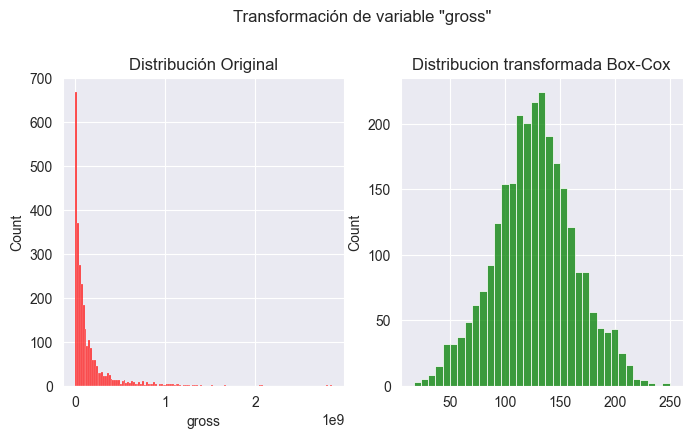

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Primer gráfico: KDE Plot
sns.histplot(df['gross'], label='Original Data',color='r', ax=axs[0])
axs[0].set_title('Distribución Original')

# Segundo gráfico: Histograma de los datos transformados con Box-Cox
transformed_data, lambda_value = stats.boxcox(df['gross'])
sns.histplot(transformed_data, kde=False, label='Box-Cox Transformed Data', color='g', ax=axs[1])
axs[1].set_title('Distribucion transformada Box-Cox')
plt.suptitle('Transformación de variable "gross"', y=1.05);

Llegamos este punto en el que la transformación logaritmica Box-Cox nos ayuda a cambiar la forma de nuestros datos y conseguir una distribución normal, nos planteamos si es necesaria la implementación de esta transformación a alguna variable más e incluso todo el dataset.

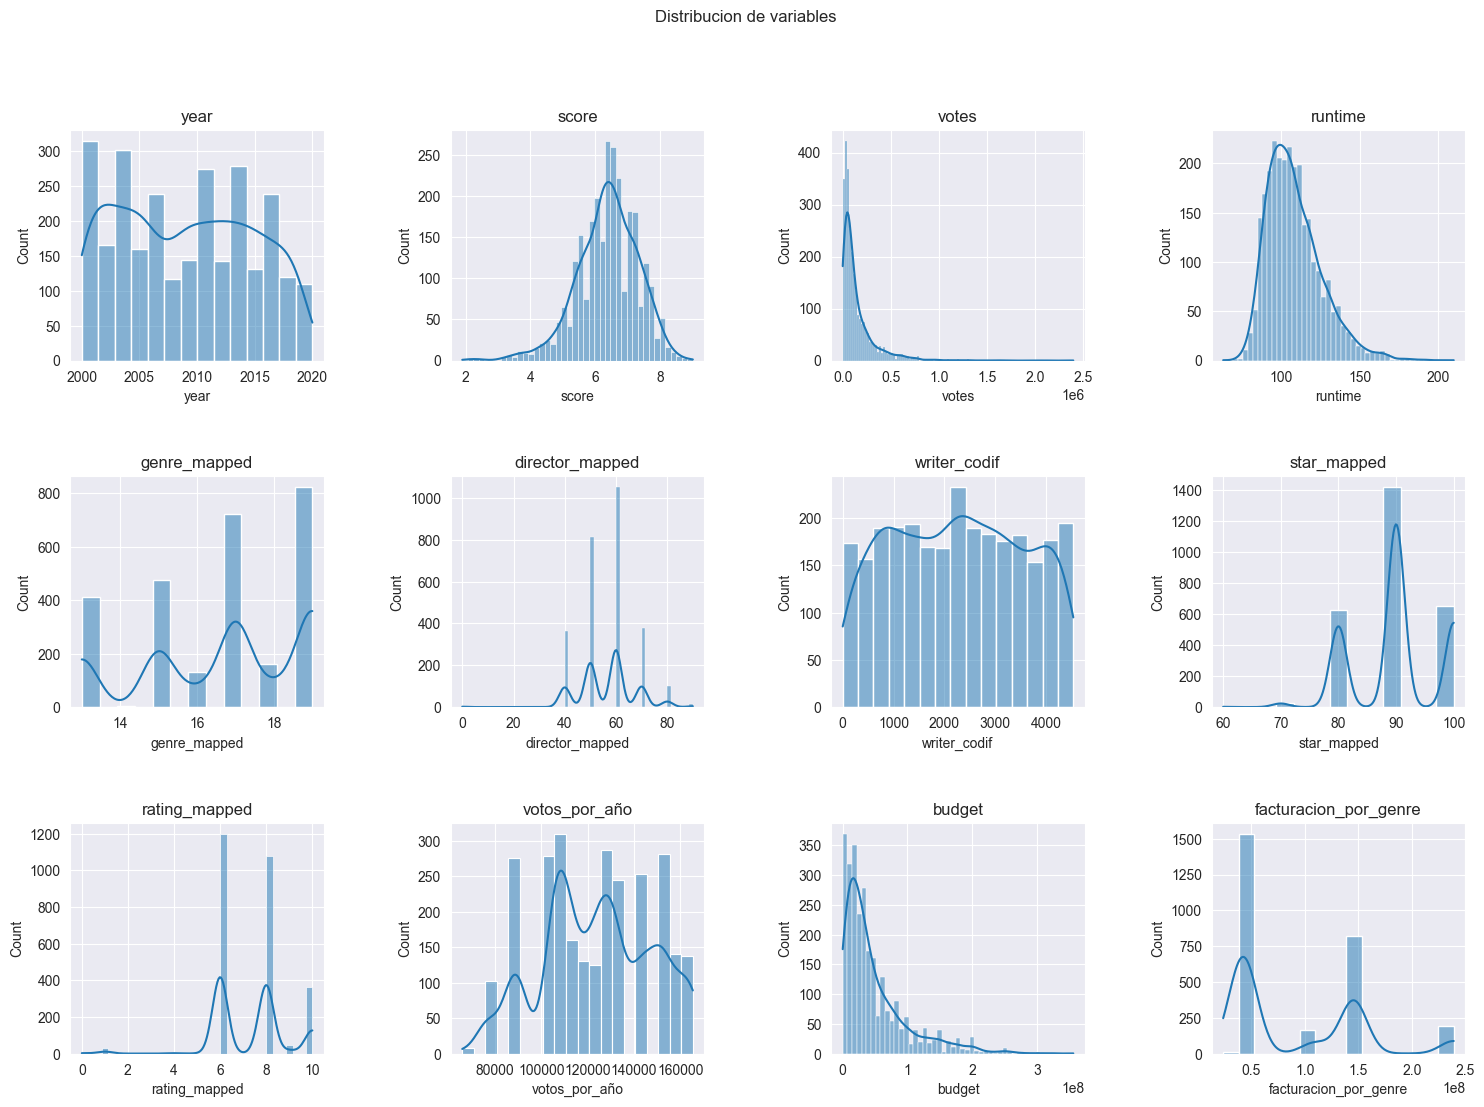

In [32]:
histogramas = df[['year', 'score', 'votes','runtime', 'genre_mapped', 'director_mapped',
                  'writer_codif','star_mapped','rating_mapped','votos_por_año','budget',
                  'facturacion_por_genre']]

fig, axs = plt.subplots(3, 4, figsize=(18, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, columna in enumerate(histogramas.columns):
    sns.histplot(histogramas[columna], ax=axs[i // 4, i % 4], kde=True)
    axs[i // 4, i % 4].set_title(columna)

plt.suptitle('Distribucion de variables')
plt.show();

Transformación de 'votes'

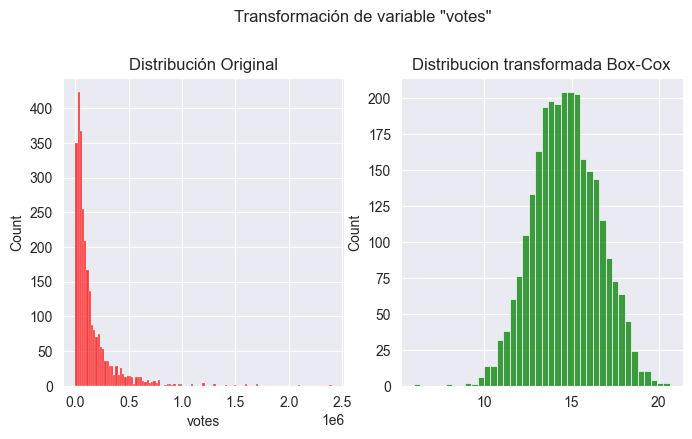

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Primer gráfico: KDE Plot
sns.histplot(df['votes'], label='Original Data',color='r', ax=axs[0])
axs[0].set_title('Distribución Original')

# Segundo gráfico: Histograma de los datos transformados con Box-Cox
transformed_data, lambda_value = stats.boxcox(df['votes'])
sns.histplot(transformed_data, kde=False, label='Box-Cox Transformed Data', color='g', ax=axs[1])
axs[1].set_title('Distribucion transformada Box-Cox')

plt.suptitle('Transformación de variable "votes"', y=1.05);

Transformación de budget

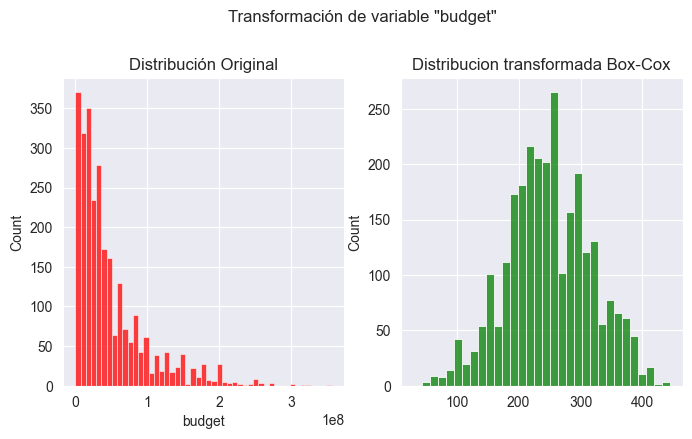

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Primer gráfico: KDE Plot
sns.histplot(df['budget'], label='Original Data',color='r', ax=axs[0])
axs[0].set_title('Distribución Original')

# Segundo gráfico: Histograma de los datos transformados con Box-Cox
transformed_data, lambda_value = stats.boxcox(df['budget'])
sns.histplot(transformed_data, kde=False, label='Box-Cox Transformed Data', color='g', ax=axs[1])
axs[1].set_title('Distribucion transformada Box-Cox')

plt.suptitle('Transformación de variable "budget"', y=1.05);

# 6. EDA

Definitivamente hay variables que no correlan en absoluto y consideramos que es mejor no confundir al modelo y quitarlas antes de empezar con el entrenamiento

In [35]:
df = df[['year', 'score', 'votes','runtime', 'genre_mapped', 'director_mapped','star_mapped',
         'votos_por_director','rating_mapped', 'facutracion_por_director','budget',
         'facturacion_por_genre','gross']]

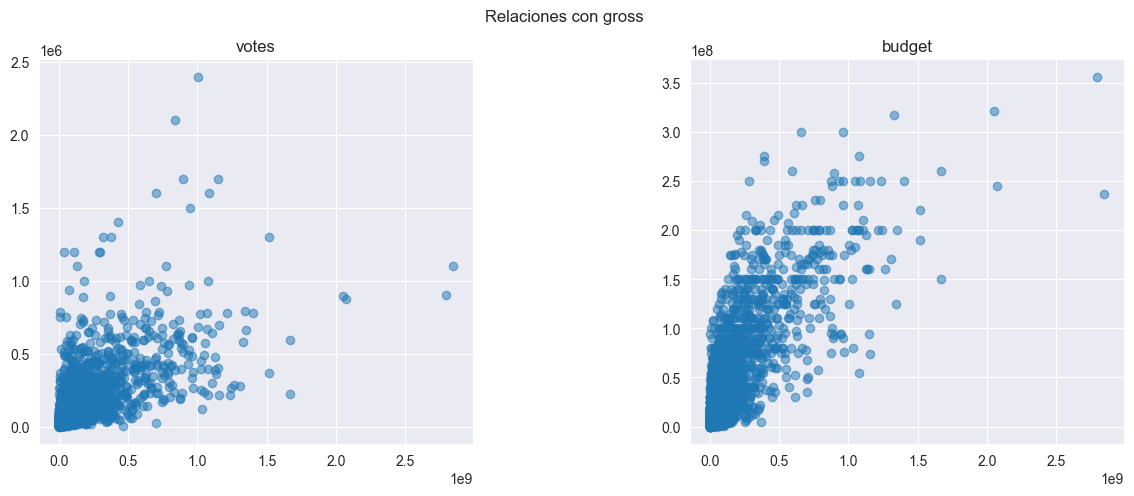

In [36]:
scatters = df[['votes', 'budget']]
gross = df['gross']

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, columna in enumerate(scatters.columns):
    axs[i].scatter(gross, scatters[columna], alpha=0.5)
    axs[i].set_title(columna)

plt.suptitle('Relaciones con gross')
plt.show()


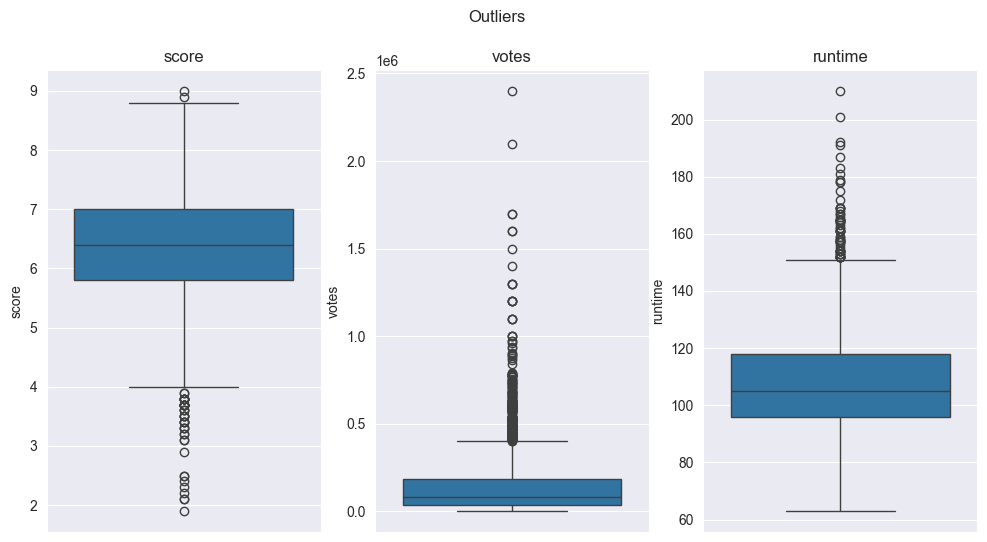

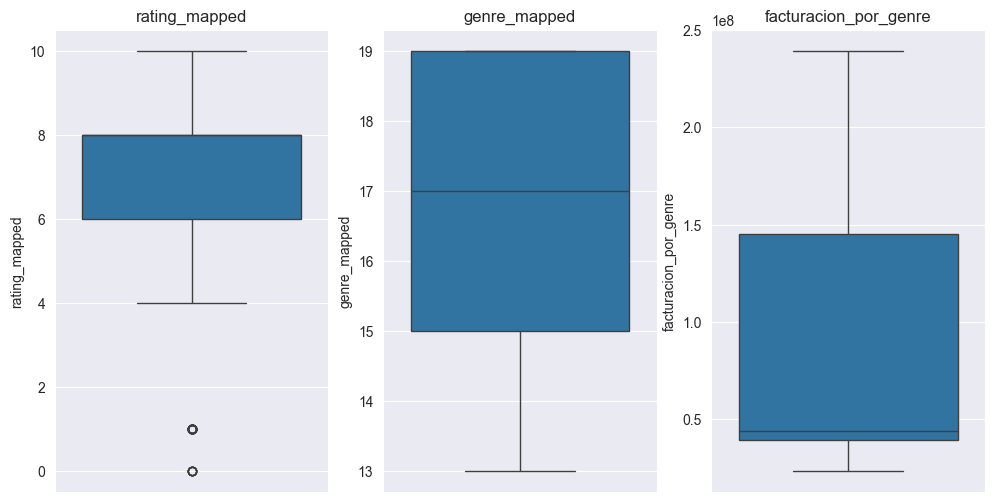

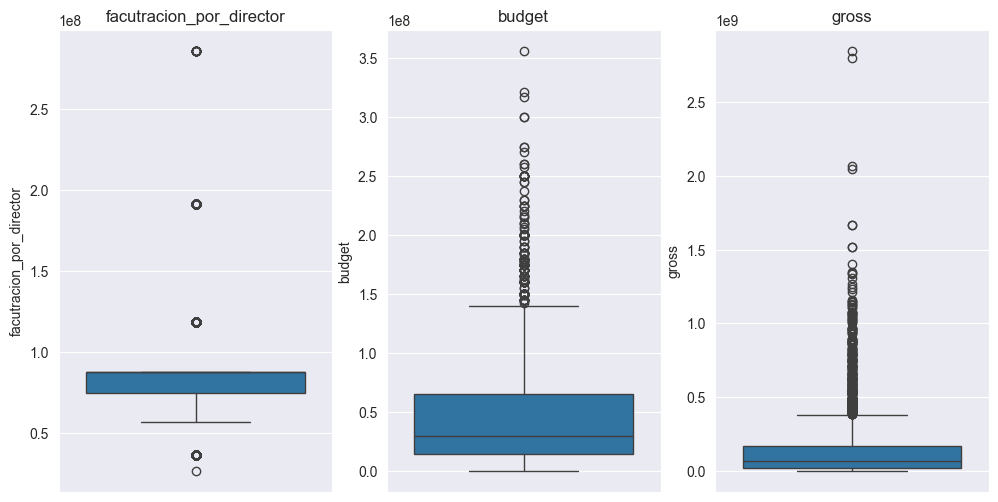

In [37]:
columna1 = ['score','votes','runtime']
columna2 = ['rating_mapped','genre_mapped','facturacion_por_genre']
columna3 = ['facutracion_por_director','budget','gross']

fig, axs = plt.subplots(1, len(columna1), figsize=(12, 6))
for i, columna in enumerate(columna1):
    sns.boxplot(y=columna, data=df, ax=axs[i])
    axs[i].set_title(columna)
plt.suptitle('Outliers')

fig, axs = plt.subplots(1, len(columna2), figsize=(12, 6))
for i, columna in enumerate(columna2):
    sns.boxplot(y=columna, data=df, ax=axs[i])
    axs[i].set_title(columna)

fig, axs = plt.subplots(1, len(columna3), figsize=(12, 6))
for i, columna in enumerate(columna3):
    sns.boxplot(y=columna, data=df, ax=axs[i])
    axs[i].set_title(columna)

### 6.1 Outliers

Tras este estudio de outliers nos encontramos en una dicotomía en cuanto a que es cierto que encontramos una disparidad en valores de algunas variables, por otro lado también consideramos que realmente no son valores atípicos ni errores y si son ejemplos representativos de la realidad del negocio y consideramos que no seria correcto eliminarlos.

Finalmente consideramos que probablemente para tener mas certeza sobre esto deberiamos hacer diferentes pruebas iterando a través de la eliminación de diferentes volúmenes de outliers para ver las métricas obtenidas en los modelos de predicción y ver si un modelo realmente es capaz de aprender en alguna de las iteraciones. Lamentablemente el tiempo de este proyecto es limitado y no podemos abarcar ese estudio con lo que decidimos ignorar esos outliers.

In [ ]:
# df.to_csv('processed.csv', index=False)

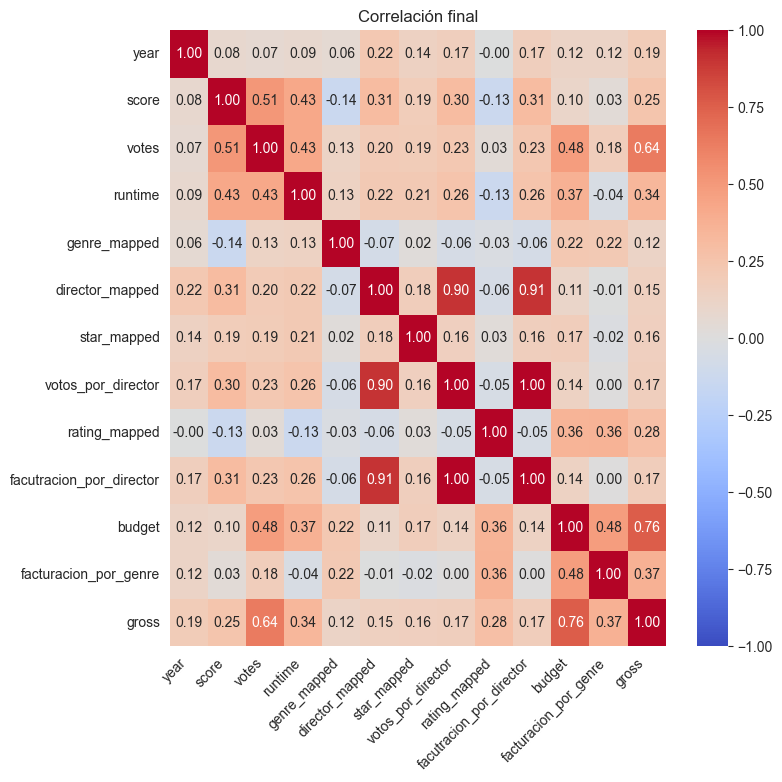

In [ ]:
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(df.corr(numeric_only=True), vmax=1, vmin=-1, annot=True, cmap='coolwarm', fmt='.2f')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Correlación final');

# 7. Hiperparametrización y modelado

Train test split

In [38]:
X = df.drop(['gross'], axis=1)
y = df['gross']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2187, 12)
(547, 12)
(2187,)
(547,)


In [ ]:
Celda para cortar el "run all"

SyntaxError: invalid syntax (2257070297.py, line 1)

Regresión Lineal

In [ ]:
pipeline_lnr = Pipeline([
    ('scaler', StandardScaler()),  
    ('regression', LinearRegression())
    ])

parametros_grid = {'regression__fit_intercept': [True, False]}

grid_search = GridSearchCV(pipeline_lnr, parametros_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1)#, n_jobs=-1)

grid_search.fit(X_train, y_train)

mejores_parametros_lnr = grid_search.best_params_

y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mejores hiperparámetros: {mejores_parametros_lnr}")
print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape, 2)} %")
print(f"R2: {round(r2, 2)}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Mejores hiperparámetros: {'regression__fit_intercept': True}
MAE: 73591994.34
MAPE: 19.51 %
R2: 0.66


Regresión polinomial

In [ ]:
pipeline_polyr = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('regression', LinearRegression())
])

parametros_grid = {
    'poly__degree': [2, 3, 4], 
    'regression__fit_intercept': [True, False]
}

grid_search = GridSearchCV(pipeline_polyr, parametros_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
mejores_parametros_polyr = grid_search.best_params_
y_pred = grid_search.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mejores hiperparámetros: {mejores_parametros_polyr}")
print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape, 2)} %")
print(f"R2: {round(r2, 2)}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros: {'poly__degree': 4, 'regression__fit_intercept': False}
MAE: 1.7160091884801974e+17
MAPE: 8853503590.76 %
R2: -1.2292022292239306e+20


Ridge

In [ ]:
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('ridge', Ridge()) 
])

parametros_grid = {
    'poly__degree': [2, 3, 4], 
    'ridge__alpha': [0.1, 1.0, 10.0], 
}

grid_search = GridSearchCV(pipeline_ridge, parametros_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
mejores_parametros_ridge = grid_search.best_params_
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mejores hiperparámetros: {mejores_parametros_ridge}")
print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape, 2)} %")
print(f"R2: {round(r2, 2)}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Mejores hiperparámetros: {'poly__degree': 2, 'ridge__alpha': 10.0}
MAE: 64347904.35
MAPE: 8.32 %
R2: 0.67


Lasso

In [66]:
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),  
    ('poly', PolynomialFeatures()),  
    ('lasso', Lasso())  
])

parametros_grid = {
    'poly__degree': [2, 3, 4, 5],  
    'lasso__alpha': [0.1, 1.0, 10.0], 
}

grid_search = GridSearchCV(pipeline_lasso, parametros_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
mejores_parametros_lasso = grid_search.best_params_
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mejores hiperparámetros: {mejores_parametros_lasso}")
print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape, 2)} %")
print(f"R2: {round(r2, 2)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores hiperparámetros: {'lasso__alpha': 10.0, 'poly__degree': 2}
MAE: 66968519.14
MAPE: 7.89 %
R2: 0.64


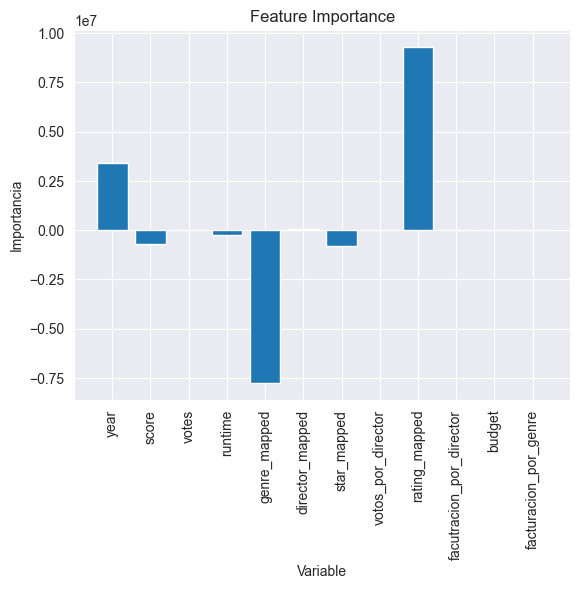

In [68]:
lasso_model = grid_search.best_estimator_['lasso']
lasso_model.fit(X_train, y_train)
feature_importance = lasso_model.coef_
feature_importance = feature_importance.ravel()

num_features = len(X.columns)
plt.bar(range(num_features), feature_importance)
plt.xticks(range(num_features), X.columns, rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importancia')
plt.title('Feature Importance')
plt.show()

Elastic Net

In [ ]:
pipeline_en = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly', PolynomialFeatures()), 
    ('elastic_net', ElasticNet())
])

parametros_grid = {
    'poly__degree': [2, 3, 4], 
    'elastic_net__alpha': [0.1, 1.0, 10.0], 
    'elastic_net__l1_ratio': [0.1, 0.5, 0.9]
}

grid_search = GridSearchCV(pipeline_en, parametros_grid, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
mejores_parametros_en = grid_search.best_params_
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mejores hiperparámetros: {mejores_parametros_en}")
print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape, 2)} %")
print(f"R2: {round(r2, 2)}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores hiperparámetros: {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.9, 'poly__degree': 2}
MAE: 63460778.31
MAPE: 8.8 %
R2: 0.68


Random Forest Regressor

In [ ]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), 
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [5, 10, 20],  
    'rf__max_depth': [None, 10, 20],  
}

grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred_rf = best_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"MAE: {round(mae_rf, 2)}")
print(f"MAPE: {round(mape, 2)} %")
print(f"MSE: {round(mse_rf, 2)}")
print(f"R2: {round(r2_rf, 2)}")

Random Forest Regressor:
Best Parameters: {'rf__max_depth': 10, 'rf__n_estimators': 20}
MAE: 59139430.25
MAPE: 8.8 %
MSE: 1.4005954174508328e+16
R2: 0.7


Gradient Boosting

In [ ]:
pipeline_gb = Pipeline([
    ('scaler', StandardScaler()), 
    ('gb', GradientBoostingRegressor(random_state=42))
])


param_grid_gb = {
    'gb__n_estimators': [50, 100, 200], 
    'gb__learning_rate': [0.01, 0.1, 0.2], 
    'gb__max_depth': [3, 5, 7],
}

grid_search_gb = GridSearchCV(pipeline_gb, param_grid_gb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

best_model_gb = grid_search_gb.best_estimator_

y_pred_gb = best_model_gb.predict(X_test)

mae_gb = mean_absolute_error(y_test, y_pred_gb)
mape = mean_absolute_percentage_error(y_test, y_pred)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Regressor:")
print(f"Best Parameters: {grid_search_gb.best_params_}")
print(f"MAE: {round(mae_gb, 2)}")
print(f"MAPE: {round(mape, 2)} %")
print(f"MSE: {round(mse_gb, 2)}")
print(f"R2: {round(r2_gb, 2)}")


Gradient Boosting Regressor:
Best Parameters: {'gb__learning_rate': 0.1, 'gb__max_depth': 5, 'gb__n_estimators': 100}
MAE: 58732665.82
MAPE: 8.8 %
MSE: 1.6448920209702356e+16
R2: 0.64


Lasso con PCA

In [39]:
pipeline_lasso_pca = Pipeline([
    ('scaler', StandardScaler()),  
    ('poly', PolynomialFeatures()),  
    ('pca', PCA()), 
    ('lasso', Lasso())  
])

parametros_grid_pca = {
    'poly__degree': [2, 3, 4, 5],  
    'pca__n_components': [None, 2, 5, 10],  
    'lasso__alpha': [0.1, 1.0, 10.0], 
}

grid_search_pca = GridSearchCV(pipeline_lasso_pca, parametros_grid_pca, scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search_pca.fit(X_train, y_train)

mejores_parametros_lasso_pca = grid_search_pca.best_params_
y_pred_pca = grid_search_pca.predict(X_test)

mae_pca = mean_absolute_error(y_test, y_pred_pca)
mape_pca = mean_absolute_percentage_error(y_test, y_pred_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print(f"Mejores hiperparámetros con PCA: {mejores_parametros_lasso_pca}")
print(f"MAE con PCA: {round(mae_pca, 2)}")
print(f"MAPE con PCA: {round(mape_pca, 2)} %")
print(f"R2 con PCA: {round(r2_pca, 2)}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros con PCA: {'lasso__alpha': 10.0, 'pca__n_components': None, 'poly__degree': 2}
MAE con PCA: 67489365.6
MAPE con PCA: 7.85 %
R2 con PCA: 0.64


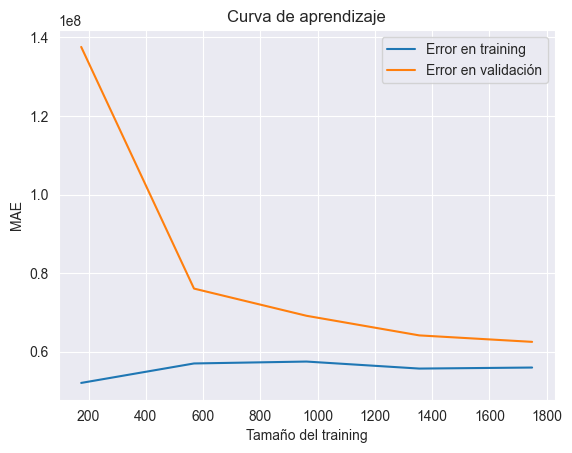

In [48]:
train_sizes, train_scores, val_scores = learning_curve(grid_search_pca.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
train_mean = -train_scores.mean(axis=1)
val_mean = -val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label='Error en training')
plt.plot(train_sizes, val_mean, label='Error en validación')

plt.xlabel('Tamaño del training')
plt.ylabel('MAE')
plt.title('Curva de aprendizaje')
plt.legend();

Aquí podemos visualizar el recorrido de la curva de aprendizaje, es decir podemos ver si añadiendo mas datos de entrenamiento el error en validación mejoraría. La conclusión de esta visualización es que hemose seleccionado un punto en el que no va a mejorar mas y es probable que con mas datos de entrenamiento caiga en overfiting.

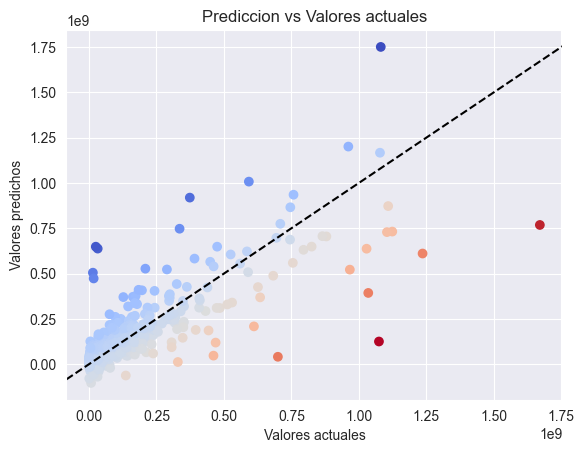

In [71]:
y_pred_pca = grid_search_pca.predict(X_test)

diferencia = y_test - y_pred_pca

plt.axline(xy1=(min(y_test), min(y_test)), slope=1, color='black', linestyle='--')

plt.scatter(y_test, y_pred_pca, c=diferencia, cmap='coolwarm')
plt.xlabel('Valores actuales')
plt.ylabel('Valores predichos')
plt.title('Prediccion vs Valores actuales')
plt.show()

Con este scatter podemos ver de manera clara como se dispersan las predicciónes frente los valores reales, cuanto más claros estarán mas cercanos a la linea negra que representa los valores reales y cuanto más coloreados serán predicciones positivas o negativas mas dispersos o alejados de los datos reales.

Red neuronal

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(32, activation="relu"),  
    keras.layers.Dense(1, activation="linear")
])

model.compile(
    loss="mse",
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=["mape"]
)

print(model.summary())

early_stopping = keras.callbacks.EarlyStopping(patience=5)

history = model.fit(X_train_scaled, y_train, epochs=1000, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 128)               1664      
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 32)                2080      
                                                                 
 dense_54 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12033 (47.00 KB)
Trainable params: 12033 (47.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/1000
55/55 [==============================] - 1s 3ms/step - loss: 76332426527244288.0000 - mape: 99.9993 - val_loss: 77173157785501696.0

In [ ]:
history.history

{'loss': [7.633242652724429e+16,
  7.633238357757133e+16,
  7.633221177887949e+16,
  7.633189395129958e+16,
  7.633125829613978e+16,
  7.633013301470822e+16,
  7.63284407975936e+16,
  7.632588099708518e+16,
  7.632229899436032e+16,
  7.631767760954982e+16,
  7.631161311572787e+16,
  7.6303736145707e+16,
  7.629329078524314e+16,
  7.628117897746842e+16,
  7.626510720984678e+16,
  7.62460805047255e+16,
  7.622511247438643e+16,
  7.62004593621074e+16,
  7.617002522384794e+16,
  7.613447148457165e+16,
  7.609503509485978e+16,
  7.604827149094093e+16,
  7.599566673149952e+16,
  7.59320067262382e+16,
  7.586549486269235e+16,
  7.578600360797798e+16,
  7.570361754530611e+16,
  7.5601088086016e+16,
  7.549759655405158e+16,
  7.538299823665971e+16,
  7.525090222250394e+16,
  7.51120029801513e+16,
  7.495254802432e+16,
  7.478877233138893e+16,
  7.46102391308288e+16,
  7.440769706308403e+16,
  7.419540541957734e+16,
  7.39630906385367e+16,
  7.37151593564078e+16,
  7.3461541537579e+16,
  7.31892

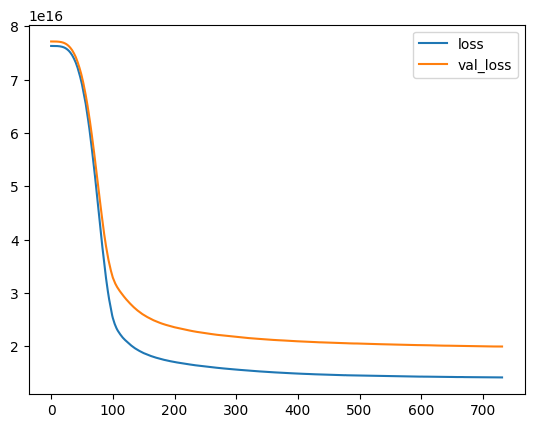

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot();

In [ ]:
model.evaluate(X_test_scaled, y_test)

 1/18 [>.............................] - ETA: 0s - loss: 8091469277560832.0000 - mape: 299.3626

18/18 [==============================] - 0s 1ms/step - loss: 14459143767195648.0000 - mape: 614.5144


[1.4459143767195648e+16, 614.514404296875]

Consideramos que la red neuronal no es lo más apropiado, hemos probado con diferentes estructuras y combinaciones de los parametros de la red neuronal pero no hemos co nseguido mejorar mas de un 90% de MAPE.

# 8. Métricas y modelo final

La métrica en la que queremos basarnos para la eleccion del modelo es el Mape debido a que estamos hablando de predecir cientos de miles de dolares y creemos que resulta mas entendible manejar porcentajes de error 

Finalmente el modelo elegido es la Regresión Polinomial con regularización Lasso y PCA.

En conjunto, la regresión polinómica captura complejidades en la relación entre las variables, Lasso trabaja con la regularización y nos ayuda a evitar el sobreajuste al eliminar características menos importantes y el PCA reduce puede reducir la dimensionalidad del modelo y conseguir con esta combinación un modelo robusto y eficiente. 

In [ ]:
#quitamos del diccionario la red neuronal y la regresión polinomial básica por que distorsionaban los datos muchísimo.

metricas = {'Regresión Lineal': 19.51,
            'Reg Pol + Ridge': 8.32,
            'Reg Pol + Lasso': 7.89,
            'Reg Pol + EN': 8.8,
            'R Forest Regressor': 8.8,
            'GBoosting Regressor': 8.8,
            'Reg Pol + Lasso + PCA': 7.85}

df_metricas = pd.Series(metricas, name='Mape').to_frame()
df_metricas


,Mape
Regresión Lineal,19.51
Reg Pol + Ridge,8.32
Reg Pol + Lasso,7.89
Reg Pol + EN,8.80
R Forest Regressor,8.80
GBoosting Regressor,8.80
Reg Pol + Lasso + PCA,7.85


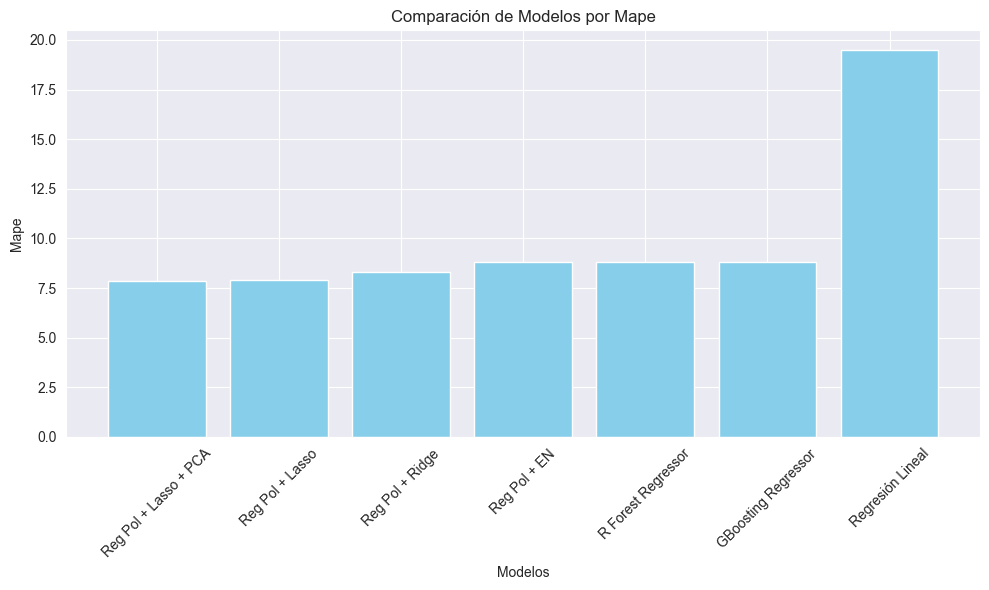

In [ ]:
df_metricas = df_metricas.sort_values(by='Mape')

plt.figure(figsize=(10, 6))
plt.bar(df_metricas.index, df_metricas['Mape'], color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('Mape')
plt.title('Comparación de Modelos por Mape')
plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
pipeline_lasso_pca = Pipeline([
    ('scaler', StandardScaler()),  
    ('poly', PolynomialFeatures()),  
    ('pca', PCA()), 
    ('lasso', Lasso())  
])

parametros_grid_pca = {
    'poly__degree': [2],  
    'pca__n_components': [None],  
    'lasso__alpha': [10.0], 
}

grid_search_pca = GridSearchCV(pipeline_lasso_pca, parametros_grid_pca, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search_pca.fit(X, y)

mejores_parametros_lasso_pca = grid_search_pca.best_params_

modelo_final = grid_search_pca.best_estimator_
modelo_final.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('pca', PCA()), ('lasso', Lasso(alpha=10.0))])

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Mejores hiperparámetros con PCA: {'lasso__alpha': 10.0, 'pca__n_components': None, 'poly__degree': 2}


MAE con PCA: 67489365.6


MAPE con PCA: 7.85 %


R2 con PCA: 0.64



# 9. Pickle

In [ ]:
with open('final_model.pkl', "wb") as archivo_salida:
    pickle.dump(modelo_final, archivo_salida)

# 10. Lecciones aprendidas

Este trabajo ha sido la concatenación de muchas herramientas obtenidas en relativamente poco tiempo. Frustrante en muchas ocasiones ya que el propio aprendizaje lleva intrínseco la visualización de expcionales trabajos y es muy dificil evitar la comparación con uno mismo , olvidando al 100% que somos estudiantes y estamos aprendiendo.

Dicho esto, mis conclusiones sobre las lecciones aprendidas son:

- La dinámica iterativa incremental es una manera maravillosa de no atascarse y afrontar los problemas a su debido momento, cuando ya existe o has creado un contexto para poder abordar algo con mayor profundidad de negocio.

- He concluido (quizá erroneamente,y si es así por favor iluminenme) que en proyectos donde el dataset no esté limpio el porcentaje de tiempo dedicado a la compresion del dataset inicial, al feature engineering, limpieza de datos y creación de nuevas variables propias es practicamente lo más importante y lo que mejores resultados te brindará. Pero en esta ocasión la dimension del proyecto y la prisa por hacer lo "guay" (modelos de ML) ocultaron la realidad y quizá el margen de mejora estaría ahí.

- A pesar de que me ha gustado mucho poder dedicar estas 3 semanas a un proyecto, los resultados no son lo que a mi me gustaría, siendo crítico y haciendo una prueba con datos reales, y teniendo la predicción el modelo no se acerca a lo que en realidad ha sucedido y eso es desalentador, o bien por mi falta de capacidad a la hora de realizar el proyecto o bien por que esto del machine learning como dice un conocido es pseudociencia. 

Gracias a profesores y a todos mis compañeros, ya que sin su ayuda estoy seguro que esto no hubiese salido, o por lo menos igual.

Proyecto elaborado por Alejandro Campos Ochoa

29/11/2023